In [1]:
suppressPackageStartupMessages({
    ## This is my custom library for various helper functions for spatial pre-processing 
    # devtools::install_github('korsunskylab/spatula', dependencies = FALSE)    
    # devtools::install_github('korsunskylab/spatula')
    library(harmony)
    library(uwot)
    library(singlecellmethods)
    library(sfarrow)
    library(geojsonsf)
    library(sf)    
    library(spatula)
    library(purrr)
    library(furrr)
    library(ggrepel)
    library(future)
    library(scales)
    library(glue)
    library(data.table)
    library(spatstat)
    library(dplyr)
    library(data.table)
    library(presto)
    library(ggplot2)
    library(ggthemes)
    library(patchwork)
    library(Matrix)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}

## Clustering functions 
source('../ModularityClustering/R/modularity_clustering.R')
sourceCpp('../ModularityClustering/src/RModularityOptimizer.cpp')


source('../Roche/R/utils_plotting.R')
source('../Roche/R/utils.R')


readMM_fast <- function(fname, max_header_size = 100, nthreads = NULL) {
    ## First, figure out how many lines to skip
    ## Assumes that MM format has comments that start with %
    nlines_skip <- 0
    con <- file(fname, open = 'r')
    for (i in seq_len(max_header_size)) {
        line <- readLines(con, 1)
        nlines_skip <- nlines_skip + 1
        if (!grepl('^\\W*\\%', line)) {
            ## This is the line with dimension information 
            ## We need dimension information to handle empty rows and columns 
            nrow <- as.integer(strsplit(line, ' ')[[1]][1])
            ncol <- as.integer(strsplit(line, ' ')[[1]][2])
            break
        }
    }
    close(con)

    if (is.null(nthreads)) {
        nthreads <- data.table::getDTthreads()
    }
    ## Then, read the file and make a matrix 
    with(
        fread(fname, skip = nlines_skip, nThread = nthreads),
        Matrix::sparseMatrix(i = V1, j = V2, x = V3, dims = c(nrow, ncol))
    )
}


writeMM_fast <- function(X, fname) {
    stopifnot(is(X, 'dgCMatrix'))
    nelem <- length(X@i)
    nrow <- X@Dim[1]
    ncol <- X@Dim[2]    
    writeLines(paste0(c('%%MatrixMarket matrix coordinate real general\n', nrow, ' ', ncol, ' ', nelem), collapse = ''), fname)    
    fwrite(data.table(X@i+1, rep(seq_len(ncol), times = diff(X@p)), X@x), fname, append = TRUE, sep = ' ')        
}


Registered S3 methods overwritten by 'RcppEigen':
  method               from         
  predict.fastLm       RcppArmadillo
  print.fastLm         RcppArmadillo
  summary.fastLm       RcppArmadillo
  print.summary.fastLm RcppArmadillo



# Data

In [4]:
meta_data <- st_read_parquet('lung_n4/cells_w_regions.parquet')
meta_data$cell <- as.character(meta_data$cell)

In [5]:
## ~2.5 million cells
nrow(meta_data) / 1e6

## 80K in hubs and 800K in tumor 
table(meta_data$region_type)


[1] 2.475649


   hub  tumor 
 79371 823192 

In [7]:
counts <- readMM_fast('lung_n4/counts.mtx')
rownames(counts) <- readLines('lung_n4/genes.tsv')
colnames(counts) <- readLines('lung_n4/cellnames.tsv')


In [8]:
## Remove blanks 
counts <- counts[which(!grepl('Blank', rownames(counts))), ]

## only keep cells in tumor or hub regions 
meta_data <- subset(meta_data, region_type %in% c('hub', 'tumor'))
counts <- counts[, meta_data$cell]


In [9]:
head(meta_data)

Registered S3 method overwritten by 'geojson':
  method        from     
  print.geojson geojsonsf



cell library    X        Y         ntx ngene nblank region region_type
321 321  Patient001 7109.369  900.5181 81  40    2      R35    tumor      
358 358  Patient001 7096.291 1000.7293 73  46    0      R35    tumor      
359 359  Patient001 7096.450 1085.9823 33  25    0      R35    tumor      
360 360  Patient001 7116.647  917.4242 38  29    0      R35    tumor      
361 361  Patient001 7113.121  926.8925 45  38    0      R35    tumor      
362 362  Patient001 7093.795  947.4176 68  37    0      R35    tumor      
    bbox                          
321 POLYGON ((7104.381 894.4674...
358 POLYGON ((7090.55 995.4227,...
359 POLYGON ((7091.467 1083.426...
360 POLYGON ((7111.766 911.6127...
361 POLYGON ((7108.164 922.3126...
362 POLYGON ((7088.833 943.1668...

In [10]:
dim(counts)

[1]    479 902563

In [12]:
st_write_parquet(meta_data, 'lung_n4/cells_tumor_hub.parquet')
writeMM_fast(counts, 'lung_n4/counts_tumor_hub.mtx')
writeLines(rownames(counts), 'lung_n4/gene_tumor_hub.tsv')


Warning message:
“This is an initial implementation of Parquet/Feather file support and
geo metadata. This is tracking version 0.1.0 of the metadata
(https://github.com/geopandas/geo-arrow-spec). This metadata
specification may change and does not yet make stability promises.  We
do not yet recommend using this in a production setting unless you are
able to rewrite your Parquet/Feather files.”


# All together

## PCA

In [13]:
logcpx <- normalizeData(counts, median(colSums(counts)), 'log')

In [14]:
## Option 1: unweighted PCA
# pca_res <- weighted_pca(logcpx, rep(1, ncol(counts)), do_corr = FALSE) 

## Option 2: weight by sample ID
y <- with(meta_data, paste(library, region_type, sep = '_'))
weights <- as.numeric(((1/table(y))[y]) * (length(y)/length(unique(y))))
system.time({
    pca_res <- weighted_pca(logcpx, weights, do_corr = FALSE)     
})


   user  system elapsed 
398.731 704.384  92.024 

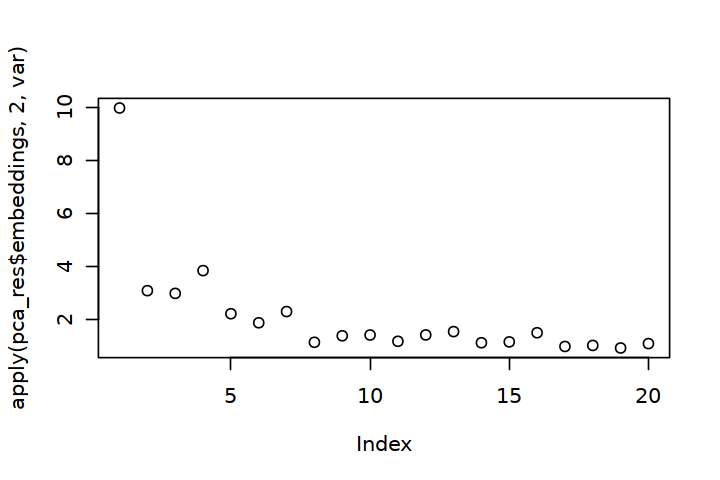

In [17]:
fig.size(4, 6)
plot(apply(pca_res$embeddings, 2, var))


In [18]:
system.time({
    ## Standard parameters 
    # U <- uwot::umap(pca_res$embeddings, min_dist = 0.1, spread = 0.3, ret_extra = 'fgraph')    
    
    ## Maxmize white space to highlight doublets 
    U <- uwot::umap(pca_res$embeddings, min_dist = 0.01, spread = 0.22, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 20)    
})



    user   system  elapsed 
1086.760   12.778  257.232 

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


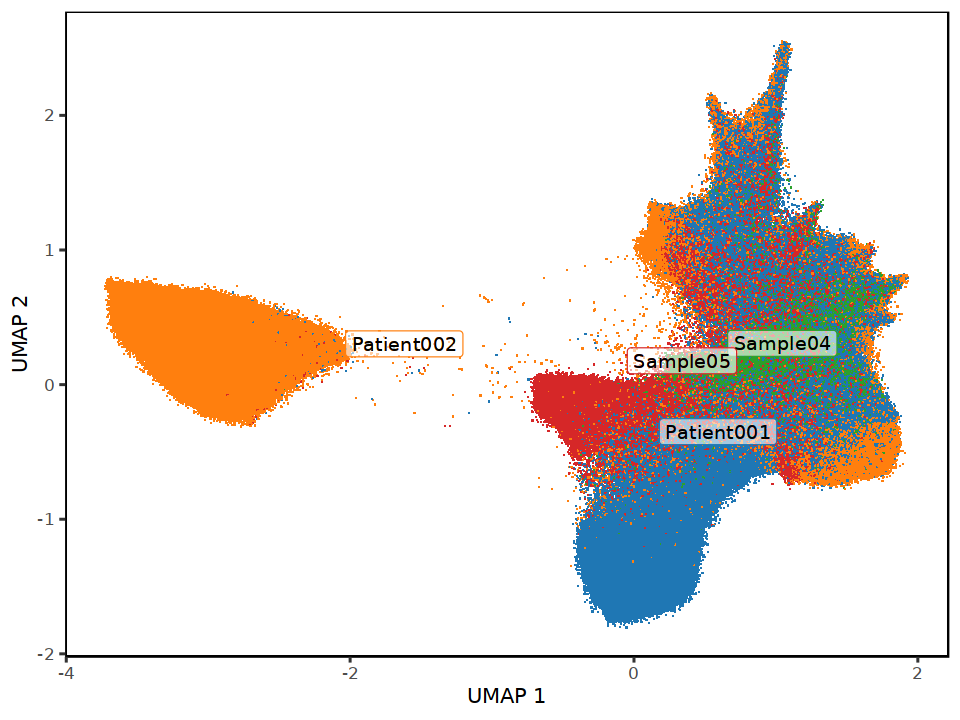

In [19]:
fig.size(6, 8)
do_scatter(U$embedding, meta_data, 'library', palette_use = tableau_color_pal('Classic 10')(4))

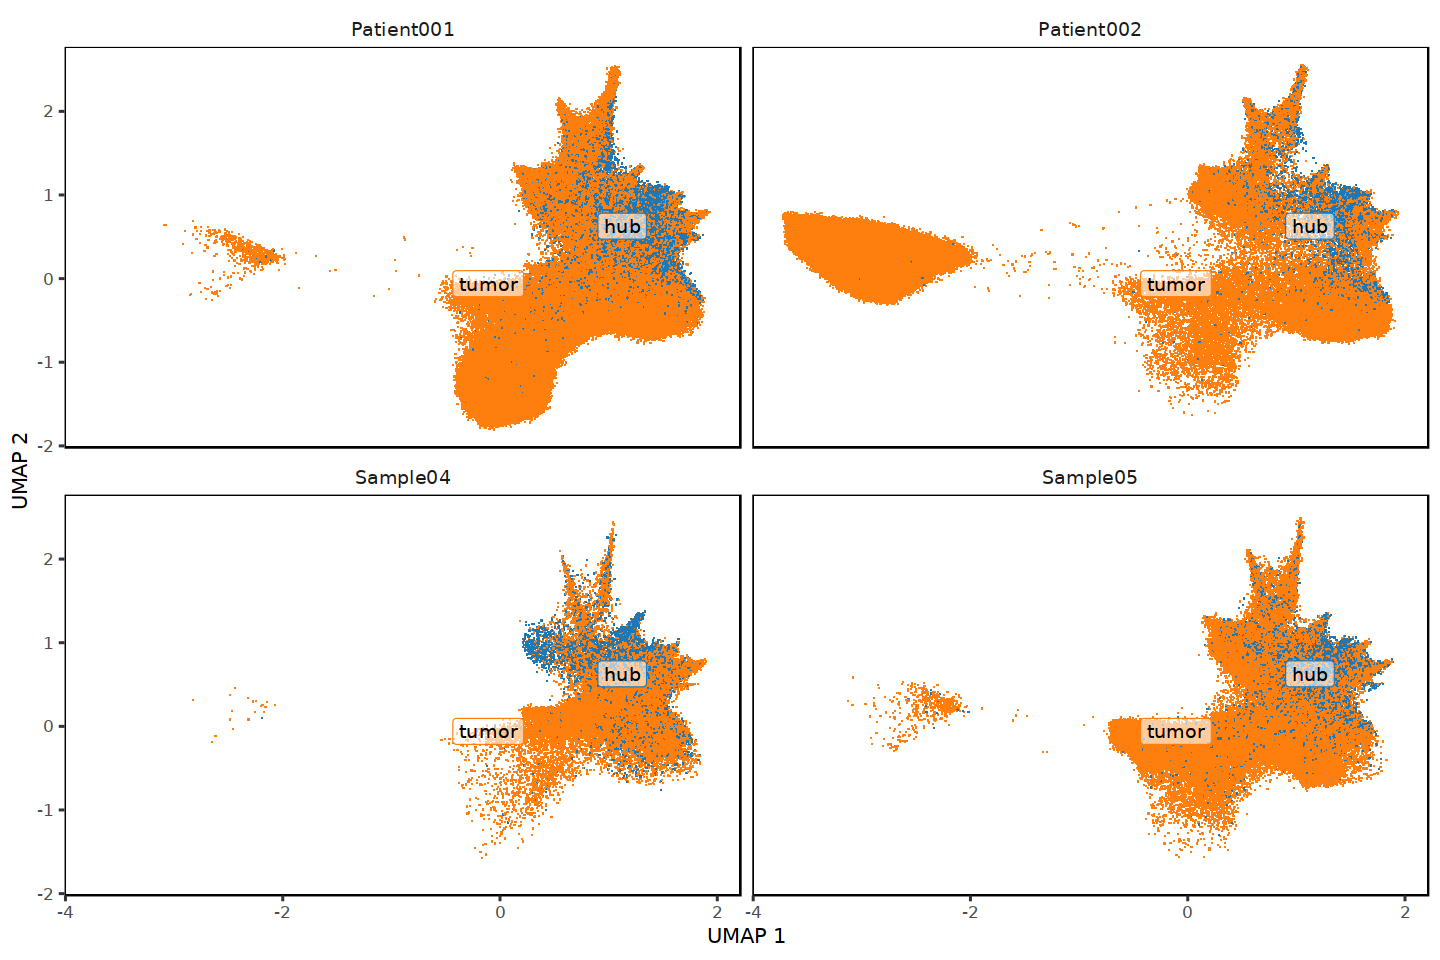

In [20]:
fig.size(8, 12)
do_scatter(U$embedding, meta_data, 'region_type', palette_use = tableau_color_pal('Classic 10')(2)) + 
    facet_wrap(~library, nrow = 2)


## Harmonize


In [ ]:
fig.size(5, 8)
system.time({
    harmony_res <- HarmonyMatrix(
        pca_res$embeddings, 
        meta_data, 'library', theta = .5, 
        do_pca = FALSE,
        # max.iter.harmony = 1, max.iter.cluster = 5, 
        max.iter.harmony = 5, max.iter.cluster = 30, 
        epsilon.cluster = -Inf, epsilon.harmony = -Inf, plot_convergence = TRUE, 
        return_object = TRUE
    )    
})


use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 45128150)”
Harmony 1/5

Harmony 2/5

Harmony 3/5



In [28]:
names(harmony_res)

[1] "setup"                    "sigma"                   
 [3] "Z_corr"                   ".pointer"                
 [5] "Z_cos"                    ".cppclass"               
 [7] "d"                        "_scale_dist"             
 [9] "ran_init"                 "check_convergence"       
[11] "block_size"               "Phi_moe"                 
[13] "objective_harmony"        "moe_correct_ridge_cpp"   
[15] "ran_setup"                "init_cluster_cpp"        
[17] "update_order"             "B"                       
[19] "Pr_b"                     "use_weights"             
[21] "epsilon_kmeans"           "weights"                 
[23] "kmeans_rounds"            "objective_kmeans_cross"  
[25] "dist_mat"                 "window_size"             
[27] "E"                        ".self"                   
[29] "objective_kmeans_entropy" "Phi"                     
[31] "K"                        "N"                       
[33] "O"                        "cluster_cpp"             
[35] "theta"                    "lambda"                  
[37] "R"                        "objective_kmeans"        
[39] "max_iter_kmeans"          "objective_kmeans_dist"   
[41] "cells_update"             ".module"                 
[43] "initialize"               ".refClassDef"            
[45] "Z_orig"                   "W"                       
[47] "epsilon_harmony"          "Y"

In [29]:
system.time({
    U2 <- uwot::umap(t(harmony_res$Z_cos), min_dist = 0.01, spread = 0.22, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 20)    
})


    user   system  elapsed 
1003.774   11.715  245.817 

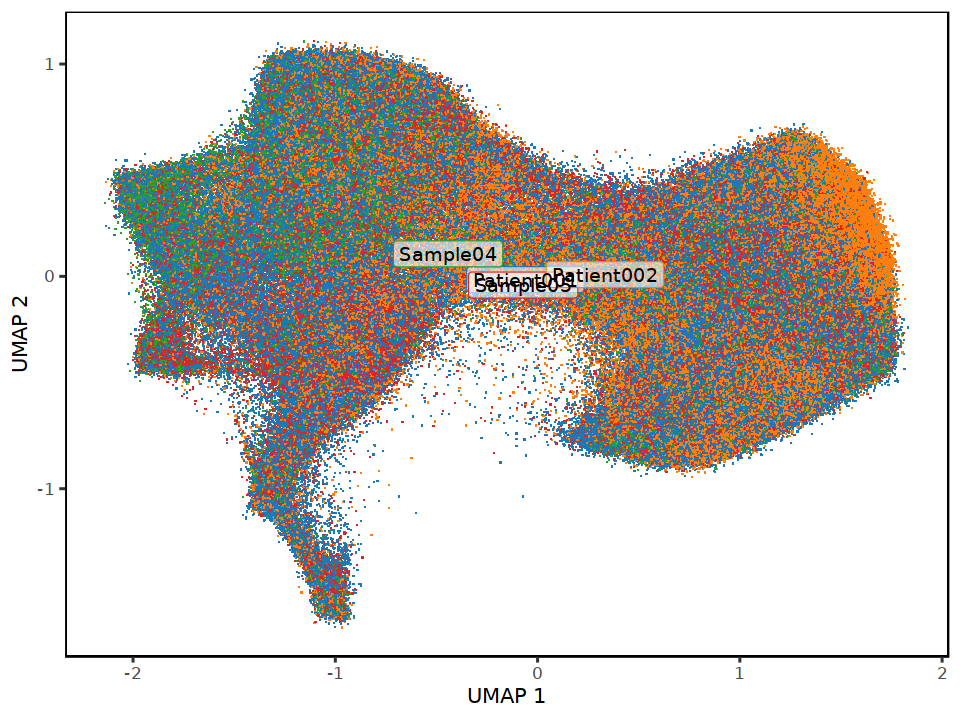

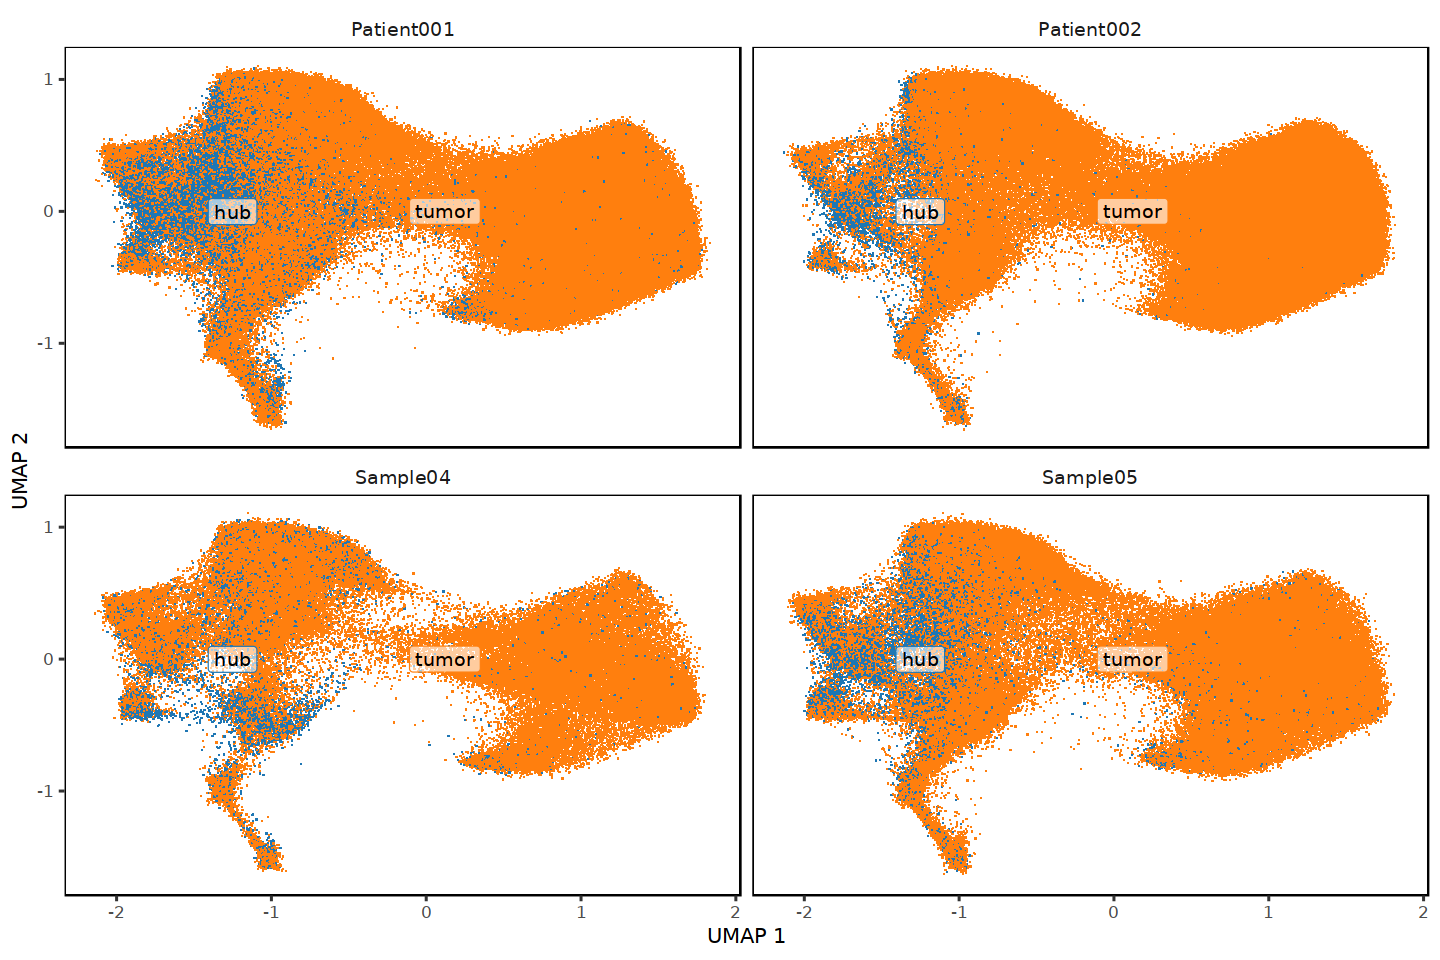

In [30]:
fig.size(6, 8)
do_scatter(U2$embedding, meta_data, 'library', palette_use = tableau_color_pal('Classic 10')(4))

fig.size(8, 12)
do_scatter(U2$embedding, meta_data, 'region_type', palette_use = tableau_color_pal('Classic 10')(2)) + 
    facet_wrap(~library, nrow = 2)


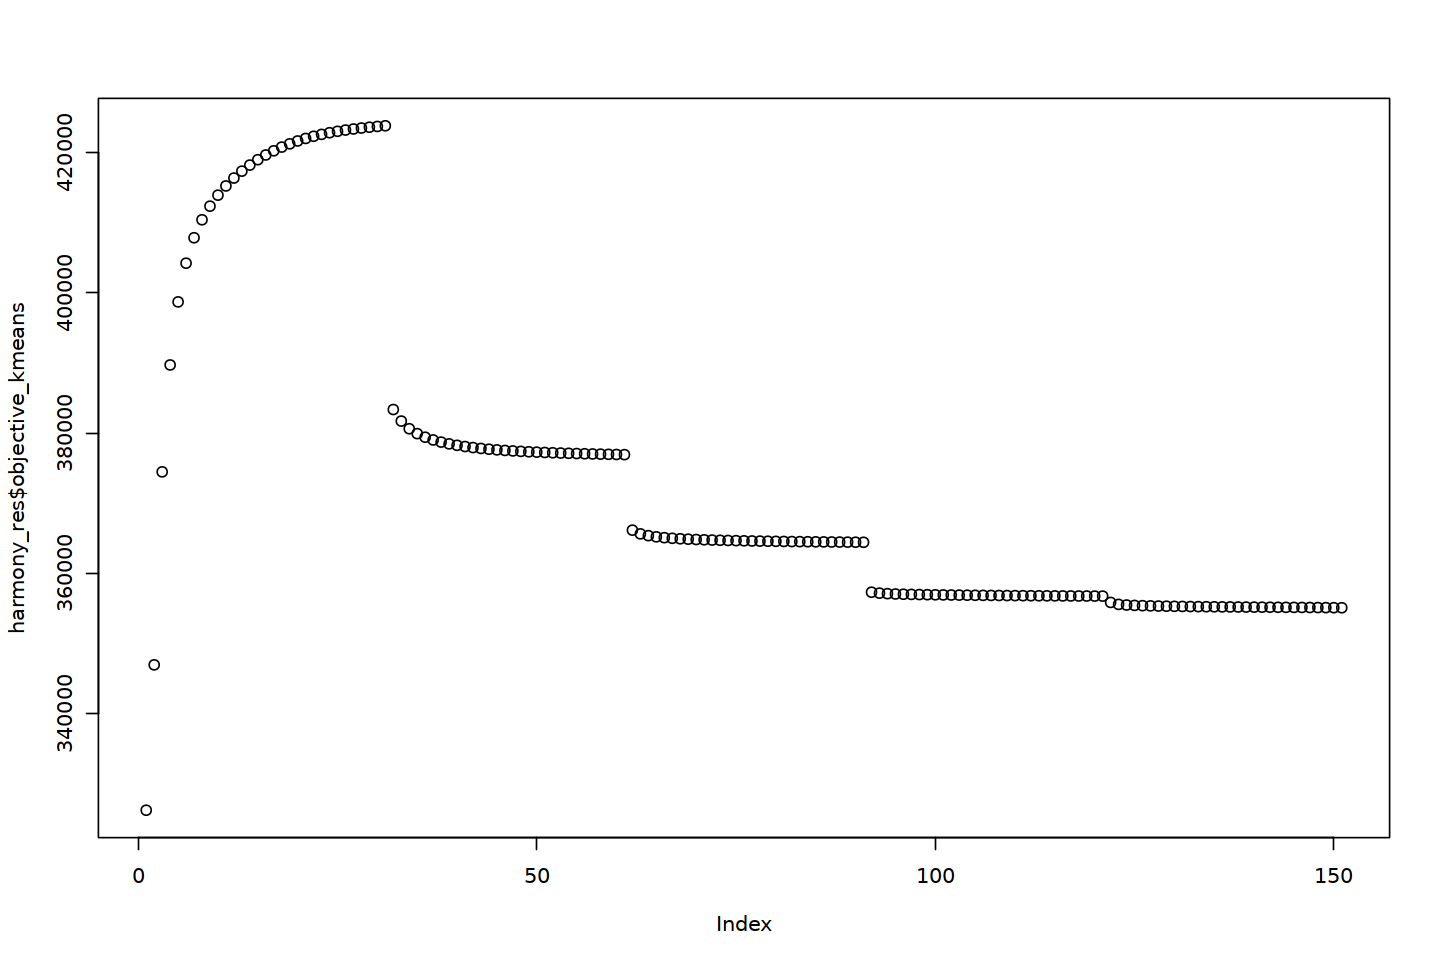

In [46]:
fig.size(5, 8)
plot(harmony_res$objective_kmeans)

## Clusters

In [4]:
## NOT DOING SNN HERE - TOO LARGE! ## 

# X = U2$fgraph
# length(X@x) / prod(dim(X))

# ## 6 minutes just to build the SNN? 

# ## 5 seconds
# system.time({    
#     # X <- U2$fgraph
#     X <- X + Diagonal(n = nrow(X), x = 1)    
# })
# length(X@x) / prod(dim(X))

# ## 1 minute
# ## 20x densification
# system.time({
#     # diag(X) <- 1
#     snn <- X %*% X 
# })
# length(snn@x) / prod(dim(snn))

# ##
# system.time({    
#     snn <- snn + Matrix::t(snn) ## make symmetric b/c Rcpp function only uses lower triangle 
# })
# length(snn@x) / prod(dim(snn))

# # snn@x[which(snn@x < quantile(snn@x, .01))] <- 0
# # snn <- Matrix::drop0(snn)

# ## ~1 minute
# ## would otherwise take >15min!!! 
# system.time({
#     writeMM_fast(snn, 'lung_n4/tumor_hub_snn.mtx')  
# })


# ## The problem is that the SNN may just be too large to run clustering 
# pryr::object_size(X)
# pryr::object_size(snn)


# ## ~2min to load 5GB matrix 
# system.time({
#     snn <- readMM_fast('lung_n4/tumor_hub_snn.mtx')  
# })


In [ ]:
plan(multicore)
system.time({
    clusters <- RunModularityClustering(U2$fgraph, resolution = c(.1, .2, .4, .6, .8, 1.2, 1.5, 1.8, 2.1))
    clusters <- map(clusters, function(x) x = factor(x, unique(as.integer(x)))) %>% bind_cols()     
})


In [4]:
map(map(clusters, table), length)

$Clust0.1
[1] 2

$Clust0.2
[1] 4

$Clust0.4
[1] 8

$Clust0.6
[1] 13

$Clust0.8
[1] 14

$Clust1.2
[1] 17

$Clust1.5
[1] 21

$Clust1.8
[1] 24

$Clust2.1
[1] 29

In [15]:
sort(table(clusters$Clust2.1))


   28    27    26    25    24    23    22    21    20    19    18    17    16 
    7   458  4481 10621 10865 19815 20139 20335 23017 23356 23527 24747 24794 
   15    14    13    12    11    10     9     8     7     6     5     4     3 
24950 27723 29964 33565 36562 38952 40236 41158 41272 41630 46974 50138 53998 
    2     1     0 
57399 62450 69430 

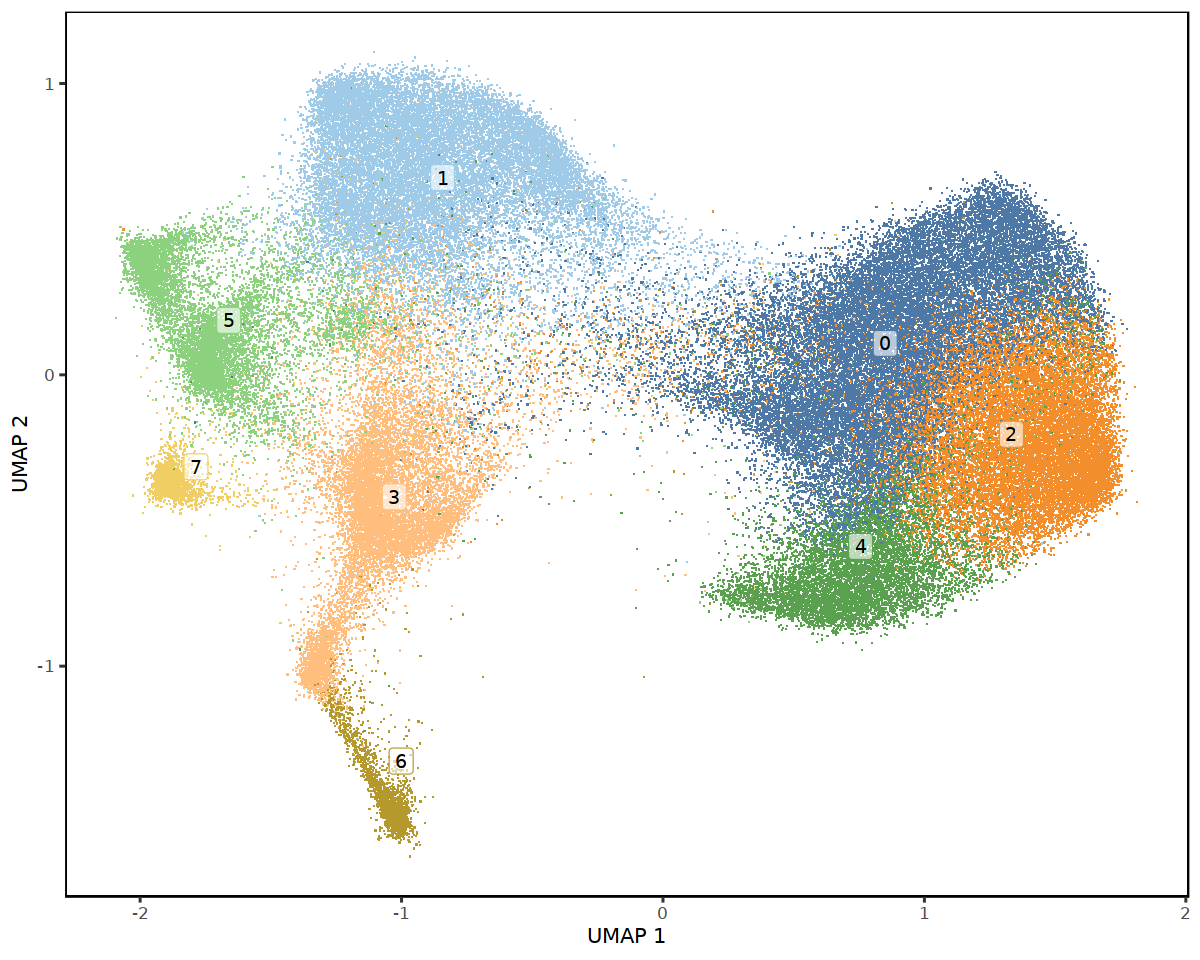

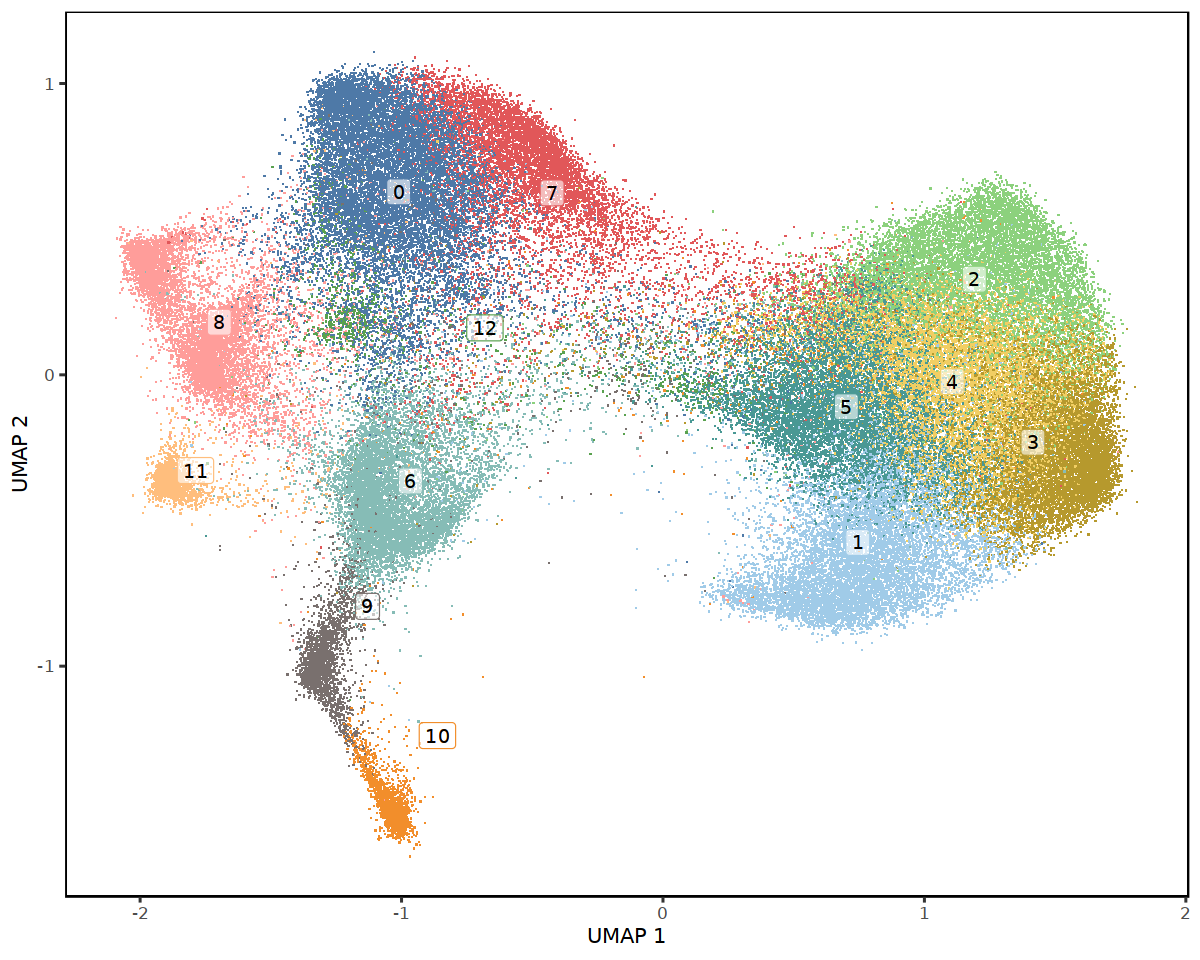

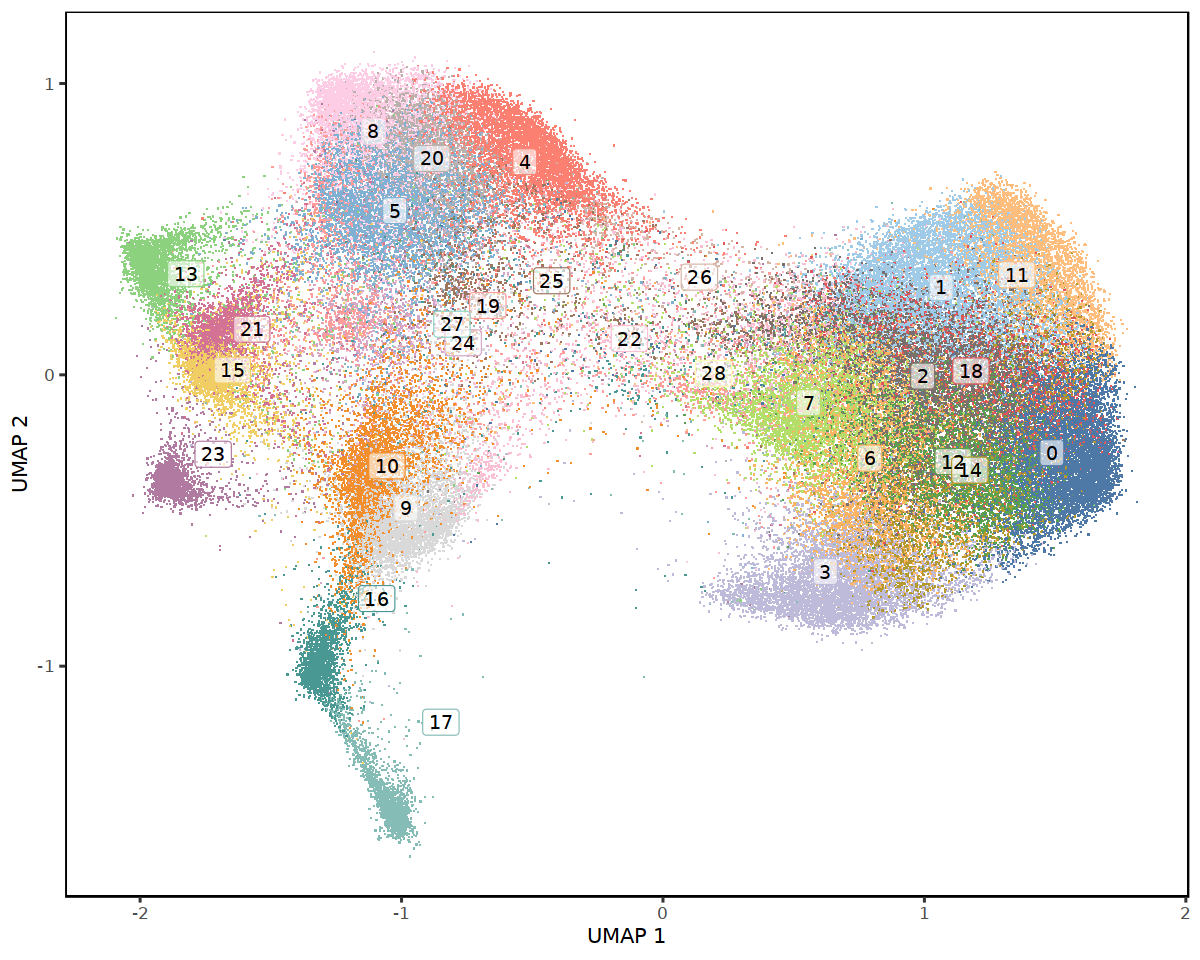

In [8]:
fig.size(8, 10)
i = sample((nrow(clusters)), 1e5)
do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust0.4') 
do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust0.6') 
do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust2.1') 
# do_scatter(U2$embedding, clusters, 'Clust2.1') 


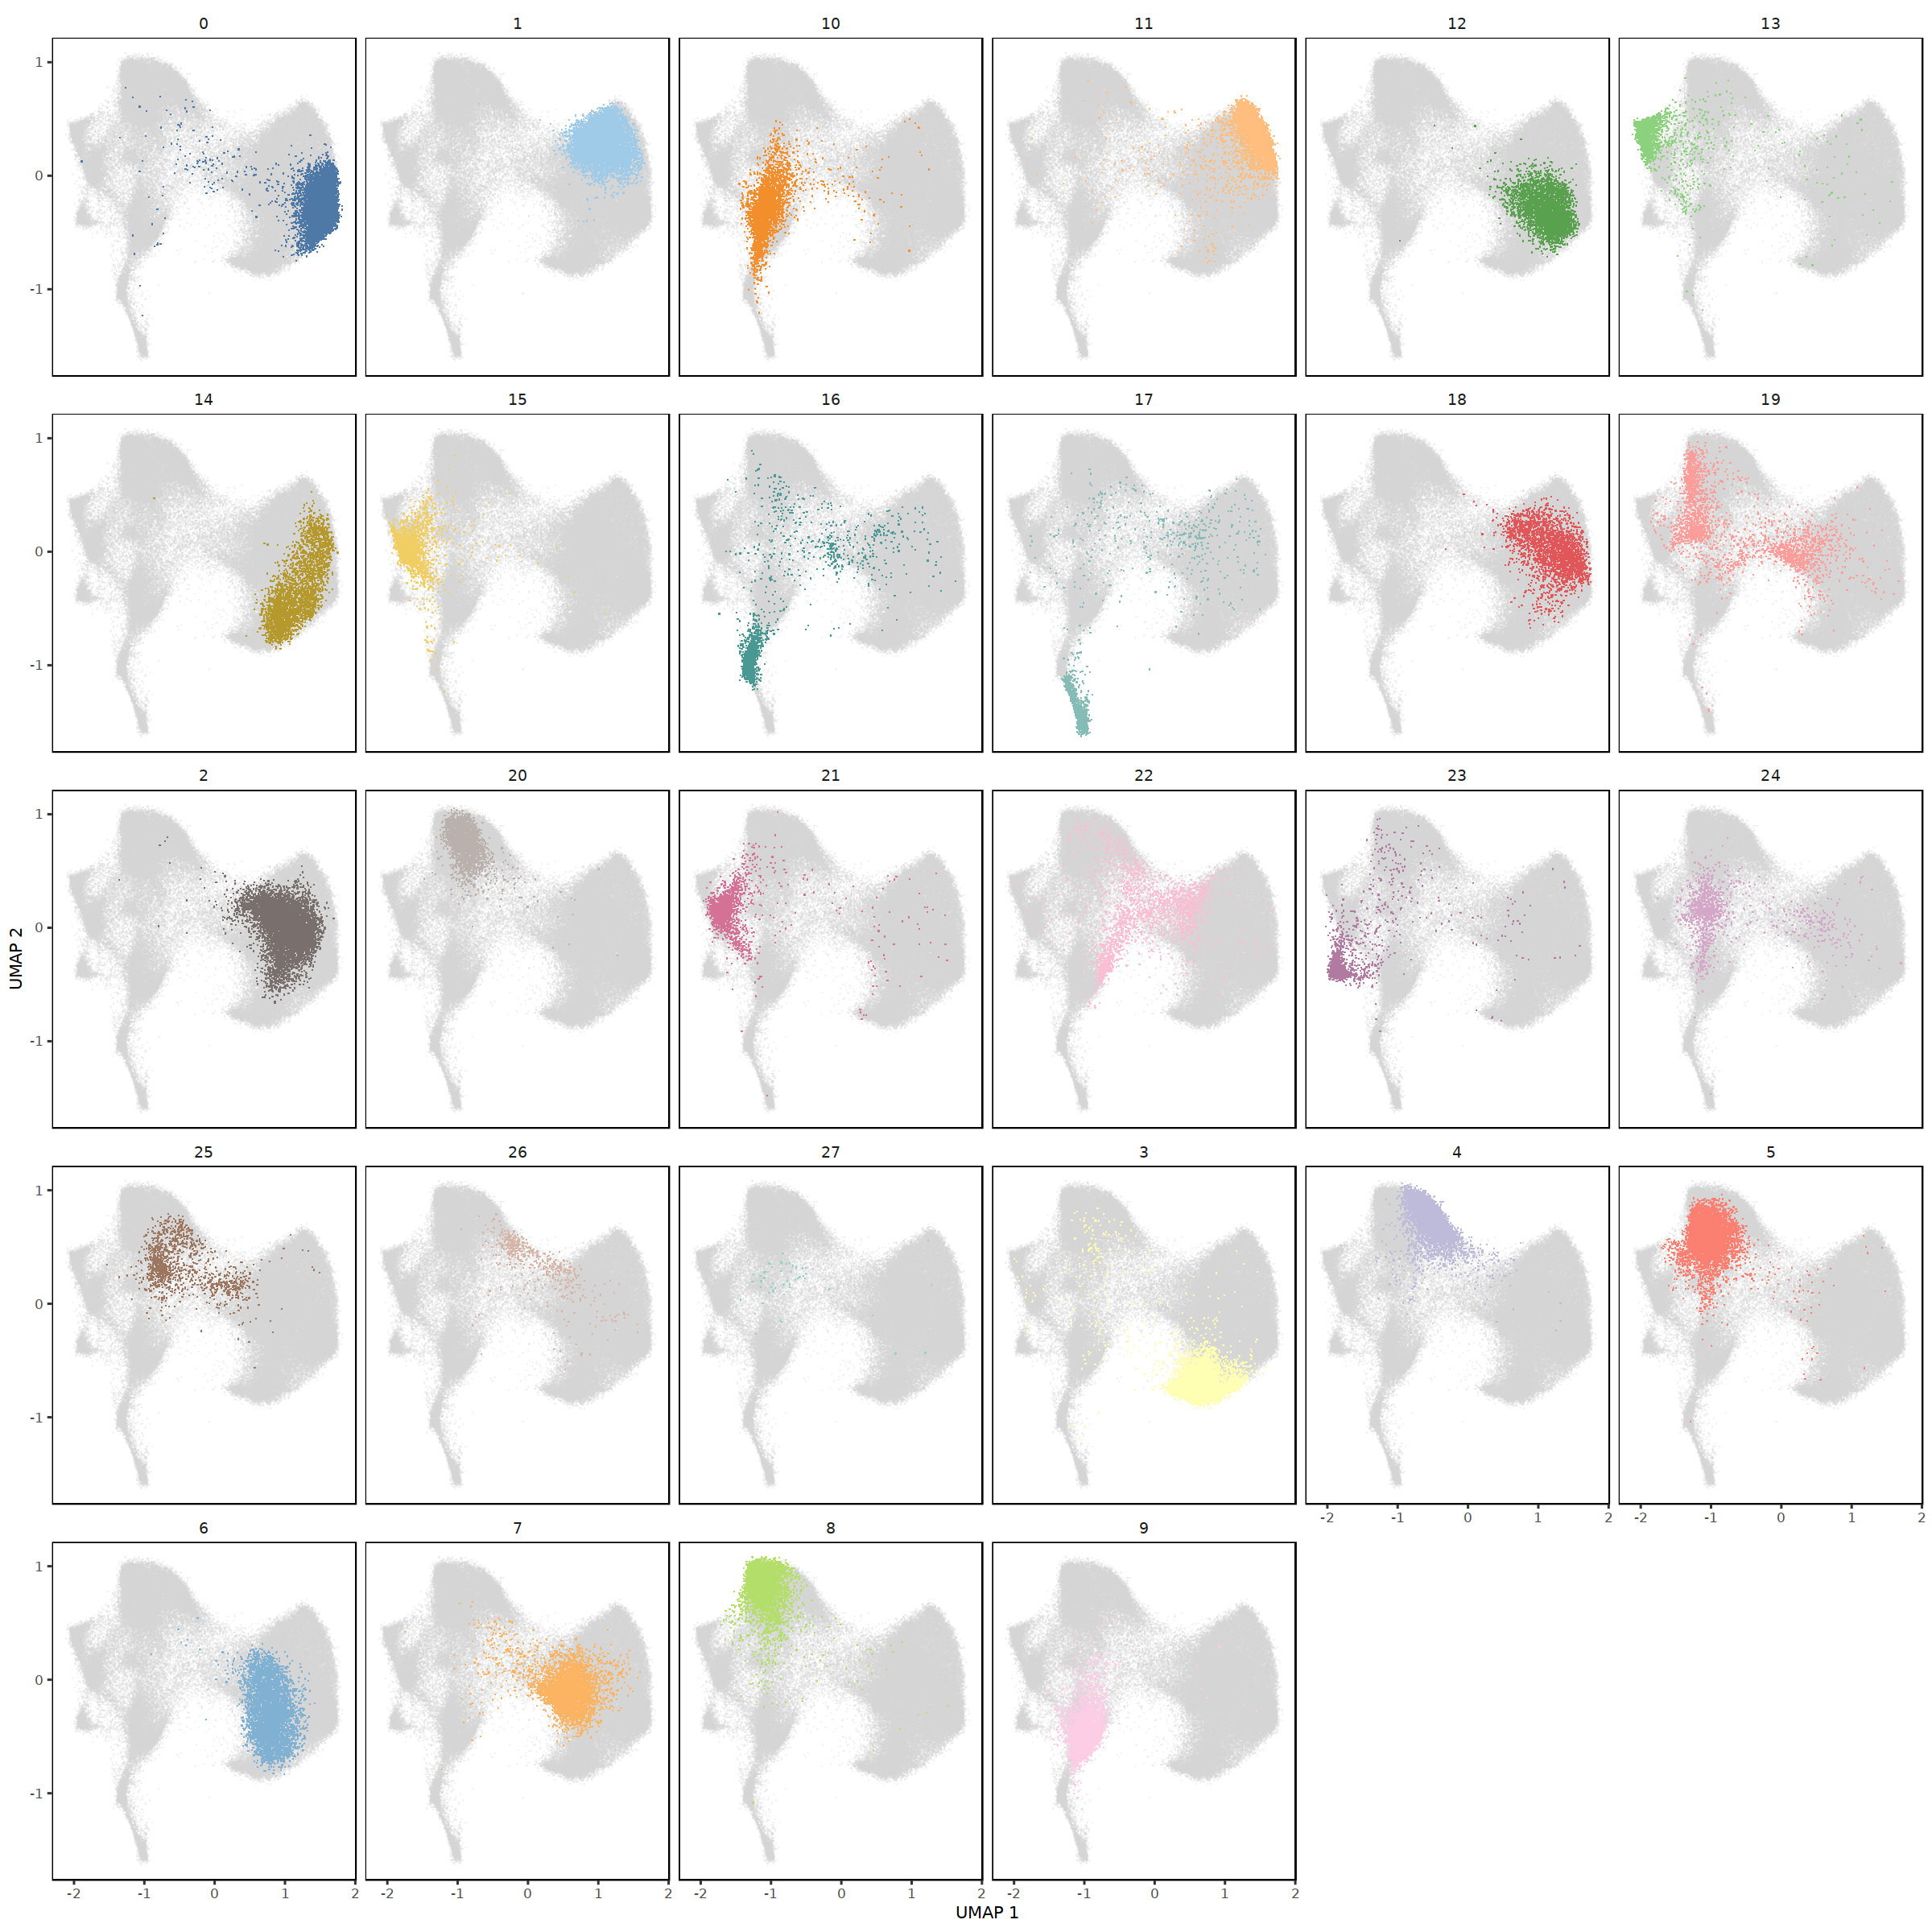

In [9]:
fig.size(20, 20)
i = sample((nrow(clusters)), 1e5)
do_scatter(U2$embedding[i, ], clusters[i, ], 'Clust2.1', quo(Clust2.1), nrow = 5, do_labels = FALSE) 
# + facet_wrap(~Clust2.1)


## Markers

In [70]:
cluster_level <- 'Clust2.1'

pb <- presto::collapse_counts(counts, cbind(meta_data, clusters), c('region', 'library', cluster_level), min_cells_per_group = 3, get_norm = TRUE)
pb$exprs_norm <- normalizeData(pb$counts_mat, 200, 'log')
markers <- wilcoxauc(pb$exprs_norm, pb$meta_data[[cluster_level]])


CAREFUL: get_norm makes very strong assumptions about data



In [11]:
# t(top_markers(markers))

In [26]:
markers %>% 
    subset(auc > .7) %>% 
    split(.$group) %>% 
    map(function(.SD) {
        .SD %>% 
            dplyr::arrange(-auc) %>% 
            # dplyr::arrange(-logFC) %>% 
            head(20) %>% 
            dplyr::select(feature, group) %>% 
            tibble::rowid_to_column('rank')
    }) %>% 
    bind_rows() %>% 
    tidyr::spread(group, feature) %>% 
    dplyr::select(-rank) %>% 
    t()


[,1]   [,2]     [,3]    [,4]     [,5]     [,6]   [,7]     [,8]     [,9]    
0  KRT8   VEGFA    RNF43   ZBTB16   SPRY4    EPHB4  LSS      TNFRSF1A BIRC3   
1  IGFBP3 LAMB3    OSMR    LCN2     MET      EFNB2  NOTCH2   HSPA5    SERPINA1
10 MMP2   VCAN     ACTA2   COL3A1   SFRP2    PDPN   IL1R1    PDGFRB   COL4A1  
11 S100A9 CCL20    CHGB    PTGS2    ICAM1    IFNGR1 ETV5     DUSP6    RNF43   
12 CKB    KRT8     HIF1A   LSS      DNAJB1   EPHB4  MET      LAMB3    CD274   
13 CCL5   ITGAE    GNLY    IL2RB    CXCR6    GZMA   EOMES    TOX      GZMK    
14 DUSP6  ETV5     PCNA    RNF43    HMGB2    ANXA1  ETV4     SMARCA4  MET     
15 IL7R   TNFRSF25 CXCR4   CCR7     CD247    CD3D   SELL     LEF1     CCR4    
16 PDGFRB S1PR3    NOTCH3  RGS5     NR2F2    TGFB3  NDUFA4L2 JAG1     COL4A1  
17 NOTCH4 VWF      KDR     PECAM1   FLT1     DLL4   COL4A1   ITGA5    S1PR1   
18 BCL6   BHLHE40  FOS     JUN      EGR1     KRT8   VEGFA    IER2     JUNB    
19 CSF2RA FSCN1    CCL22   ID2      CCR7     LST1   CSF2RB   ALOX5    IRF8    
2  MLEC   LAMP3    MET     TSPAN13  SERPINA1 ANXA1  TNFRSF1A HLA-C    SEPP1   
20 C1QC   C1QB     C1QA    CD163    HLA-DRA  CD74   MRC1     MARCO    CSF1R   
21 CTLA4  FOXP3    TRAC    IKZF2    CCR8     IL32   BATF     TNFRSF1B CD3D    
22 FOS    JUNB     EGR1    JUN      SERPINE1 IER2   BHLHE40  KLF2     NA      
23 MZB1   XBP1     CD79A   PRDM1    ISG20    PECAM1 CD38     CD19     CXCR4   
24 GBP1   CXCL10   GBP4    SOD2     IDO1     STAT1  CXCL9    CCL19    WARS    
25 CD74   HLA-DRA  VIM     HLA-DRB1 ANPEP    NA     NA       NA       NA      
26 SPP1   BCL6     MLEC    GPNMB    JUN      HIF1A  HBEGF    MET      VEGFA   
27 APOE   VIM      PDCD1   PSMB8    FZD1     NA     NA       NA       NA      
3  TOP2A  MKI67    HMGB2   PTTG1    PCNA     CDCA7  UBE2C    SMARCA4  FAS     
4  GPNMB  APOE     MSR1    C1QA     C1QB     SPP1   C1QC     CD14     MARCO   
5  LYZ    HCK      CSF3R   FCN1     LST1     ALOX5  C1QA     CSF1R    HLA-DRA 
6  PCNA   HMGB2    CKB     DNAJB1   ANXA1    EPHB4  SMARCA4  HIF1A    WARS    
7  CKB    ISG15    ALDH1B1 DNAJB1   EPHA2    IL32   ANXA1    CCND1    VIM     
8  MRC1   CD163    IL2RA   CSF1R    MERTK    FOLR2  CSF2RA   C1QC     IL18    
9  FN1    SERPINE1 COL1A2  VCAN     INHBA    COL3A1 PDGFRB   FAP      ITGA5   
   [,10]   [,11]    [,12]   [,13]   [,14]     [,15]   [,16]    [,17]   
0  DUSP6   CD274    SMAD3   SMARCA4 BCL6      IL1R1   MET      EPHA4   
1  DUSP6   NA       NA      NA      NA        NA      NA       NA      
10 VIM     FAP      TIMP1   FZD1    IL17A     GAS1    COL1A2   TGFB3   
11 NA      NA       NA      NA      NA        NA      NA       NA      
12 CEACAM1 WARS     ALOX15B ALDH1B1 ANXA1     SMARCA4 TM4SF1   OSMR    
13 HAVCR2  CCR5     CD8A    ZNF683  CST7      CD247   PRF1     LAG3    
14 EPHB4   CDCA7    TOP2A   EPHA4   ICAM1     SQLE    TNFRSF1A ADGRG6  
15 S1PR1   TRAC     CD40LG  PTPRC   CD2       TCF7    ARHGDIB  KLF2    
16 CSPG4   GJA4     THY1    ACTA2   AXL       COL3A1  COL1A2   MMP9    
17 FLT4    NOTCH1   RGS5    KLF2    IL3RA     CD34    JAG1     PDGFB   
18 MET     TNFRSF1A LAMB3   NOTCH2  OSMR      TSPAN13 DNAJB1   NA      
19 ITGAX   HCK      FLT3    IL18    CCL17     LAMP3   CSF1R    HAVCR2  
2  HIF1A   ICAM1    NOTCH2  NA      NA        NA      NA       NA      
20 ALOX5   LYZ      HCK     MSR1    CD14      MS4A4A  CD4      CCL18   
21 CCR4    CD2      IL2RA   CD4     PTPRC     IL2RB   RORA     IL18R1  
22 NA      NA       NA      NA      NA        NA      NA       NA      
23 MANF    CCR2     GAS6    CD27    TNFRSF11A DPEP1   MERTK    MS4A1   
24 TAP1    IRF1     IL32    ISG15   CD40      CXCL11  RARRES3  PDCD1LG2
25 NA      NA       NA      NA      NA        NA      NA       NA      
26 MSR1    NCAM1    HSPA5   FSCN1   PROS1     IL6R    ANXA1    WARS    
27 NA      NA       NA      NA      NA        NA      NA       NA      
3  STMN1   EBP      ARHGDIB NA      NA        NA      NA       NA      
4  CD163   MMP12    MERTK   LYZ     CCR1      FCGR3A  HC

In [70]:
markers %>% 
    # subset(feature %in% c('MS4A1')) %>% 
    # subset(feature %in% c('LAMP3')) %>% 
    # subset(feature %in% c('FOXP3')) %>% 
    # subset(feature %in% c('SPP1')) %>% 
    subset(feature %in% c('LYZ')) %>% 
    subset(auc > .7) %>% 
    arrange(-logFC)


feature group avgExpr  logFC     statistic auc       pval        
1 LYZ     5     2.758972 1.6241523 36954     0.9828191 3.983348e-25
2 LYZ     20    1.821725 0.6456484 28556     0.7977428 4.654916e-10
3 LYZ     4     1.638878 0.4554257 26134     0.7300816 1.476213e-06
  padj         pct_in    pct_out 
1 1.908024e-22 100.00000 95.63830
2 1.858087e-08 100.00000 95.64756
3 4.419414e-05  97.36842 95.75372

In [61]:
# markers %>% 
#     subset(auc > .7) %>% 
#     split(.$group) %>% 
#     # arrange(-auc) %>% 
#     # subset(auc > .7) %>% 
#     # subset(feature %in% c('CXCL13'))
#     # subset(group == '6') %>% 
#     map(arrange, -logFC) %>% 
#     map(head, 10)
#     # head(10)


In [28]:
markers %>% 
    # subset(feature %in% c('LYZ')) %>% 
    subset(feature %in% c('CXCL13')) %>% 
    # subset(feature %in% c('CCL18')) %>% 
    # subset(feature %in% c('PDCD1')) %>% 
    # subset(feature %in% c('CXCL9', 'CXCL10', 'CXCL11')) %>% 
    subset(auc > .7) %>% 
    arrange(-auc) %>% 
    head(10)


feature group avgExpr   logFC     statistic auc       pval        
1 CXCL13  21    0.6440903 0.4226478 32539.0   0.8653989 3.055147e-15
2 CXCL13  5     0.4121285 0.1808153 29286.0   0.7788830 1.735962e-09
3 CXCL13  13    0.4569955 0.2275915 29028.5   0.7720346 4.282179e-09
4 CXCL13  15    0.4575276 0.2281462 28515.0   0.7583777 2.432212e-08
5 CXCL13  24    0.4446841 0.2147562 26329.5   0.7002527 1.538211e-05
  padj         pct_in pct_out 
1 6.097565e-14 100.0  75.31915
2 3.615329e-08  97.5  75.42553
3 4.364178e-08  95.0  75.53191
4 2.008671e-07  92.5  75.63830
5 4.093350e-04  87.5  75.85106

## Label

In [ ]:
meta_data$type <- clusters %>% 
    dplyr::mutate(CLUSTER = Clust2.1) %>% 
    dplyr::mutate(type = case_when(
        CLUSTER %in% c('10') ~ 'Fibroblast:COL3A1', 
        CLUSTER %in% c('9') ~ 'Fibroblast:FN1', 
        CLUSTER %in% c('22') ~ 'Fibroblast:EGR1', 
        
        Clust0.6 %in% c('1') ~ 'Epithelial:Epithelial1', 
        Clust0.6 %in% c('2') ~ 'Epithelial:Epithelial2', 
        Clust0.6 %in% c('3') ~ 'Epithelial:Epithelial3', 
        Clust0.6 %in% c('4') ~ 'Epithelial:Epithelial4', 
        Clust0.6 %in% c('5') ~ 'Epithelial:Epithelial5', 
        # CLUSTER %in% c('') ~ 'Epithelial:IFN_Epithelial', 
        
        # CLUSTER %in% c('') ~ 'Bcell:Bcell', 
        CLUSTER %in% c('15') ~ 'Tcell:CD4', 
        CLUSTER %in% c('13') ~ 'Tcell:CD8',
        CLUSTER %in% c('21') ~ 'Tcell:Treg', 
        # CLUSTER %in% c('') ~ 'Tcell:Exhausted', 
        CLUSTER %in% c('23') ~ 'Plasma:Plasma', 
        
        CLUSTER %in% c('16') ~ 'Mural:Mural', 
        CLUSTER %in% c('17') ~ 'Endothelial:Endothelial', 
        
        CLUSTER %in% c('19') ~ 'Myeloid:LAMP3_Dendritic', 
        CLUSTER %in% c('26', '4') ~ 'Myeloid:SPP1_Macrophage', 
        # CLUSTER %in% c('') ~ 'Myeloid:LYZ_CXCL13_Macrophage', 
        CLUSTER %in% c('8', '20', '25') ~ 'Myeloid:Macrophage', ## Name it? 
        # CLUSTER %in% c('25') ~ 'Myeloid:Macrophage2', ## Name it? 
        CLUSTER %in% c('5') ~ 'Myeloid:LYZ_Macrophage', ## Name it? 
        # CLUSTER %in% c('20') ~ 'Myeloid:Macrophage3', ## Name it? 
        
        # CLUSTER %in% c('25') ~ 'Doublet:Macrophage_Fibroblast',
        # CLUSTER %in% c('24') ~ 'Doublet:Interferon'
        # CLUSTER %in% c('') ~ 'Doublet:Unknown', 
        # CLUSTER %in% c('') ~ 'Doublet:Tcell_Fibroblast'
        # CLUSTER %in% c('') ~ 'Fibroblast:COL3A1_Fibroblast', 
        # CLUSTER %in% c('') ~ 'Fibroblast:FN1_Fibroblast', 
        # CLUSTER %in% c('') ~ 'Fibroblast:EGR1_Fibroblast', 
        # CLUSTER %in% c('') ~ 'Epithelial:Epithelial1', 
        # CLUSTER %in% c('') ~ 'Epithelial:Epithelial2', 
        # CLUSTER %in% c('') ~ 'Epithelial:IFN_Epithelial', 
        # CLUSTER %in% c('') ~ 'Bcell:Bcell', 
        # CLUSTER %in% c('') ~ 'Tcell:CD4', 
        # CLUSTER %in% c('') ~ 'Tcell:CD8',
        # CLUSTER %in% c('') ~ 'Tcell:Treg', 
        # CLUSTER %in% c('') ~ 'Tcell:Exhausted', 
        # CLUSTER %in% c('') ~ 'Plasma:Plasma', 
        # CLUSTER %in% c('') ~ 'Mural:Mural', 
        # CLUSTER %in% c('') ~ 'Endothelial:Endothelial', 
        # CLUSTER %in% c('') ~ 'Myeloid:LAMP3_Dendritic', 
        # CLUSTER %in% c('') ~ 'Myeloid:SPP1_Macrophage', 
        # CLUSTER %in% c('') ~ 'Myeloid:LYZ_CXCL13_Macrophage', 
        # CLUSTER %in% c('') ~ 'Myeloid:Macrophage1', ## Name it? 
        # CLUSTER %in% c('') ~ 'Myeloid:Macrophage2', ## Name it? 
        # CLUSTER %in% c('') ~ 'Myeloid:LYZ_Macrophage', ## Name it? 
        # CLUSTER %in% c('') ~ 'Myeloid:CCL18_Macrophage', ## Name it? 
        # CLUSTER %in% c('') ~ 'Doublet:Macrophage_Fibroblast',
        # CLUSTER %in% c('') ~ 'Doublet:Interferon', 
        # CLUSTER %in% c('') ~ 'Doublet:Unknown', 
        # CLUSTER %in% c('') ~ 'Doublet:Tcell_Fibroblast'
        ## 22 
    )) %>% 
    with(type)
    # subset(is.na(type)) %>% with(sort(table(CLUSTER), TRUE))


## Refine labels

In [411]:
pb <- presto::collapse_counts(counts, cbind(meta_data, clusters), c('region', 'library', 'type'), min_cells_per_group = 3, get_norm = TRUE)
pb$exprs_norm <- normalizeData(pb$counts_mat, 200, 'log')
markers_types <- wilcoxauc(pb$exprs_norm, pb$meta_data[['type']])


CAREFUL: get_norm makes very strong assumptions about data



In [413]:
markers_types %>% 
    subset(feature == 'TCF7') %>% 
    arrange(-auc)


feature group                   avgExpr    logFC         statistic auc      
1  TCF7    Tcell:CD4               0.30410721  0.2647830350 25509.0   0.9097361
2  TCF7    Tcell:TCF7_CD8          0.11571532  0.0655477533 17696.5   0.6463767
3  TCF7    Tcell:CD8               0.05678283  0.0033412348 15576.5   0.5689422
4  TCF7    Fibroblast:FN1          0.05374009  0.0001296323 15570.0   0.5552782
5  TCF7    Mural:Mural             0.05412225  0.0005336034 15423.0   0.5500357
6  TCF7    Myeloid:LAMP3_Dendritic 0.03835234 -0.0161361651 15369.5   0.5481277
7  TCF7    Tcell:Treg              0.05555539  0.0020485167 15015.0   0.5354850
8  TCF7    Plasma:Plasma           0.04961368 -0.0042262086 14496.0   0.5294762
9  TCF7    Myeloid:LYZ_Macrophage  0.03371753 -0.0210354386 14622.0   0.5214693
10 TCF7    Myeloid:Macrophage      0.03587063 -0.0187594761 14557.0   0.5191512
11 TCF7    Endothelial:Endothelial 0.02343333 -0.0319064725 12735.0   0.4541726
12 TCF7    Fibroblast:COL3A1       0.02753929 -0.0275662145 12476.0   0.4449358
13 TCF7    Myeloid:SPP1_Macrophage 0.03172875 -0.0230718801 11549.0   0.4323201
14 TCF7    Epithelial:Epithelial3  0.02644616 -0.0285993313 11033.0   0.4235642
15 TCF7    Fibroblast:EGR1         0.03990306 -0.0144351827 11003.5   0.4224317
16 TCF7    Epithelial:Epithelial1  0.02263849 -0.0327466609 11119.0   0.3965407
17 TCF7    Epithelial:Epithelial5  0.01171368 -0.0441688430  9452.0   0.3538220
18 TCF7    Epithelial:Epithelial4  0.01399257 -0.0417074367  8619.0   0.3308891
19 TCF7    Epithelial:Epithelial2  0.01301759 -0.0427336614  8256.0   0.3169533
   pval         padj         pct_in   pct_out 
1  9.430748e-20 3.764440e-18 92.50000 54.92154
2  1.325400e-03 6.682807e-03 66.66667 56.41026
3  1.305667e-01 3.417565e-01 66.66667 56.41026
4  2.199270e-01 4.302328e-01 67.50000 56.34807
5  2.668508e-01 4.935194e-01 65.00000 56.49073
6  2.855256e-01 5.301038e-01 67.50000 56.34807
7  4.310859e-01 6.660972e-01 57.50000 56.91869
8  5.181689e-01 8.013583e-01 64.10256 56.55271
9  6.339312e-01 8.011953e-01 65.00000 56.49073
10 6.710253e-01 8.241567e-01 67.50000 56.34807
11 3.091892e-01 4.701734e-01 52.50000 57.20399
12 2.217181e-01 4.385483e-01 55.00000 57.06134
13 1.426312e-01 2.858592e-01 47.36842 57.46799
14 1.020483e-01 1.817143e-01 48.64865 57.38636
15 9.706846e-02 1.678548e-01 40.54054 57.81250
16 2.165905e-02 1.220551e-01 45.00000 57.63195
17 1.540527e-03 6.286941e-03 39.47368 57.89474
18 2.970359e-04 1.094463e-03 35.13514 58.09659
19 9.001499e-05 5.599634e-04 32.43243 58.23864

In [106]:
# writeLines(unique(pb$meta_data$type))
types_macro <- grep('Macrophage', unique(pb$meta_data$type), value = TRUE)
types_epithelial <- grep('Epithelial', unique(pb$meta_data$type), value = TRUE)
markers_macrophage <- wilcoxauc(pb$exprs_norm, pb$meta_data[['type']], groups_use = types_macro)
markers_epithelial <- wilcoxauc(pb$exprs_norm, pb$meta_data[['type']], groups_use = types_epithelial)


In [ ]:
top_markers(markers_macrophage)

rank Myeloid:LYZ_Macrophage Myeloid:Macrophage Myeloid:SPP1_Macrophage
1   1   HCK                    IL2RA              GPNMB                  
2   2   FCN1                   CD163              MSR1                   
3   3   LYZ                    MRC1               SPP1                   
4   4   LST1                   CSF2RA             VIM                    
5   5   CSF3R                  MERTK              APOE                   
6   6   ARHGDIB                RBPJ               MMP12                  
7   7   S100A9                 CSF1R              ITGA5                  
8   8   CXCL13                 FOLR2              DNAJB1                 
9   9   GBP4                   PLTP               JUN                    
10 10   CD69                   IL18               PROS1

In [108]:
top_markers(markers_epithelial)

rank Epithelial:Epithelial1 Epithelial:Epithelial2 Epithelial:Epithelial3
1   1   TOP2A                  S100A9                 KRT8                  
2   2   MKI67                  LCN2                   VEGFA                 
3   3   HMGB2                  CCL20                  ZBTB16                
4   4   PCNA                   IGFBP3                 SPRY4                 
5   5   PTTG1                  PTGS2                  BIRC3                 
6   6   CDCA7                  CHGB                   FN1                   
7   7   UBE2C                  IFNGR1                 TNFRSF25              
8   8   ARHGDIB                HEY1                   IL18                  
9   9   ITGAE                  LAMB3                  ANPEP                 
10 10   STMN1                  ITGA1                  LSS                   
   Epithelial:Epithelial4 Epithelial:Epithelial5
1  MLEC                   ISG15                 
2  SEPP1                  ALDH1B1               
3  TSPAN13                CKB                   
4  LAMP3                  DNAJB1                
5  MET                    IL32                  
6  SERPINA1               EPHA2                 
7  TNFRSF1A               VIM                   
8  CCL28                  FSCN1                 
9  PLTP                   IFNGR2                
10 PERP                   NT5E

## Differential abundance

### Total

In [255]:
# df <- meta_data %>% 
#     st_drop_geometry() %>% 
#     with(prop.table(table(region, type), 1)) %>% 
#     data.table() %>% 
#     left_join(
#         unique(dplyr::select(st_drop_geometry(meta_data), region, region_type, library))
#     )
# df$region_type <- factor(df$region_type, c('tumor', 'hub'))
# res = df[, broom::tidy(lm(N ~ 1 + region_type + library)), by = type][term == 'region_typehub'][order(-statistic)]
# res[p.value < .01] %>% split(.$estimate < 0)


Joining, by = "region"


$`FALSE`
                      type           term   estimate   std.error statistic
1:              Tcell:Treg region_typehub 0.04828308 0.006602837  7.312475
2:               Tcell:CD4 region_typehub 0.14161311 0.022439745  6.310816
3:           Plasma:Plasma region_typehub 0.07735509 0.013501157  5.729516
4:             Mural:Mural region_typehub 0.02347569 0.004959956  4.733045
5: Endothelial:Endothelial region_typehub 0.02851569 0.006666350  4.277556
6:               Tcell:CD8 region_typehub 0.03977290 0.009342053  4.257405
7: Myeloid:LAMP3_Dendritic region_typehub 0.03953654 0.010690706  3.698217
        p.value
1: 1.516425e-08
2: 3.014281e-07
3: 1.754826e-06
4: 3.583757e-05
5: 1.388604e-04
6: 1.473393e-04
7: 7.401153e-04

$`TRUE`
                      type           term    estimate   std.error  statistic
1:         Fibroblast:EGR1 region_typehub -0.01330283 0.004383097  -3.035031
2:  Epithelial:Epithelial1 region_typehub -0.07655975 0.015714656  -4.871869
3: Myeloid:SPP1_Macrophage region_typehub -0.05418048 0.008403753  -6.447177
4:  Epithelial:Epithelial5 region_typehub -0.06978595 0.010152681  -6.873648
5:  Epithelial:Epithelial2 region_typehub -0.07115296 0.009773167  -7.280440
6:  Epithelial:Epithelial4 region_typehub -0.09540357 0.012263879  -7.779233
7:  Epithelial:Epithelial3 region_typehub -0.08497141 0.006121583 -13.880628
        p.value
1: 4.516530e-03
2: 2.361113e-05
3: 1.998036e-07
4: 5.564738e-08
5: 1.666402e-08
6: 3.883053e-09
7: 8.496105e-16

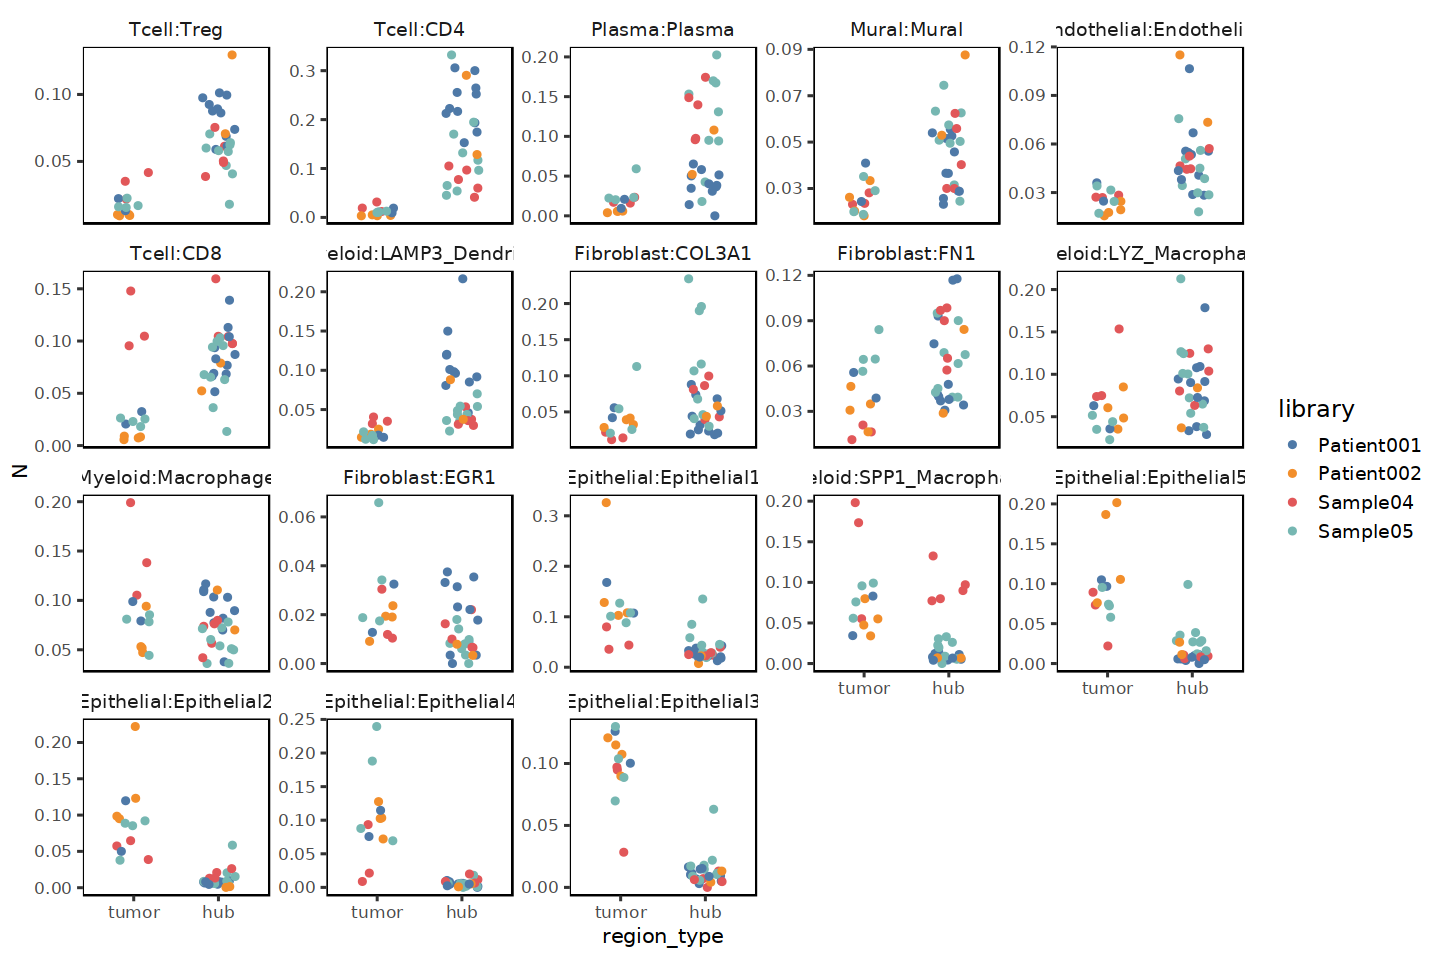

In [256]:
fig.size(8, 12)
df %>% 
    dplyr::mutate(type = factor(type, res$`type`)) %>%  ## order by significance 
    ggplot(aes(region_type, N, color = library)) + 
        geom_jitter(width = .2, height = 0) + 
        facet_wrap(~type, scales = 'free_y') + 
        scale_color_tableau() + 
        NULL


### Within immune cells

In [257]:
unique(meta_data$type)

[1] "Epithelial:Epithelial4"  "Epithelial:Epithelial3" 
 [3] "Epithelial:Epithelial1"  "Epithelial:Epithelial5" 
 [5] "Myeloid:Macrophage"      "Fibroblast:FN1"         
 [7] "Fibroblast:COL3A1"       "Myeloid:LAMP3_Dendritic"
 [9] "Epithelial:Epithelial2"  "Tcell:CD8"              
[11] "Mural:Mural"             "Endothelial:Endothelial"
[13] "Tcell:CD4"               "Tcell:Treg"             
[15] "Myeloid:LYZ_Macrophage"  NA                       
[17] "Myeloid:SPP1_Macrophage" "Fibroblast:EGR1"        
[19] "Plasma:Plasma"

In [258]:
df <- meta_data %>% 
    subset(region != 'R29') %>% 
    st_drop_geometry() %>% 
    # subset(Clust2.1 %in% c('8', '4', '5', '20')) %>% 
    subset(grepl('Macrophage', type)) %>% 
    # subset(grepl('Myeloid', type)) %>% 
    # subset(grepl('Myeloid|Tcell|Plasma', type)) %>% 
    with(prop.table(table(region, type), 1)) %>% 
    data.table() %>% 
    left_join(
        unique(dplyr::select(st_drop_geometry(meta_data), region, region_type, library))
    )
df$region_type <- factor(df$region_type, c('tumor', 'hub'))
res = df[, broom::tidy(lm(N ~ 1 + region_type + library)), by = type][term == 'region_typehub'][order(-statistic)]
res[p.value < .01] %>% split(.$estimate < 0)


Joining, by = "region"


$`FALSE`
                     type           term estimate  std.error statistic
1: Myeloid:LYZ_Macrophage region_typehub 0.216554 0.04508398  4.803347
       p.value
1: 3.08522e-05

$`TRUE`
                      type           term   estimate  std.error statistic
1: Myeloid:SPP1_Macrophage region_typehub -0.2367895 0.03400998 -6.962353
        p.value
1: 4.989135e-08

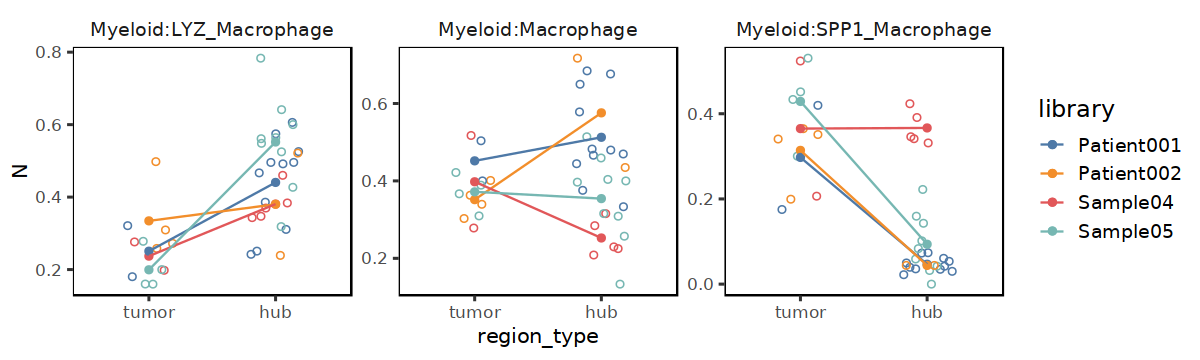

In [259]:
fig.size(3, 10)
df %>% 
    dplyr::mutate(type = factor(type, res$`type`)) %>%  ## order by significance 
    ggplot(aes(region_type, N, color = library)) + 
        geom_jitter(width = .2, height = 0, shape = 21) + 
        geom_point(
            data = df[, .(N = mean(N)), by = .(region_type, library, type)], 
            size = 2, 
            shape = 16
        ) + 
        geom_line(
            data = df[, .(N = mean(N)), by = .(region_type, library, type)], 
            aes(group = library)
        ) + 
        facet_wrap(~type, scales = 'free_y', nrow = 1) + 
        scale_color_tableau() + 
        NULL


### Within T cells

#### Subcluster

In [122]:
i = which(clusters$`Clust2.1` %in% c('13', '15', '21'))

X <- U2$fgraph[i, i]
diag(X) <- 1
snn_t <- X %*% X
# snn@x[which(snn@x < quantile(snn@x, .01))] <- 0
# snn <- Matrix::drop0(snn)
snn_t <- snn_t + t(snn_t)

plan(multicore)
system.time({
    clusters_t <- RunModularityClustering(snn_t, resolution = c(.1, .2, .4, .6, .8, 1.2, 1.5))
    # clusters_t <- RunModularityClustering(U2$fgraph[i, i], resolution = c(.1, .2, .4, .6, .8, 1.2, 1.5))
    clusters_t <- map(clusters_t, function(x) x = factor(x, unique(as.integer(x)))) %>% bind_cols()     
})


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 75249
Number of edges: 12795189

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9094
Number of communities: 2
Elapsed time: 69 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 75249
Number of edges: 12795189

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8581
Number of communities: 2
Elapsed time: 71 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 75249
Number of edges: 12795189

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7845
Number of communities: 3
Elapsed time: 84 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 75249
Number of edges: 12795189

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7160
Number of communities: 3
Elapsed time: 113 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 75249
Number of edges: 12795189

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6589
Number of communities: 6
Elapsed time: 102 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 75249
Number of edges: 12795189

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5917
Number of communities: 11
Elapsed time: 109 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 75249
Number of edges: 12795189

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5598
Number of communities: 15
Elapsed time: 110 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`


   user  system elapsed 
668.295  25.504 140.190 

In [123]:
map(map(clusters_t, table), length)

$Clust0.1
[1] 2

$Clust0.2
[1] 2

$Clust0.4
[1] 3

$Clust0.6
[1] 3

$Clust0.8
[1] 6

$Clust1.2
[1] 11

$Clust1.5
[1] 15

In [124]:
cluster_level <- 'Clust1.2'
pb <- presto::collapse_counts(counts[, i], cbind(meta_data[i, ], clusters_t), c('region', 'library', cluster_level), min_cells_per_group = 3, get_norm = TRUE)
pb$exprs_norm <- normalizeData(pb$counts_mat, 200, 'log')
markers_t <- wilcoxauc(pb$exprs_norm, pb$meta_data[[cluster_level]])


CAREFUL: get_norm makes very strong assumptions about data



In [125]:
table(clusters$`Clust2.1`[i], clusters_t[[cluster_level]])

    
         9     5     0     1     4     2     6     3     8     7    10
  13  4682  5878     8    99    24  8365    52  8197  2565    57    37
  15    58    35 13733    25  2926    30  4504    24  2247   713   655
  21    16    24     3  9651  3180    12  1215    79    63  4391  1701

In [132]:
markers_t %>% 
    subset(auc > .7) %>% 
    subset(feature %in% 'GNLY') %>% 
    # subset(feature %in% 'CD8A') %>% 
    # subset(feature %in% 'CD3D') %>% 
    # subset(feature %in% 'MKI67') %>% 
    arrange(-auc)


feature group avgExpr   logFC     statistic auc       pval        
1 GNLY    5     1.2804901 0.9987308 13556.5   0.9052150 6.935927e-18
2 GNLY    2     0.8699376 0.5464815 11879.0   0.7932025 4.544573e-10
3 GNLY    8     0.7429518 0.4055427 11036.5   0.7543746 9.013666e-08
  padj         pct_in   pct_out 
1 1.661155e-15 97.43590 56.51042
2 2.418723e-08 92.30769 57.03125
3 4.317546e-06 89.47368 57.40260

In [130]:
top_markers(markers_t)

rank 0        1        10      2       3      4        5        6     
1   1   IL7R     CTLA4    HMGB2   CD74    CXCL10 CCR4     ITGAE    COL4A1
2   2   CCR7     FOXP3    MKI67   HLA-DRA CCL5   TNFRSF25 GNLY     PDGFRB
3   3   S1PR1    BATF     PCNA    CD163   CCL4   TRAC     CCL5     COL3A1
4   4   KLF2     TNFRSF1B TOP2A   C1QC    GBP1   BIRC3    VCAN     RGS5  
5   5   CXCR4    IKZF2    ARHGDIB ITGAE   CST7   IL18R1   ZNF683   NOTCH3
6   6   LEF1     CCR8     TRAC    C1QB    LAG3   IL32     COL3A1   S1PR3 
7   7   TNFRSF25 IL32     CCR4    GNLY    HAVCR2 STING1   SERPINE1 ACTA2 
8   8   TCF7     CSF1     BATF    C1QA    CXCR6  BATF     PDGFRB   VCAN  
9   9   SELL     TNFRSF9  PTTG1   CSF1R   GZMA   IKZF2    COL4A1   MMP2  
10 10   CD40LG   IL2RA    CDCA7   CD14    CD8A   SELL     TIMP1    TGFB3 
   7       8      9      
1  C1QC    CXCR4  HMGB2  
2  CD74    CD247  MKI67  
3  IL2RA   GZMK   TOP2A  
4  CD163   CD3E   ITGAE  
5  HLA-DRA IL7R   PCNA   
6  HCK     ISG20  GZMA   
7  C1QA    HLA-E  CCL5   
8  LYZ     CD69   LAG3   
9  C1QB    TGFBR2 SMARCA4
10 MRC1    GNLY   CD8A

In [90]:
# .m <- meta_data %>% cbind(CLUSTER = clusters$`Clust2.1`)
# .m$CLUSTER[i] <- paste0('T-', clusters_t$`Clust1.2`)


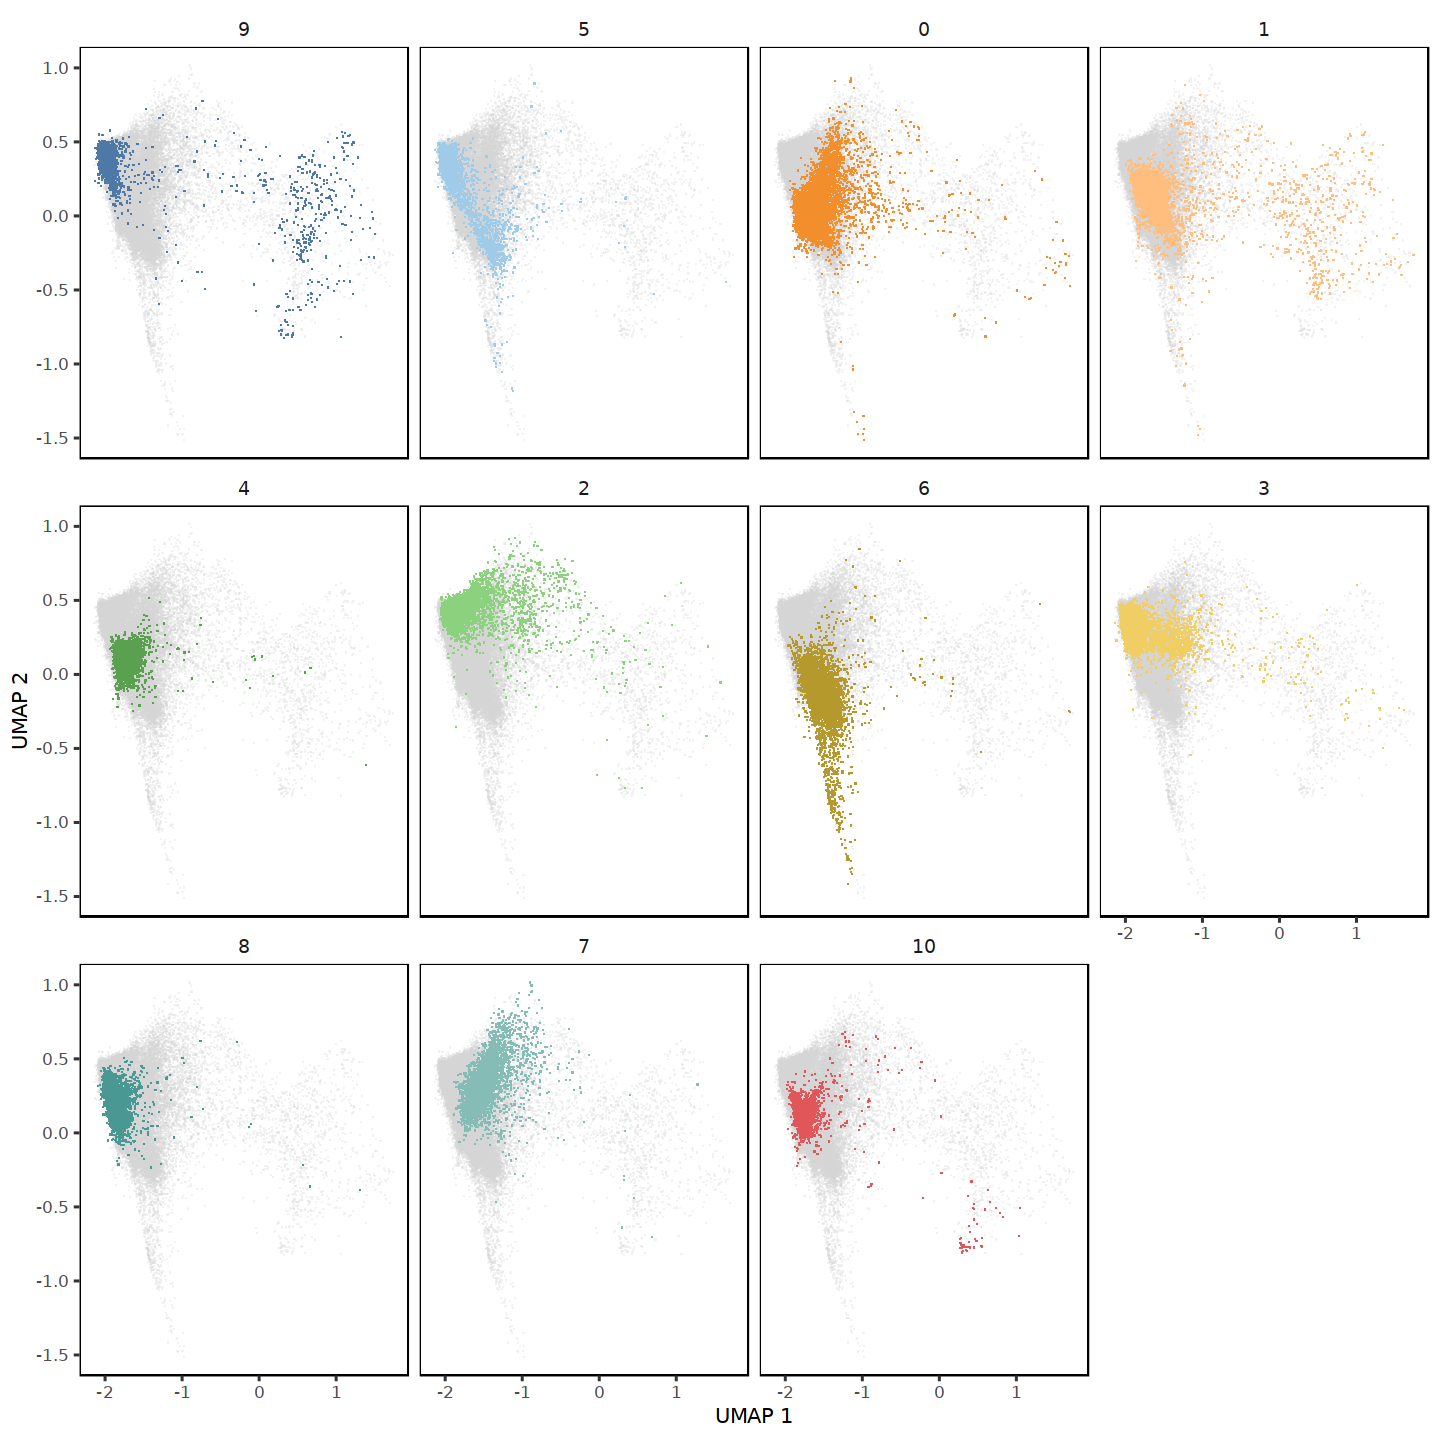

In [131]:
fig.size(12, 12)
do_scatter(U2$embedding[i, ], clusters_t, cluster_level, quo(Clust1.2), nrow = 3, do_labels = FALSE) 


In [185]:
markers_t %>% 
    subset(feature %in% c('IFNG')) %>% 
    arrange(-auc)


feature group avgExpr     logFC         statistic auc       pval        
1  IFNG    3     0.053073513  0.0369760628 9438.0    0.6451128 0.0001106264
2  IFNG    1     0.045121882  0.0282395953 8514.5    0.5819891 0.0289685961
3  IFNG    2     0.019639488  0.0002426863 8159.0    0.5448050 0.2273978593
4  IFNG    0     0.029926952  0.0115749705 7953.5    0.5310831 0.4025188840
5  IFNG    5     0.017642587 -0.0019570245 7604.0    0.5077457 0.8352816239
6  IFNG    9     0.018188821 -0.0013517934 7272.5    0.4970950 0.9390207354
7  IFNG    7     0.005885671 -0.0149080023 6926.5    0.4625067 0.3125153366
8  IFNG    8     0.009747008 -0.0106268251 6764.5    0.4623718 0.3164424977
9  IFNG    4     0.007619088 -0.0130324748 6750.0    0.4406005 0.1054754117
10 IFNG    10    0.006105387 -0.0145899821 5999.5    0.4200742 0.0354275627
11 IFNG    6     0.001051824 -0.0201802351 5946.0    0.4064252 0.0126794227
   padj        pct_in   pct_out 
1  0.001462552 47.36842 23.11688
2  0.137815228 39.47368 23.89610
3  0.477677074 33.33333 24.47917
4  0.557244351 30.76923 24.73958
5  0.933110873 28.20513 25.00000
6  0.961091736 23.68421 25.45455
7  0.573049370 20.51282 25.78125
8  0.628945877 18.42105 25.97403
9  0.379870092 15.00000 26.37076
10 0.134680972 10.81081 26.68394
11 0.065305844 10.52632 26.75325

#### Abundance

In [177]:
df <- meta_data[i, ] %>% 
    st_drop_geometry() %>% 
    cbind(clusters_t) %>% 
    with(prop.table(table(region, Clust1.2), 1)) %>% 
    data.table() %>% 
    left_join(
        unique(dplyr::select(st_drop_geometry(meta_data[i, ]), region, region_type, library))
    )
df$region_type <- factor(df$region_type, c('tumor', 'hub'))
res = df[, broom::tidy(lm(N ~ 1 + region_type + library)), by = Clust1.2][term == 'region_typehub'][order(-statistic)]
res[p.value < .01] %>% split(.$estimate < 0)


Joining, by = "region"


$`FALSE`
   Clust1.2           term   estimate   std.error statistic      p.value
1:        0 region_typehub 0.16261723 0.026360810  6.168901 4.628903e-07
2:        8 region_typehub 0.04732070 0.008107736  5.836488 1.268073e-06
3:        4 region_typehub 0.05832743 0.010579868  5.513058 3.387158e-06
4:        6 region_typehub 0.04566720 0.014353406  3.181628 3.065716e-03

$`TRUE`
   Clust1.2           term    estimate   std.error statistic      p.value
1:        7 region_typehub -0.02925375 0.009843030 -2.972027 5.321751e-03
2:        3 region_typehub -0.03521383 0.008122206 -4.335501 1.170603e-04
3:        1 region_typehub -0.07302548 0.013173808 -5.543232 3.090474e-06
4:        2 region_typehub -0.09692000 0.015101901 -6.417735 2.183346e-07
5:        9 region_typehub -0.05601748 0.006516814 -8.595839 3.798515e-10

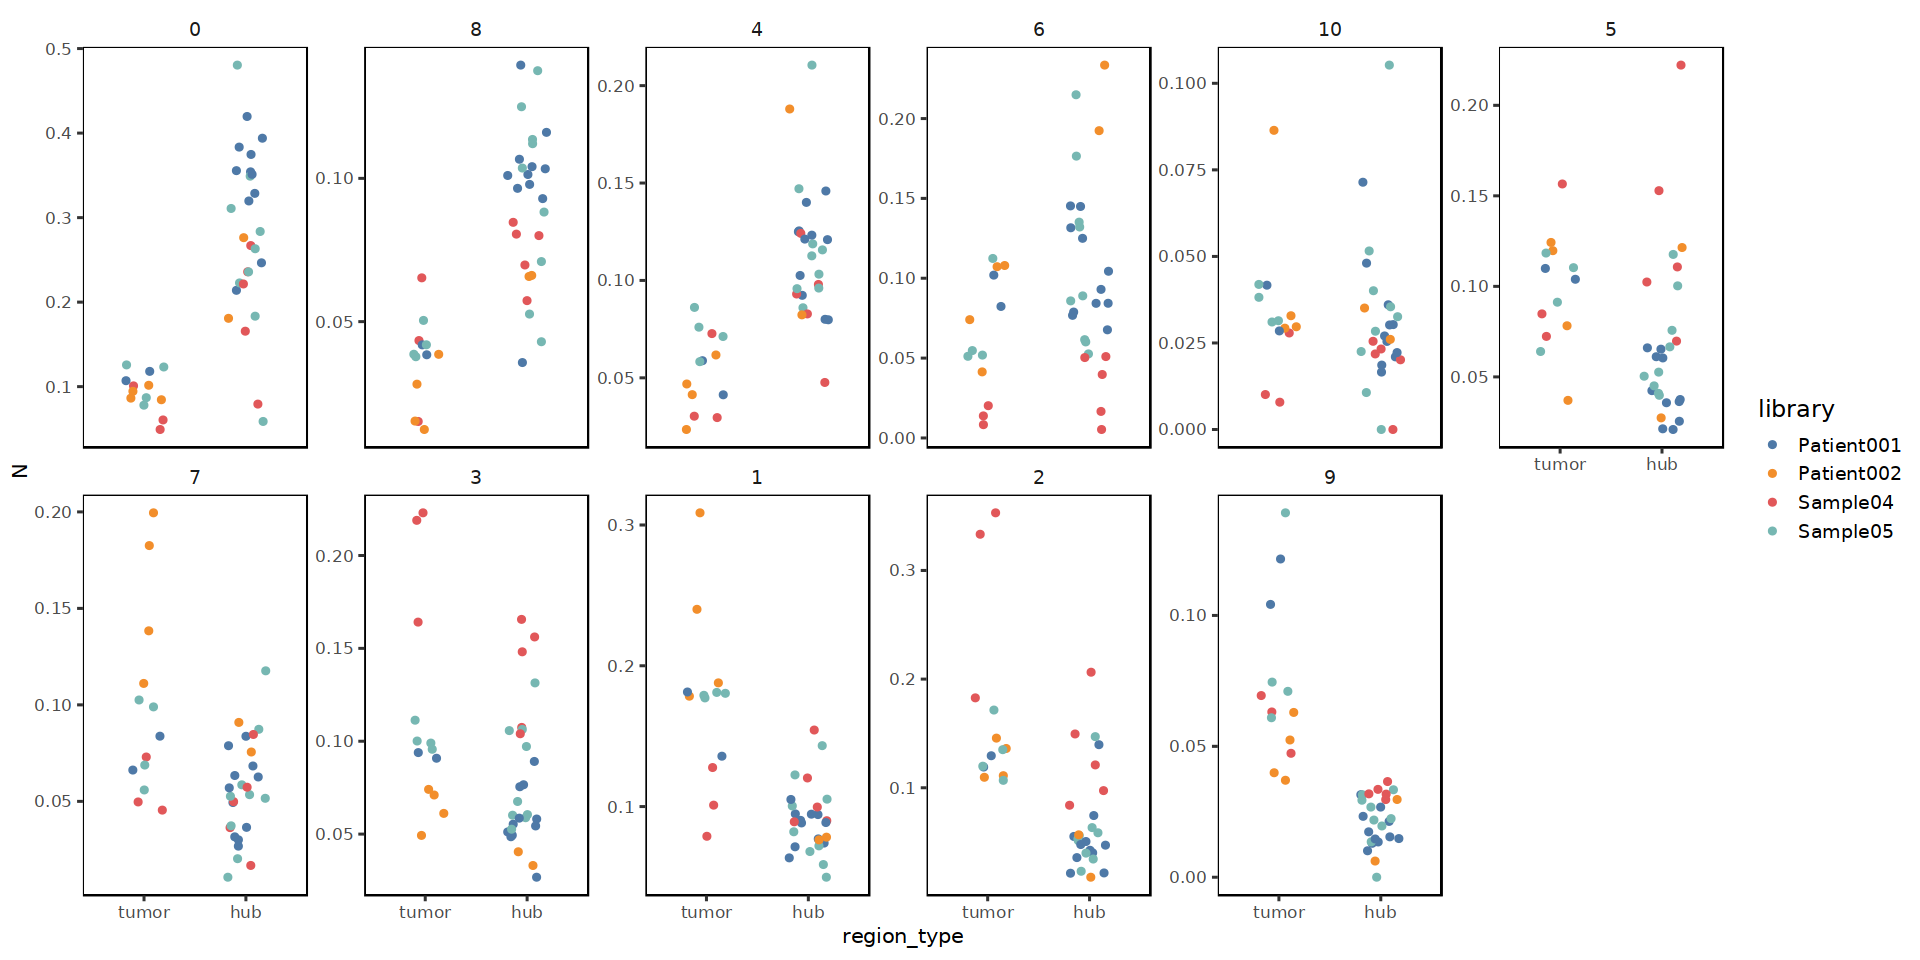

In [180]:
fig.size(8, 16)
df %>% 
    dplyr::mutate(Clust1.2 = factor(Clust1.2, res$`Clust1.2`)) %>%  ## order by significance 
    ggplot(aes(region_type, N, color = library)) + 
        geom_jitter(width = .2, height = 0) + 
        facet_wrap(~Clust1.2, scales = 'free_y', nrow = 2) + 
        scale_color_tableau() + 
        NULL


## (extra) Double check tumor vs hub 

In [155]:
pb <- presto::collapse_counts(counts, meta_data, c('region', 'region_type', 'library'), min_cells_per_group = 3, get_norm = TRUE)


CAREFUL: get_norm makes very strong assumptions about data



In [163]:
sort(colSums(pb$exprs_norm))

sample_312 sample_220 sample_311 sample_259 sample_147 sample_310 sample_258 
  866.3437   866.8748   871.8026   876.9669   878.1088   878.2962   884.5768 
sample_221 sample_144 sample_145 sample_314 sample_171 sample_254 sample_223 
  889.0545   901.8006   904.4428   908.7773   909.0005   909.3023   913.3211 
sample_146 sample_193 sample_250 sample_160 sample_253 sample_256 sample_255 
  922.4289   924.2386   928.1962   929.2382   929.7853   931.7947   937.2784 
  sample_7 sample_195 sample_182 sample_257   sample_9  sample_68 sample_252 
  940.6357   941.1145   942.0023   943.1230   943.4229   944.4656   946.4774 
  sample_4   sample_8  sample_69   sample_5  sample_38  sample_39   sample_2 
  961.1444   966.1493   969.8586   969.9723   973.2542   974.8668   978.7747 
  sample_3   sample_6   sample_1 sample_117 sample_116 
  979.3979   981.3261   983.7243  1004.5373  1006.9788

In [166]:
colSums(pb$exprs_norm[c('CXCL10', 'CXCL9', 'CXCL11'), ])

sample_68  sample_39   sample_5  sample_69   sample_1   sample_2   sample_3 
  4.970112   7.041695   8.530739   6.797312   8.342923   7.516568   7.060469 
 sample_38   sample_9   sample_6   sample_8   sample_7   sample_4 sample_145 
  8.411591  10.154968   8.595488   9.190983   7.637297   6.464040   2.659537 
sample_144 sample_116 sample_146 sample_147 sample_117 sample_223 sample_182 
  2.331065   5.864276   3.125230   2.229036   4.897924   7.712566   8.885905 
sample_193 sample_171 sample_220 sample_221 sample_195 sample_160 sample_312 
  9.837577   8.331306   8.932287  10.555203   7.828191   8.864074   6.290588 
sample_253 sample_311 sample_256 sample_250 sample_257 sample_258 sample_314 
  8.510184   6.239803   9.518285   9.880094   8.763140   6.611106   7.286856 
sample_259 sample_252 sample_310 sample_255 sample_254 
  9.397241   9.102047   5.281799   7.429748   9.184108

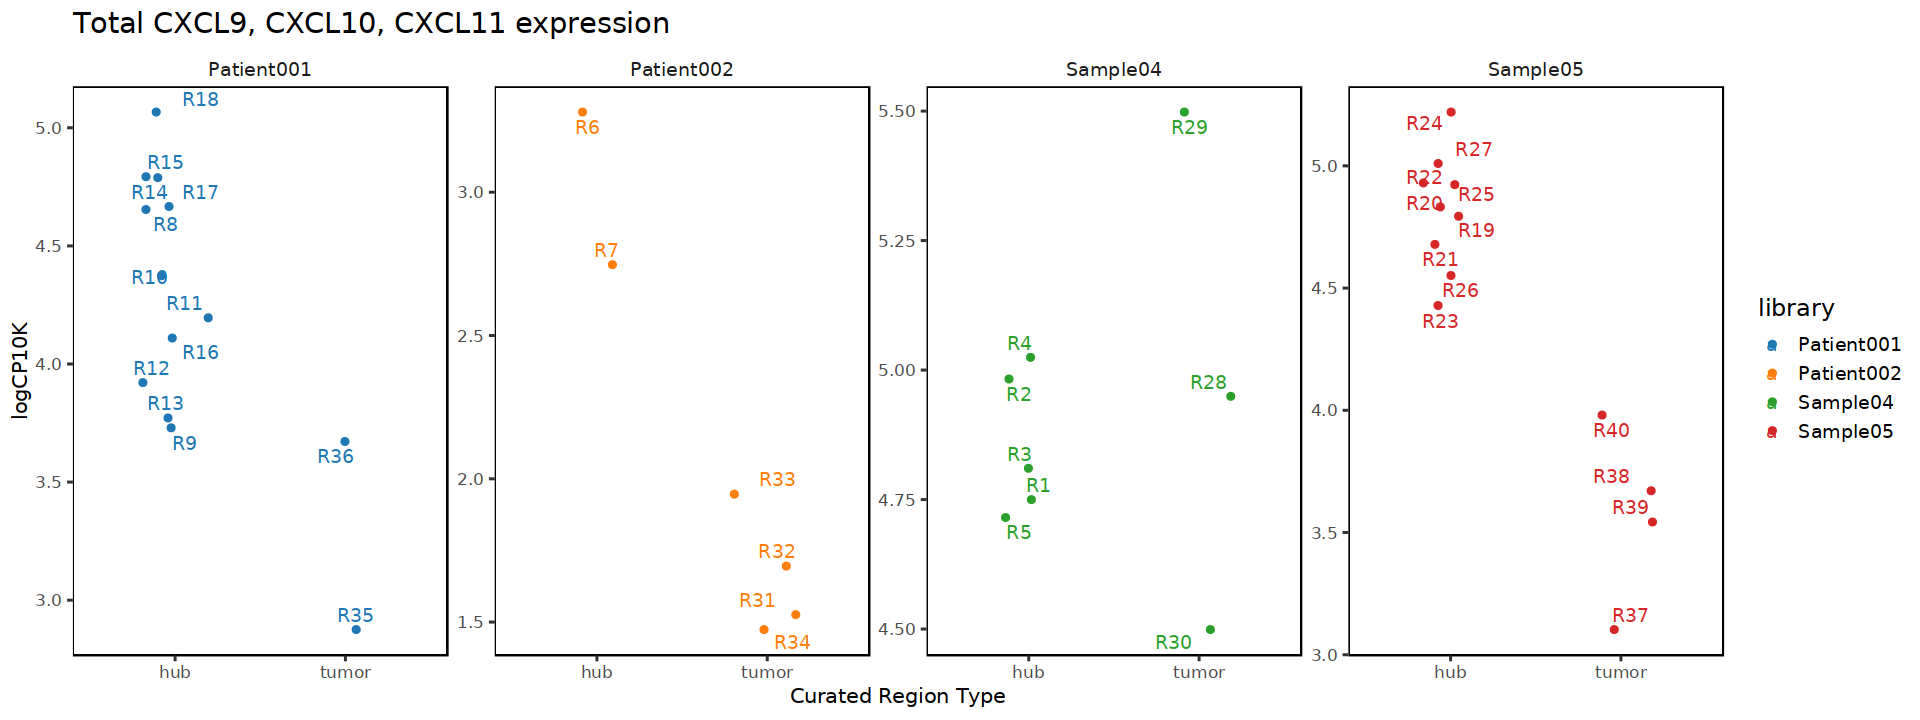

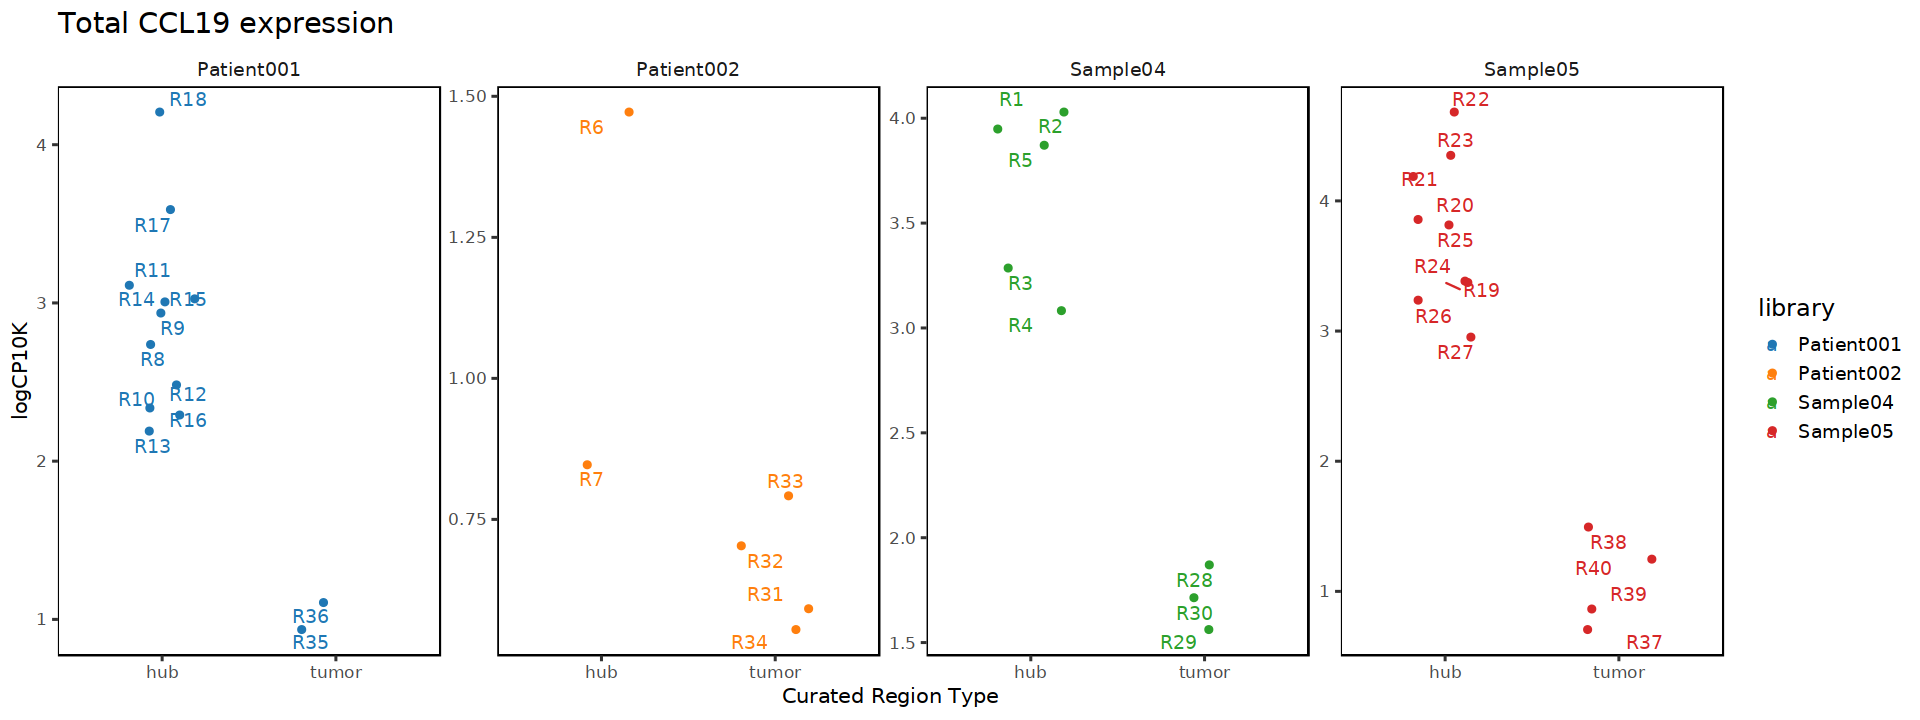

In [189]:
fig.size(6, 16)
pb$meta_data %>% 
    cbind(VAL = log1p(colSums(expm1(pb$exprs_norm[c('CXCL10', 'CXCL9', 'CXCL11'), ])))) %>% 
    ggplot(aes(region_type, VAL, color = library)) + 
        geom_jitter(width = .2, height = 0) + 
        geom_text_repel(aes(label = region)) + 
        facet_wrap(~library, nrow = 1, scales = 'free_y') + 
        labs(title = 'Total CXCL9, CXCL10, CXCL11 expression', y = 'logCP10K', x = 'Curated Region Type') + 
        scale_color_tableau('Classic 10') + 
        NULL

pb$meta_data %>% 
    cbind(VAL = pb$exprs_norm['CCL19', ]) %>% 
    ggplot(aes(region_type, VAL, color = library)) + 
        geom_jitter(width = .2, height = 0) + 
        geom_text_repel(aes(label = region)) + 
        facet_wrap(~library, nrow = 1, scales = 'free_y') + 
        labs(title = 'Total CCL19 expression', y = 'logCP10K', x = 'Curated Region Type') + 
        scale_color_tableau('Classic 10') + 
        NULL


## Cache

In [458]:
obj <- list(
    clusters = clusters,
    counts = counts,
    # Z_cos = harmony_res$Z_cos,
    # Z_corr = harmony_res$Z_corr,
    # R = harmony_res$R,
    logcpx = logcpx,
    # markers_clusters = markers,
    markers_types = markers_types, 
    meta_data = meta_data,
    pca_res = pca_res,
    U = U, ## from PCA
    U2 = U2 ## from Harmony
)

saveRDS(obj, 'lung_n4/obj_tumor_hub.rds')


In [2]:
obj <- readRDS('lung_n4/obj_tumor_hub.rds')
counts = obj$counts
Z_cos = obj$harmony_res$Z_cos
Z_corr = obj$harmony_res$Z_corr
R = obj$harmony_res$R
logcpx = obj$logcpx
markers = obj$markers
clusters = obj$clusters
meta_data = obj$meta_data
pca_res = obj$pca_res
U = obj$U ## from PCA
U2 = obj$U2 ## from Harmony


In [3]:
head(meta_data)

cell library    X        Y         ntx ngene nblank region region_type
321 321  Patient001 7109.369  900.5181 81  40    2      R35    tumor      
358 358  Patient001 7096.291 1000.7293 73  46    0      R35    tumor      
359 359  Patient001 7096.450 1085.9823 33  25    0      R35    tumor      
360 360  Patient001 7116.647  917.4242 38  29    0      R35    tumor      
361 361  Patient001 7113.121  926.8925 45  38    0      R35    tumor      
362 362  Patient001 7093.795  947.4176 68  37    0      R35    tumor      
    type                  
321 Epithelial:Epithelial4
358 Epithelial:Epithelial3
359 Epithelial:Epithelial3
360 Epithelial:Epithelial3
361 Epithelial:Epithelial1
362 Epithelial:Epithelial1

# Split tumor regions into TLS and non-immune hubs? 

In [3]:
# i <- meta_data %>% subset(region == 'R28') %>% with(cell) 
# i <- meta_data %>% subset(region == 'R29') %>% with(cell) 
i <- meta_data %>% subset(region == 'R36') %>% with(cell) 

length(i)

[1] 139475

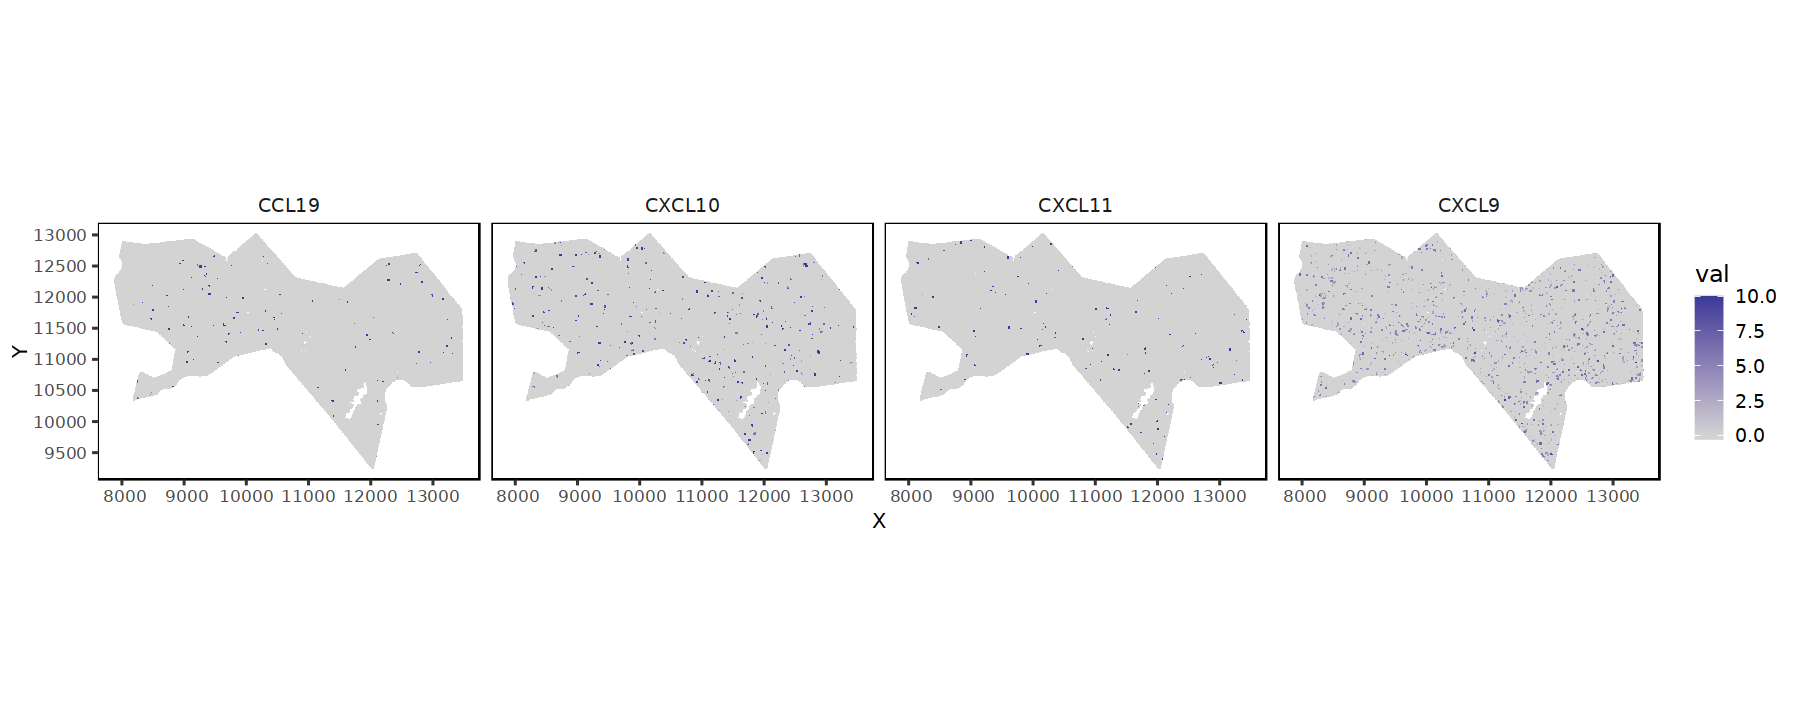

In [8]:
df <- meta_data[i, ] %>% 
    cbind(t(scaleData(logcpx[c('CXCL9', 'CXCL10', 'CXCL11', 'CCL19'), i], 1, 10)))
fig.size(6, 15)
df %>% 
    tidyr::gather(key, val, CXCL9:CCL19) %>% 
    # ggplot(aes(X, Y, z = val)) + 
    #     stat_summary_hex(fun = mean, bins = 30) + 
    ggplot(aes(X, Y, color = val)) + 
        geom_point(shape = '.') + 
        # geom_point(size = .5) + 
        coord_sf() + 
        facet_wrap(~key, nrow = 1) + 
        scale_color_gradient2(low = 'lightgrey', mid = 'lightgrey') + 
        scale_fill_gradient2(low = 'lightgrey', mid = 'lightgrey') + 
        # scale_fill_gradient2_tableau() + 
        NULL


In [9]:
i <- meta_data %>% subset(region == 'R28') %>% with(cell) 
# i <- meta_data %>% subset(region == 'R29') %>% with(cell) 
# i <- meta_data %>% subset(region == 'R36') %>% with(cell) 

length(i)

[1] 85990

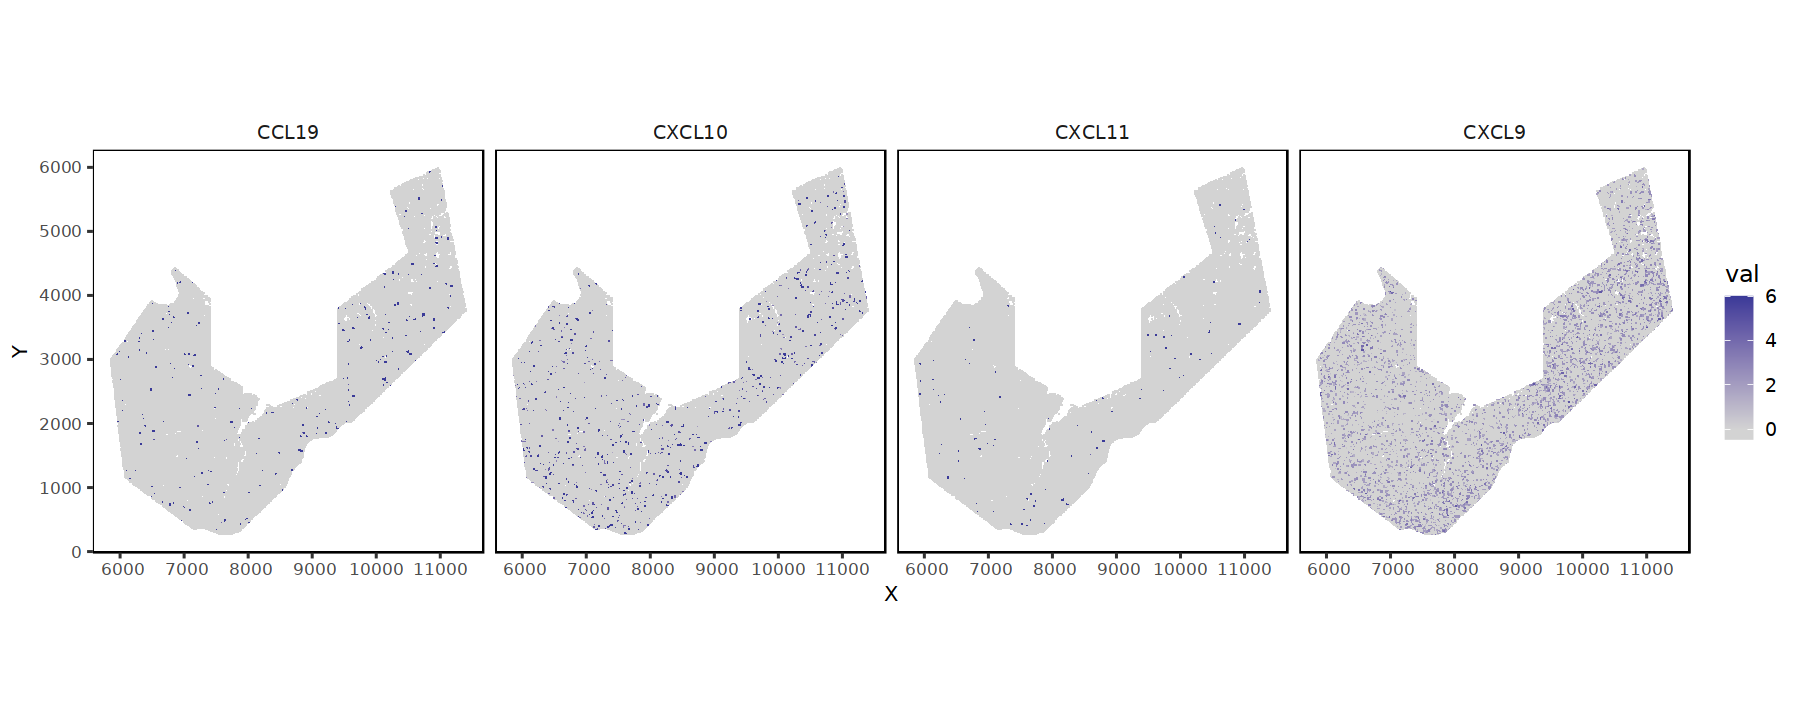

In [13]:
df <- meta_data[i, ] %>% 
    cbind(t(scaleData(logcpx[c('CXCL9', 'CXCL10', 'CXCL11', 'CCL19'), i], 1, 6)))
fig.size(6, 15)
df %>% 
    tidyr::gather(key, val, CXCL9:CCL19) %>% 
    # ggplot(aes(X, Y, z = val)) + 
    #     stat_summary_hex(fun = mean, bins = 30) + 
    ggplot(aes(X, Y, color = val)) + 
        geom_point(shape = '.') + 
        # geom_point(size = .5) + 
        coord_sf() + 
        facet_wrap(~key, nrow = 1) + 
        scale_color_gradient2(low = 'lightgrey', mid = 'lightgrey') + 
        scale_fill_gradient2(low = 'lightgrey', mid = 'lightgrey') + 
        # scale_fill_gradient2_tableau() + 
        NULL


# Can we isolate TCF7+ CD8+ T cells? 

In [370]:
i_t = which(grepl('CD8', meta_data$type))
# i_t = which(meta_data$type == 'Tcell:CD8')
# i = which(meta_data$type == 'Tcell:CD4')
# i = which(meta_data$type == 'Tcell:Treg')
length(i_t)
table(meta_data$type[i_t])

[1] 29832


     Tcell:CD8 Tcell:TCF7_CD8 
         28346           1486 

In [374]:
# X <- U2$fgraph[i_t, i_t]
# diag(X) <- 1
# snn_t <- X %*% X
# # snn@x[which(snn@x < quantile(snn@x, .01))] <- 0
# # snn <- Matrix::drop0(snn)
# snn_t <- snn_t + t(snn_t)

plan(multicore)
system.time({
    # clusters_t <- RunModularityClustering(snn_t, resolution = c(.1, .2, .4, .6, .8, 1.2, 1.5))
    clusters_t <- RunModularityClustering(U2$fgraph[i_t, i_t], resolution = c(.1, .2, .4, .6, .8, 1.2, 1.5))
    clusters_t <- map(clusters_t, function(x) x = factor(x, unique(as.integer(x)))) %>% bind_cols()     
})


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29832
Number of edges: 294098

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9000
Number of communities: 1
Elapsed time: 2 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29832
Number of edges: 294098

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8000
Number of communities: 1
Elapsed time: 2 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29832
Number of edges: 294098

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6983
Number of communities: 5
Elapsed time: 4 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29832
Number of edges: 294098

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6590
Number of communities: 6
Elapsed time: 5 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29832
Number of edges: 294098

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6352
Number of communities: 10
Elapsed time: 5 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29832
Number of edges: 294098

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5980
Number of communities: 16
Elapsed time: 5 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29832
Number of edges: 294098

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5781
Number of communities: 24
Elapsed time: 5 seconds


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`


   user  system elapsed 
 31.636   6.682   9.602 

In [375]:
map(map(clusters_t, table), length)
# map(map(clusters_t, table), sort, TRUE)

$Clust0.1
[1] 1

$Clust0.2
[1] 1

$Clust0.4
[1] 5

$Clust0.6
[1] 6

$Clust0.8
[1] 10

$Clust1.2
[1] 16

$Clust1.5
[1] 24

In [376]:
cluster_level <- 'Clust0.8'
pb <- presto::collapse_counts(counts[, i_t], cbind(meta_data[i_t, ], clusters_t), c('region', 'library', cluster_level), min_cells_per_group = 3, get_norm = TRUE)
pb$exprs_norm <- normalizeData(pb$counts_mat, 200, 'log')
markers_t <- wilcoxauc(pb$exprs_norm, pb$meta_data[[cluster_level]])


CAREFUL: get_norm makes very strong assumptions about data



In [1]:
markers_t %>% 
    subset(padj < .2) %>% 
    subset(feature %in% 'TCF7') %>% 
    # subset(feature %in% 'ISG20') %>% 
    # subset(feature %in% 'CD3E') %>% 
    # subset(feature %in% 'CD8A') %>% 
    # subset(feature %in% 'CD3D') %>% 
    # subset(feature %in% 'MKI67') %>% 
    arrange(-auc)


ERROR: Error in markers_t %>% subset(padj < 0.2) %>% subset(feature %in% "TCF7") %>% : could not find function "%>%"


In [391]:
meta_data_t <- (meta_data)[i_t, ] 
# meta_data_t <- st_drop_geometry(meta_data)[i_t, ] 
meta_data_t$type <- clusters_t %>% dplyr::mutate(type = case_when(
    # Clust1.2 %in% c('9') ~ 'Tcell:TCF7_CD8',
    Clust0.8 %in% c('1', '3') ~ 'Tcell:TCF7_CD8',
    # Clust0.8 %in% c('1', '3', '6') ~ 'Tcell:TCF7_CD8',
    TRUE ~ 'Tcell:CD8'
    # TRUE ~ as.character(Clust1.2)
)) %>% 
    # with(table(type))
    with(type)
table(meta_data_t$type)


     Tcell:CD8 Tcell:TCF7_CD8 
         21358           8474 

In [392]:
# t(top_markers(markers_t, 10))

In [393]:
meta_data_t %>% with(table(region_type, type)) %>% 
    prop.table(1)



           type
region_type Tcell:CD8 Tcell:TCF7_CD8
      hub   0.5964190      0.4035810
      tumor 0.7480124      0.2519876

In [394]:
# .m <- meta_data %>% cbind(CLUSTER = clusters$`Clust2.1`)
# .m$CLUSTER[i] <- paste0('T-', clusters_t$`Clust1.2`)


In [395]:
# fig.size(12, 12)
# do_scatter(U2$embedding[i, ], clusters_t, cluster_level, quo(Clust1.5), nrow = 3, do_labels = FALSE) 


Joining, by = "region"


$`FALSE`
             type           term  estimate  std.error statistic      p.value
1: Tcell:TCF7_CD8 region_typehub 0.1570429 0.02319042  6.771888 7.540364e-08
            fdr
1: 7.540364e-08

$`TRUE`
        type           term   estimate  std.error statistic      p.value
1: Tcell:CD8 region_typehub -0.1570429 0.02319042 -6.771888 7.540364e-08
            fdr
1: 7.540364e-08

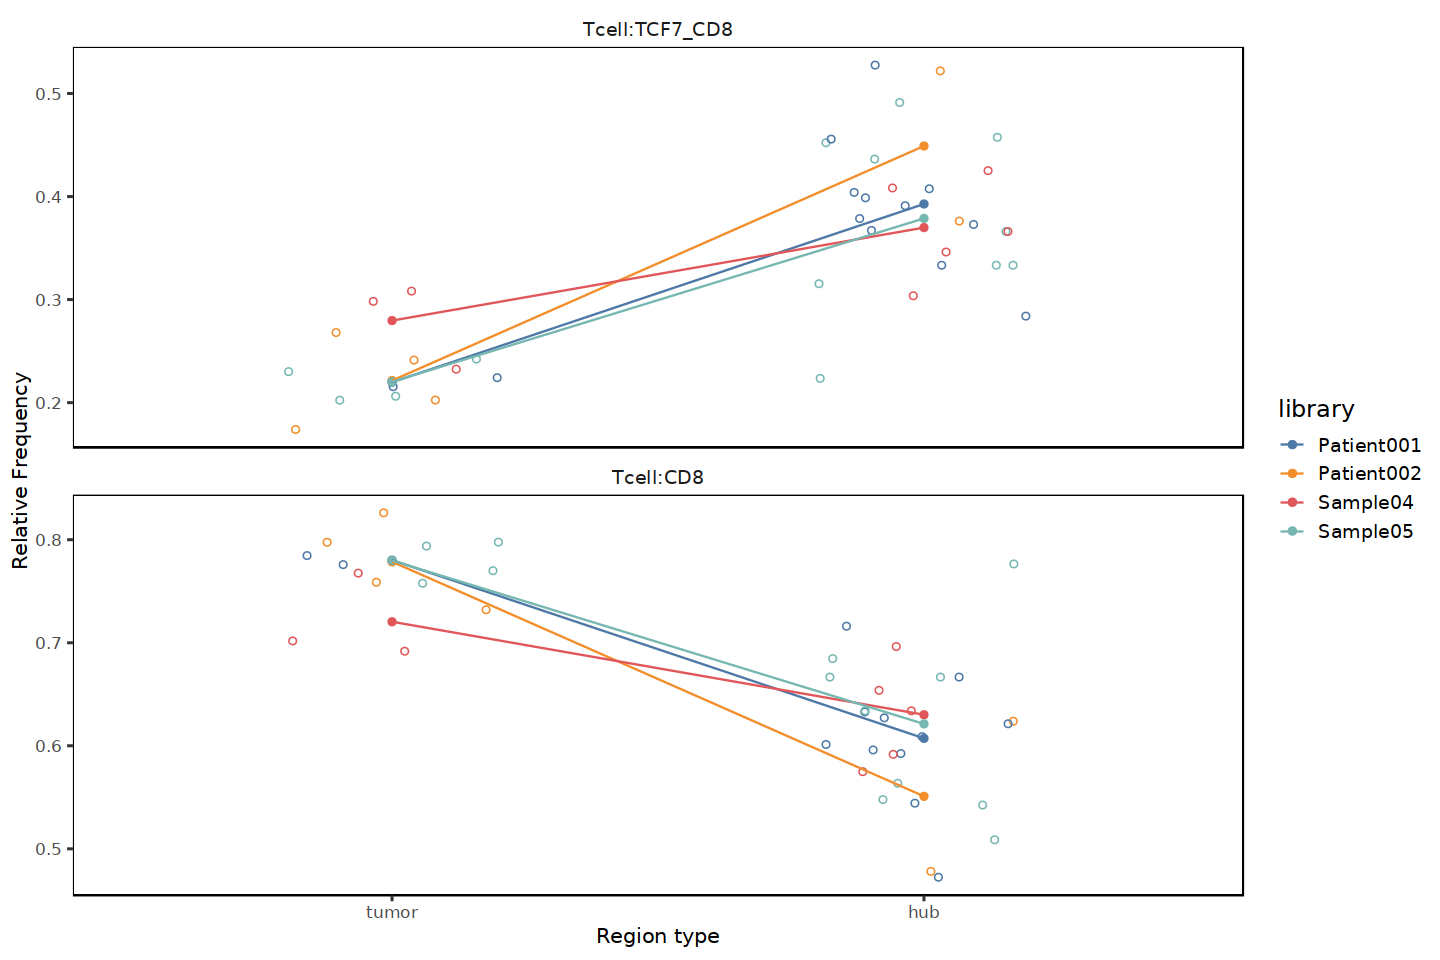

In [396]:
# df <- st_drop_geometry(meta_data)[i, ] %>% 
df <- meta_data_t %>% 
    # subset(grepl('Myeloid', type)) %>% 
    # subset(grepl('Macrophage', type)) %>% 
    # cbind(clusters_t) %>% 
    with(prop.table(table(region, type), 1)) %>% 
    data.table() %>% 
    left_join(
        unique(dplyr::select((meta_data), region, region_type, library))
        # unique(dplyr::select(st_drop_geometry(meta_data), region, region_type, library))
    )
df$region_type <- factor(df$region_type, c('tumor', 'hub'))
res = df[, broom::tidy(lm(N ~ 1 + region_type + library)), by = type][term == 'region_typehub'][order(-statistic)]
res$fdr <- p.adjust(res$p.value, 'BH')
res <- res[fdr < .05]
res %>% split(.$estimate < 0)

fig.size(8, 12)
df %>% 
    dplyr::mutate(type = type) %>% 
    dplyr::mutate(type = factor(type, res$type)) %>%  ## order by significance 
    subset(!is.na(type)) %>% 
    plot_abundance(nrow = 3)


In [399]:
.x = df %>% 
    subset(grepl('TCF7', type)) %>% 
    split(.$region_type) %>% 
    map(function(x) {
        print(mean(x$N))
        print(sd(x$N))
    })
    # map(N)

[1] 0.2342368
[1] 0.0384585
[1] 0.388039
[1] 0.07052832


## Relabel

In [404]:
meta_data[rownames(meta_data_t), 'type'] <- meta_data_t$type

# Figures

## Functions (cache for later in spatula?)

In [414]:
library(ComplexHeatmap)
library(circlize) ## for colorramp

make_color_pal_discrete <- function(groups) {
    ngroups <- length(groups)
    if (ngroups <= 10) {
        pal <- tableau_color_pal('Classic 10')(ngroups)
    } else if (ngroups <= 20) {
        pal <- tableau_color_pal('Classic 20')(ngroups)
    } else if (ngroups <= 30) {
        pal <- c(tableau_color_pal('Classic 20')(20), tableau_color_pal('Tableau 10')(ngroups - 20))
    } else if (ngroups <= 40) {
        pal <- c(tableau_color_pal('Classic 20')(20), tableau_color_pal('Tableau 20')(ngroups - 20))
    } else {
        stop('Cannot handle more than 40 groups')
    }
    names(pal) <- groups
    return(pal)
}



## Write function to plot nice heatmap 



In [416]:
## Params 
groups_plot = NULL
markers_df = markers_types
# markers_df = markers_macrophage
topn = 5
auc_min = .7
rank_by = c('auc', 'logFC')[2]
color_by = c('auc', 'logFC')[2]
highlights <- list(
    'Tcell:CD8' = c('CD8A'),
    'Myeloid:LAMP3_Dendritic' = c('LAMP3'),
    'Tcell:Treg' = c('FOXP3')
)


In [417]:
## Specifically designed to work with output from presto::wilcoxauc
do_markers_heatmap <- function(
    markers_df, 
    groups_plot=NULL, 
    highlights=NULL, 
    topn=5, 
    auc_min=.7, 
    rank_by = c('auc', 'logFC')[2],
    color_by = c('auc', 'logFC')[2],
    show_negative=FALSE,
    fontsize_rows=6,
    fontsize_cols=6
) {
    if (is.null(groups_plot)) groups_plot <- unique(markers_df$group)
    markers_df$SCORE_RANK <- markers_df[[rank_by]]
    markers_df$SCORE_COLOR <- markers_df[[color_by]]

    ## Get all significant genes 
    ## For each gene, get its "top" group 
    markers_all <- data.table(markers_df)[auc >= auc_min, head(.SD[order(-SCORE_RANK)], 1), by = feature] %>% 
        unique() %>% 
        subset(group %in% groups_plot) %>% 
        dplyr::mutate(group = factor(group, groups_plot)) %>% 
        split(.$group) %>% 
        map(sample_frac, 1L) %>% 
        bind_rows()
    
    ## Manually selected genes to highlight in group
    if (!is.null(highlights)) {
        markers_highlight <- imap(highlights, function(.features, .group) {
            subset(markers_df, group == .group & feature %in% .features)
        }) %>% 
            bind_rows()        
        markers_all <- unique(rbind(markers_all, markers_highlight))
    }
    
    ## Next, get all the top significant genes to highlight by name 
    markers_top <- data.table(markers_all)[auc >= auc_min, head(.SD[order(-SCORE_RANK)], topn), by = group] %>% 
        arrange(group)
    if (!is.null(highlights)) {
        markers_top <- unique(rbind(markers_top, markers_highlight))
    }

    ## Make the wide-form matrix to plot
    plt_mat <- markers_df %>% 
        subset(group %in% markers_all$group) %>% 
        subset(feature %in% markers_all$feature) %>% 
        dplyr::select(feature, group, SCORE_COLOR) %>% 
        tidyr::spread(group, SCORE_COLOR) %>% 
        tibble::column_to_rownames('feature') %>% 
        t()

    ## Define colors and font sizes
    palette_heatmap <- list(
        Cluster = make_color_pal_discrete(groups_plot)
    )
    ht_opt(RESET = TRUE)
    ht_opt("heatmap_column_names_gp" = gpar(fontsize = fontsize_cols))
    ht_opt("heatmap_row_names_gp" = gpar(fontsize = fontsize_rows))
    if (color_by == 'auc') {
        if (show_negative) {
            heatmap_colors <- colorRamp2(c(0, 0.5, 1), c(muted('red'), 'white', muted('blue')))
        } else {
            heatmap_colors <- colorRamp2(c(0, 0.5, 1), c('white', 'white', muted('blue')))
        }
    } else if (color_by == 'logFC') {
        stat_sd <- sd(markers_all$SCORE_COLOR)
        if (show_negative) {
            heatmap_colors <- colorRamp2(c(-stat_sd, 0, stat_sd), c(muted('red'), 'white', muted('blue')))
        } else {
            heatmap_colors <- colorRamp2(c(-stat_sd, 0, stat_sd), c('white', 'white', muted('blue')))
        }        
    } else {
        stop('only support auc and logFC for heatmap colors.')
    }
    
    
    ## Do the plot 
    h1 <- split(seq_len(nrow(markers_all)), markers_all$group) %>% 
        imap(function(idx, .cluster) {
            mat <- plt_mat[, markers_all$feature[idx]]
            ccl <- colnames(mat) %in% markers_top$feature

            if (.cluster == tail(groups_plot, 1)) {
                Heatmap(
                    matrix = mat, 

                    ## column label
                    # column_title = gsub(' ', '\n', clust_dict[.cluster, 'Cluster_name']), 
                    column_title_side = 'bottom',
                    column_title_gp = gpar(fontsize = 8, fontface = "bold"),

                    name = color_by, 
                    show_column_names = FALSE,
                    col = heatmap_colors,    
                    # colorRamp2(c(0, 0.5, 1), c(muted('red'), 'white', muted('blue'))),    
                    # row_order = order(as.integer(gsub('.*? C(\\d+)', '\\1', rownames(plt_mat)))), 
    #                 row_order = order(as.integer(gsub('.*?_(\\d+)', '\\1', rownames(plt_mat)))), 
                    column_names_rot = 90, 
                    use_raster = TRUE, raster_device = "CairoJPEG",
                    cluster_columns = FALSE, 
                    cluster_rows = FALSE, 
                    show_heatmap_legend = TRUE, 
                    heatmap_legend_param = list(
                        legend_direction = "horizontal",
                        title_position = 'lefttop',
                        legend_height = unit(2, "cm")
                    ),
    #                 show_heatmap_legend = .cluster == '0', ## only show legend for one cluster
                    top_annotation = columnAnnotation(
                        show_legend = FALSE, 
                        show_annotation_name = FALSE,
                        link = anno_mark(
                            at = which(ccl), 
                            labels = colnames(mat)[ccl], 
                            labels_gp = gpar(fontsize = 8), padding = unit(0, "mm"),
                            labels_rot = 90
                        ),
                        Cluster = markers_all$group[idx],
                        col = palette_heatmap
    #                     labels = c("group1", "group2", "group3"), 
    #                     labels_gp = gpar(col = "white", fontsize = 10)
                    ),
                )
            } else {
                Heatmap(
                    matrix = mat, 

                    ## Column titles 
                    # column_title = gsub(' ', '\n', clust_dict[.cluster, 'Cluster_name']) %>% paste0(' Markers'), 
                    column_title_side = 'bottom',
                    show_column_names = FALSE,
                    column_title_gp = gpar(fontsize = 8, fontface = "bold"),


                    col = heatmap_colors,    
                    # colorRamp2(c(0, 0.5, 1), c(muted('red'), 'white', muted('blue'))),    
                    # row_order = order(as.integer(gsub('.*? C(\\d+)', '\\1', rownames(plt_mat)))), 
    #                 row_order = order(as.integer(gsub('.*?_(\\d+)', '\\1', rownames(plt_mat)))), 
                    column_names_rot = 90, 
                    use_raster = TRUE, raster_device = "CairoJPEG",
                    cluster_columns = FALSE, 
                    cluster_rows = FALSE, 
                    show_heatmap_legend = FALSE, ## only show legend for one cluster
                    top_annotation = columnAnnotation(
                        show_legend = FALSE, 
                        show_annotation_name = FALSE,
                        link = anno_mark(
                            at = which(ccl), 
                            labels = colnames(mat)[ccl], 
                            labels_gp = gpar(fontsize = 8), padding = unit(0, "mm"),
                            labels_rot = 90
                        ),
                        Cluster = markers_all$group[idx],
                        col = palette_heatmap
                    ),
                )
            }
        }) %>% 
        purrr::reduce(`+`)



    ## Add some padding and wrap it into one figure 
    plt <- grid.grabExpr(draw(h1, padding = unit(c(10, 2, 2, 10), "mm"), heatmap_legend_side = 'bottom')) #bottom, left, top, right paddings
    plt <- wrap_elements(plt)
    return(plt)
}


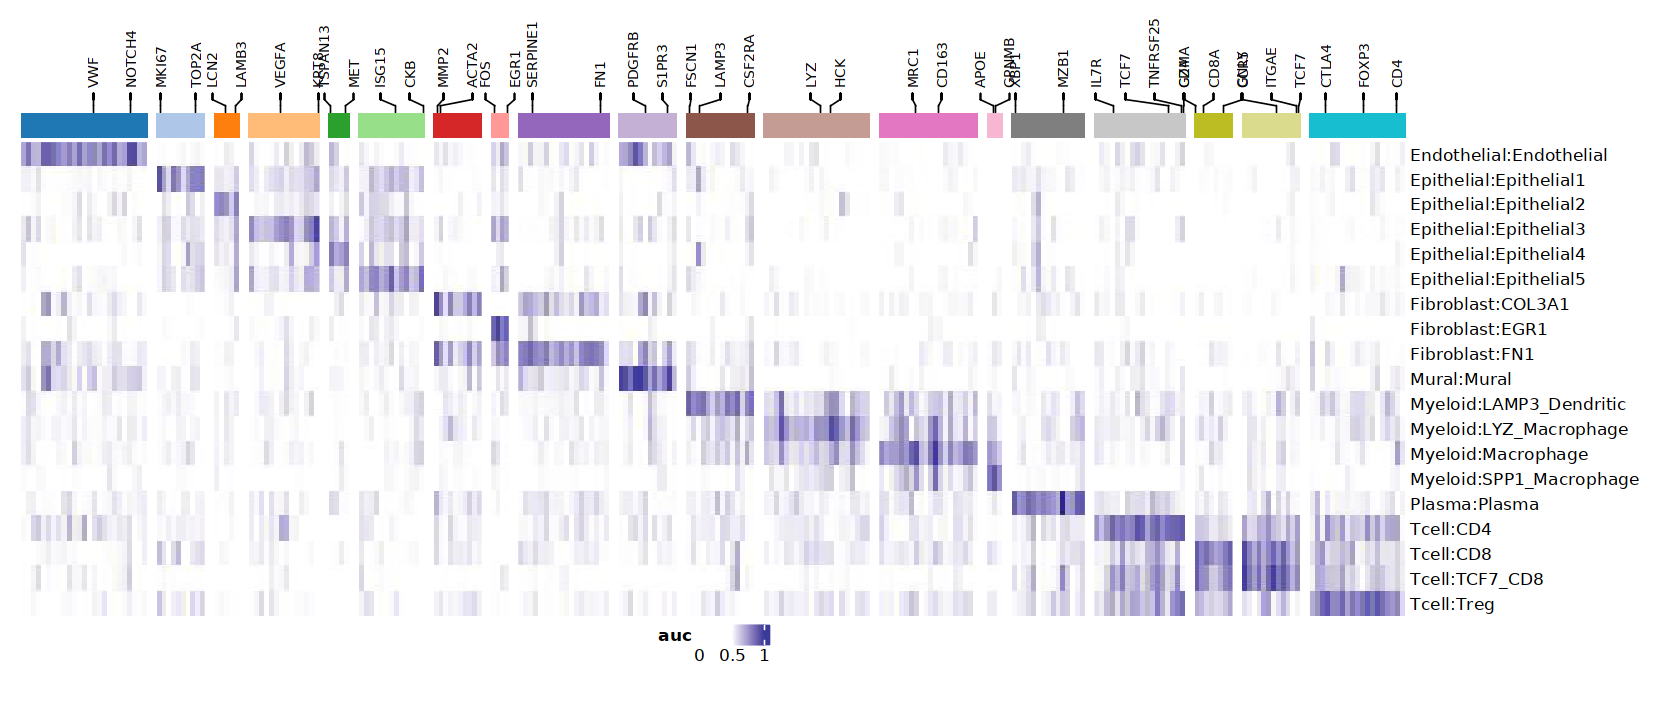

In [422]:
fig.size(6, 14)
do_markers_heatmap(
    markers_types, 
    highlights = list(
        'Fibroblast:COL3A1_Fibroblast' = c('COL3A1'),
        'Fibroblast:FN1_Fibroblast' = c('FN1'),
        'Tcell:CD4' = c('CD4'),
        'Tcell:CD8' = c('CD8A'),
        'Tcell:TCF7_CD8' = c('TCF7'),
        'Myeloid:LAMP3_Dendritic' = c('LAMP3'),
        'Tcell:Treg' = c('FOXP3'),
        'Mural' = c('NOTCH3')
    ),
    topn=2, auc_min=0.5, 
    rank_by='auc', 
    color_by='auc', 
    show_negative = FALSE,
    fontsize_rows = 10
)


In [44]:
fig.size(4, 10)
do_markers_heatmap(
    markers_epithelial, 
    # highlights = list(
    #     'Fibroblast:COL3A1_Fibroblast' = c('COL3A1'),
    #     'Fibroblast:FN1_Fibroblast' = c('FN1'),
    #     'Tcell:CD4' = c('CD4'),
    #     'Tcell:CD8' = c('CD8A'),
    #     'Myeloid:LAMP3_Dendritic' = c('LAMP3'),
    #     'Tcell:Treg' = c('FOXP3'),
    #     'Mural' = c('NOTCH3')
    # ),
    topn=5, auc_min=0.7, 
    rank_by='auc', 
    color_by='auc', 
    show_negative = FALSE,
    fontsize_rows = 10
)


ERROR: Error in unique(markers_df$group): object 'markers_epithelial' not found


## UMAP - cell types

In [425]:
## ~900K cells: plot them all? 
## Only plot representative cells from each type 
set.seed(42L)
i = data.table(tibble::rowid_to_column((meta_data), 'i'))[
# i = data.table(tibble::rowid_to_column(st_drop_geometry(meta_data), 'i'))[
    !is.na(type), sample_n(.SD, min(1e4, .N)), by = type
][
    , i
]

plt_df <- U2$embedding[i, ] %>% 
    data.frame() %>% 
    cbind(meta_data[i, ]) %>% 
    dplyr::sample_frac(1L) ## reshuffle types, so they don't cover one another
## NOTE: median instead of mean b/c too many outliers
centers_df <- data.table(plt_df)[, .(X1 = median(X1), X2 = median(X2)), by = type]


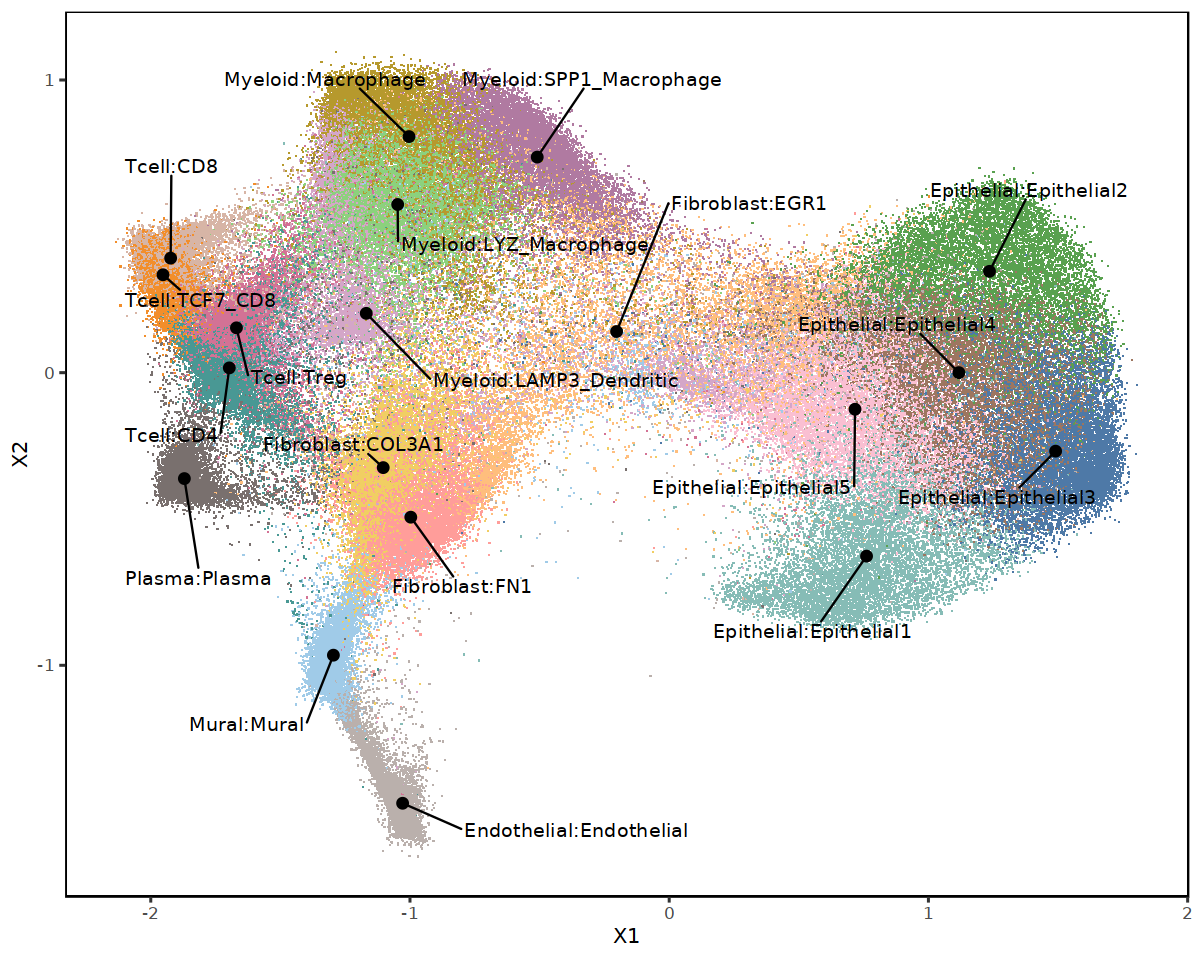

In [428]:
set.seed(5)
pal = tableau_color_pal('Tableau 20')(20)
names(pal) = sample(unique(meta_data$type))

fig.size(8, 10)
ggplot() + 
    geom_point(
        data = plt_df, 
        shape = '.', aes(X1, X2, color = type)
    ) + 
    geom_point(
        data = centers_df,  
        aes(X1, X2), 
        size = 3, shape = 16
    ) +     
    # guides(
    #     color = guide_legend(override.aes = list(
    #         stroke = 1, alpha = 1, shape = 16, size = 4
    #     )), alpha = "none"
    # ) + 
    geom_text_repel(
        data = centers_df,  
        aes(X1, X2, label = type), 
        box.padding = 2.5, max.overlaps = Inf,
        size = 4
    ) + 
    scale_color_manual(values = pal) + 
    guides(color = 'none') + 
    NULL


## Key markers

In [ ]:
g = c(
    'CXCL9', 'CXCL10', 'CXCL11', 'CXCL13', 'CCL5', 'CCL17', 'CCL18', 'CCL19', 'CCL21', 'CCL22',
    'IFI6', 'IFI27', 'ISG15', 'ISG20', 'LY6C', 'PDCD1', 'STAT1', 'TAP1'
)


In [ ]:
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 10))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))
fig.size(5, 6)
markers_types %>% 
    subset(feature %in% g) %>% 
    # select(feature, group, logFC) %>% 
    # tidyr::spread(group, logFC) %>% 
    select(feature, group, auc) %>% 
    tidyr::spread(group, auc) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() %>% 
    t() %>% 
    Heatmap(
        # col = colorRamp2(c(0, 0, 1), c('white', 'white', muted('blue'))),
        col = colorRamp2(c(0, 0.5, 1), c('white', 'white', muted('blue'))),
        name = 'auc'
    )


## Bar plots - cell types over regions/libraries

In [15]:
meta_data %>% 
    head

cell library    X        Y         ntx ngene nblank region region_type
321 321  Patient001 7109.369  900.5181 81  40    2      R35    tumor      
358 358  Patient001 7096.291 1000.7293 73  46    0      R35    tumor      
359 359  Patient001 7096.450 1085.9823 33  25    0      R35    tumor      
360 360  Patient001 7116.647  917.4242 38  29    0      R35    tumor      
361 361  Patient001 7113.121  926.8925 45  38    0      R35    tumor      
362 362  Patient001 7093.795  947.4176 68  37    0      R35    tumor      
    bbox                           type                  
321 POLYGON ((7104.381 894.4674... Epithelial:Epithelial4
358 POLYGON ((7090.55 995.4227,... Epithelial:Epithelial3
359 POLYGON ((7091.467 1083.426... Epithelial:Epithelial3
360 POLYGON ((7111.766 911.6127... Epithelial:Epithelial3
361 POLYGON ((7108.164 922.3126... Epithelial:Epithelial1
362 POLYGON ((7088.833 943.1668... Epithelial:Epithelial1

In [24]:
meta_data %>% 
    with(prop.table(table(type, region), 2)) %>% 
    data.table() %>% 
    left_join(unique(select(st_drop_geometry(meta_data), region, region_type, library)))  %>% head

Joining, by = "region"


type                    region N           region_type library 
1 Endothelial:Endothelial R1     0.044359012 hub         Sample04
2 Epithelial:Epithelial1  R1     0.023806003 hub         Sample04
3 Epithelial:Epithelial2  R1     0.009019666 hub         Sample04
4 Epithelial:Epithelial3  R1     0.007097442 hub         Sample04
5 Epithelial:Epithelial4  R1     0.005618808 hub         Sample04
6 Epithelial:Epithelial5  R1     0.006358125 hub         Sample04

In [57]:
plt_df <- meta_data %>% 
    with(prop.table(table(type, region), 2)) %>% 
    data.table() %>% 
    left_join(unique(select(st_drop_geometry(meta_data), region, region_type, library))) %>% 
    dplyr::mutate(lib_int = as.integer(factor(library)))

Joining, by = "region"


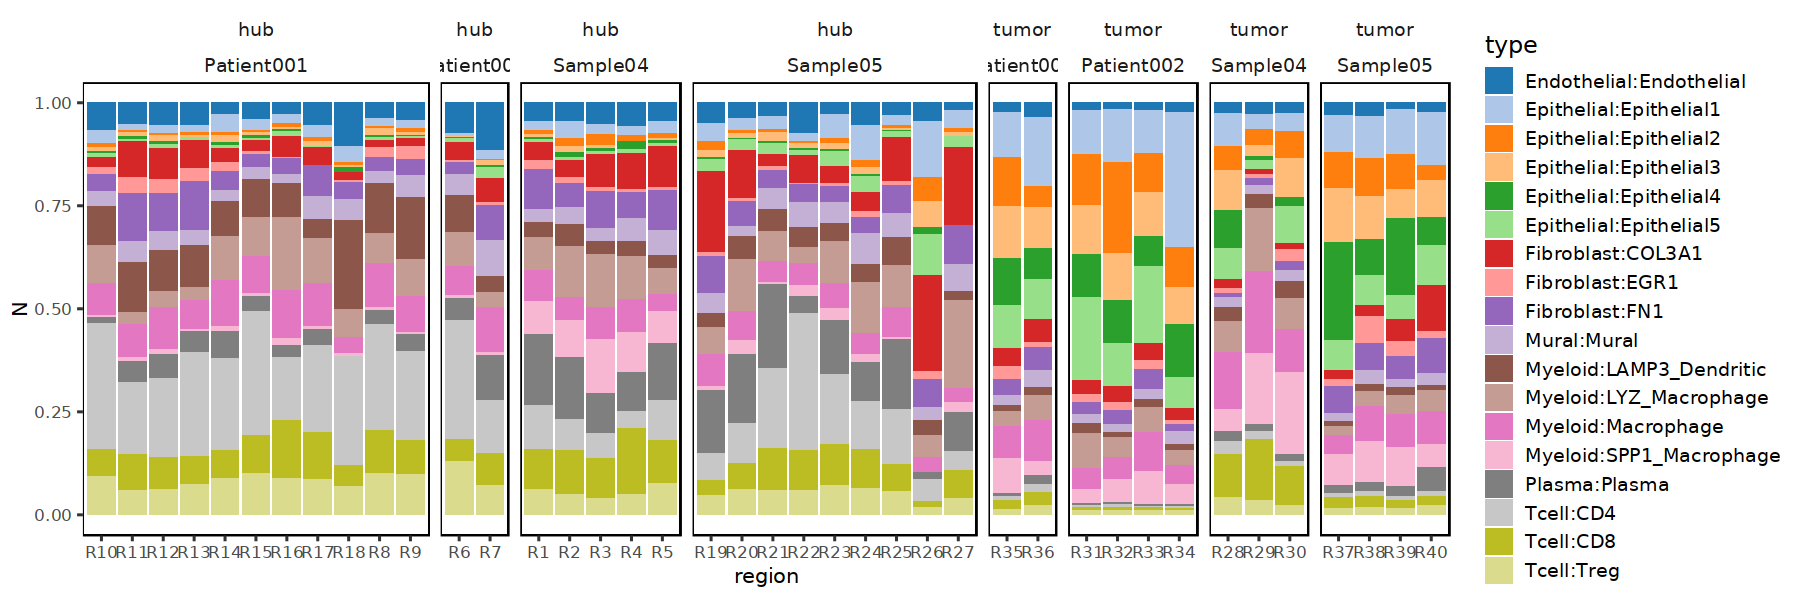

In [64]:
fig.size(5, 15)
ggplot(plt_df, aes(region, N, fill = type)) + 
# ggplot(plt_df, aes(reorder(paste(region, library), lib_int), N, fill = type)) + 
    geom_bar(stat = 'identity', position = position_stack()) + 
    # coord_flip() + 
    scale_fill_tableau('Classic 20') + 
    facet_grid(.~region_type+library, scales = 'free', space = 'free') + 
    # facet_grid(region_type+library~., scales = 'free', space = 'free') + 
    NULL


In [67]:
X <- plt_df %>% 
    tidyr::spread(type, N) 
head(X)

region region_type library    lib_int Endothelial:Endothelial
1 R1     hub         Sample04   3       0.04435901             
2 R10    hub         Patient001 1       0.06691061             
3 R11    hub         Patient001 1       0.05349108             
4 R12    hub         Patient001 1       0.05558428             
5 R13    hub         Patient001 1       0.05476118             
6 R14    hub         Patient001 1       0.02876216             
  Epithelial:Epithelial1 Epithelial:Epithelial2 Epithelial:Epithelial3
1 0.02380600             0.009019666            0.007097442           
2 0.03293257             0.008363826            0.010454783           
3 0.01283119             0.006498917            0.010164973           
4 0.01835574             0.006463289            0.014736298           
5 0.01794950             0.007909948            0.003042288           
6 0.04261061             0.007669910            0.016476103           
  Epithelial:Epithelial4 Epithelial:Epithelial5 ⋯ Fibroblast:FN1 Mural:Mural
1 0.005618808            0.006358125            ⋯ 0.09847701     0.03001626 
2 0.004704652            0.009932044            ⋯ 0.03972818     0.03659174 
3 0.005165806            0.005665722            ⋯ 0.11681386     0.05265789 
4 0.005170631            0.010858325            ⋯ 0.09307135     0.04576008 
5 0.001521144            0.005780347            ⋯ 0.11773654     0.03650745 
6 0.008380087            0.007882963            ⋯ 0.04786592     0.02570840 
  Myeloid:LAMP3_Dendritic Myeloid:LYZ_Macrophage Myeloid:Macrophage
1 0.03755730              0.08028981             0.07378382        
2 0.09618400              0.09147935             0.07736539        
3 0.11931345              0.02899517             0.08198634        
4 0.09824199              0.03826267             0.10315408        
5 0.10100395              0.03346517             0.06997262        
6 0.08507918              0.10773383             0.11071657        
  Myeloid:SPP1_Macrophage Plasma:Plasma Tcell:CD4 Tcell:CD8  Tcell:Treg
1 0.079846222             0.17433092    0.1051309 0.09773769 0.06136330
2 0.005227392             0.01411396    0.3058024 0.06638787 0.09252483
3 0.008831861             0.05149142    0.1744709 0.08715214 0.05899017
4 0.011116856             0.05816960    0.1933816 0.07678387 0.06153051
5 0.004259203             0.05019775    0.2522057 0.06845148 0.07392759
6 0.012357077             0.06519423    0.2227115 0.06910021 0.08763582

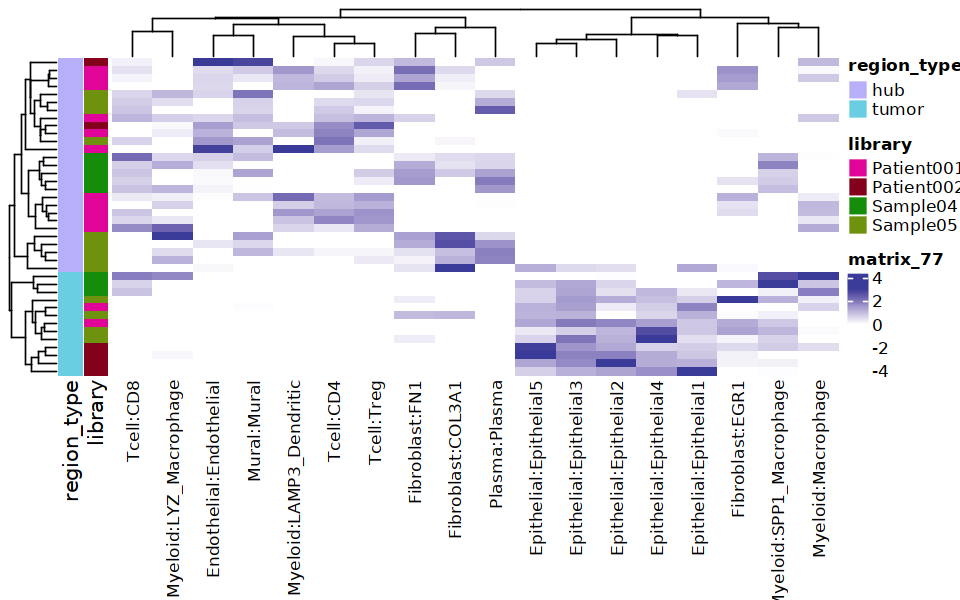

In [100]:
fig.size(5, 8)
set.seed(5)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 10))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))
Heatmap(
    scale(as.matrix(dplyr::select(X, all_of(unique(plt_df$type))))),
    left_annotation = rowAnnotation(
        df = dplyr::select(X, region_type, library)
    ),
    col = colorRamp2(c(-3, 0, 3), c('white', 'white', muted('blue')))
)

## Diff abundance 

In [430]:
plot_abundance <- function(df, nrow) {
    ggplot(df, aes(region_type, N, color = library)) + 
        geom_jitter(width = .2, height = 0, shape = 21) + 
        geom_point(
            data = df[, .(N = mean(N)), by = .(region_type, library, type)], 
            size = 2, 
            shape = 16
        ) + 
        geom_line(
            data = df[, .(N = mean(N)), by = .(region_type, library, type)], 
            aes(group = library)
        ) + 
        facet_wrap(~type, scales = 'free_y', nrow = nrow) + 
        labs(x = 'Region type', y = 'Relative Frequency') + 
        scale_color_tableau() + 
        NULL    
}


### All

Joining, by = "region"


$`FALSE`
                       type           term   estimate   std.error statistic
 1:              Tcell:Treg region_typehub 0.05012388 0.006777990  7.395096
 2:               Tcell:CD4 region_typehub 0.14678018 0.023171033  6.334641
 3:          Tcell:TCF7_CD8 region_typehub 0.02267859 0.003834183  5.914843
 4:           Plasma:Plasma region_typehub 0.07491268 0.014008030  5.347839
 5:             Mural:Mural region_typehub 0.02363185 0.005184355  4.558302
 6: Endothelial:Endothelial region_typehub 0.02903428 0.006959791  4.171718
 7:               Tcell:CD8 region_typehub 0.02290626 0.005707216  4.013561
 8: Myeloid:LAMP3_Dendritic region_typehub 0.04148790 0.011090529  3.740841
 9:  Myeloid:LYZ_Macrophage region_typehub 0.03696888 0.014303764  2.584556
10:       Fibroblast:COL3A1 region_typehub 0.03494133 0.016472543  2.121186
         p.value          fdr
 1: 1.419917e-08 5.395685e-08
 2: 3.177176e-07 1.006106e-06
 3: 1.110855e-06 2.638280e-06
 4: 6.070137e-06 1.281473e-05
 5: 6.373216e-05 1.100828e-04
 6: 1.974131e-04 3.125707e-04
 7: 3.114703e-04 4.552259e-04
 8: 6.759936e-04 9.174199e-04
 9: 1.421659e-02 1.688220e-02
10: 4.127754e-02 4.613372e-02

$`TRUE`
                      type           term    estimate   std.error  statistic
1:         Fibroblast:EGR1 region_typehub -0.01450858 0.004501578  -3.222999
2:  Epithelial:Epithelial1 region_typehub -0.08147026 0.016054289  -5.074672
3: Myeloid:SPP1_Macrophage region_typehub -0.05154224 0.008583483  -6.004817
4:  Epithelial:Epithelial5 region_typehub -0.07471260 0.010020063  -7.456300
5:  Epithelial:Epithelial2 region_typehub -0.07472663 0.009896836  -7.550558
6:  Epithelial:Epithelial4 region_typehub -0.10260507 0.011755374  -8.728355
7:  Epithelial:Epithelial3 region_typehub -0.09052559 0.005037045 -17.971965
        p.value          fdr
1: 2.797373e-03 3.543339e-03
2: 1.374515e-05 2.611579e-05
3: 8.489222e-07 2.304218e-06
4: 1.190493e-08 5.395685e-08
5: 9.082251e-09 5.395685e-08
6: 3.365226e-10 3.196965e-09
7: 6.214941e-19 1.180839e-17

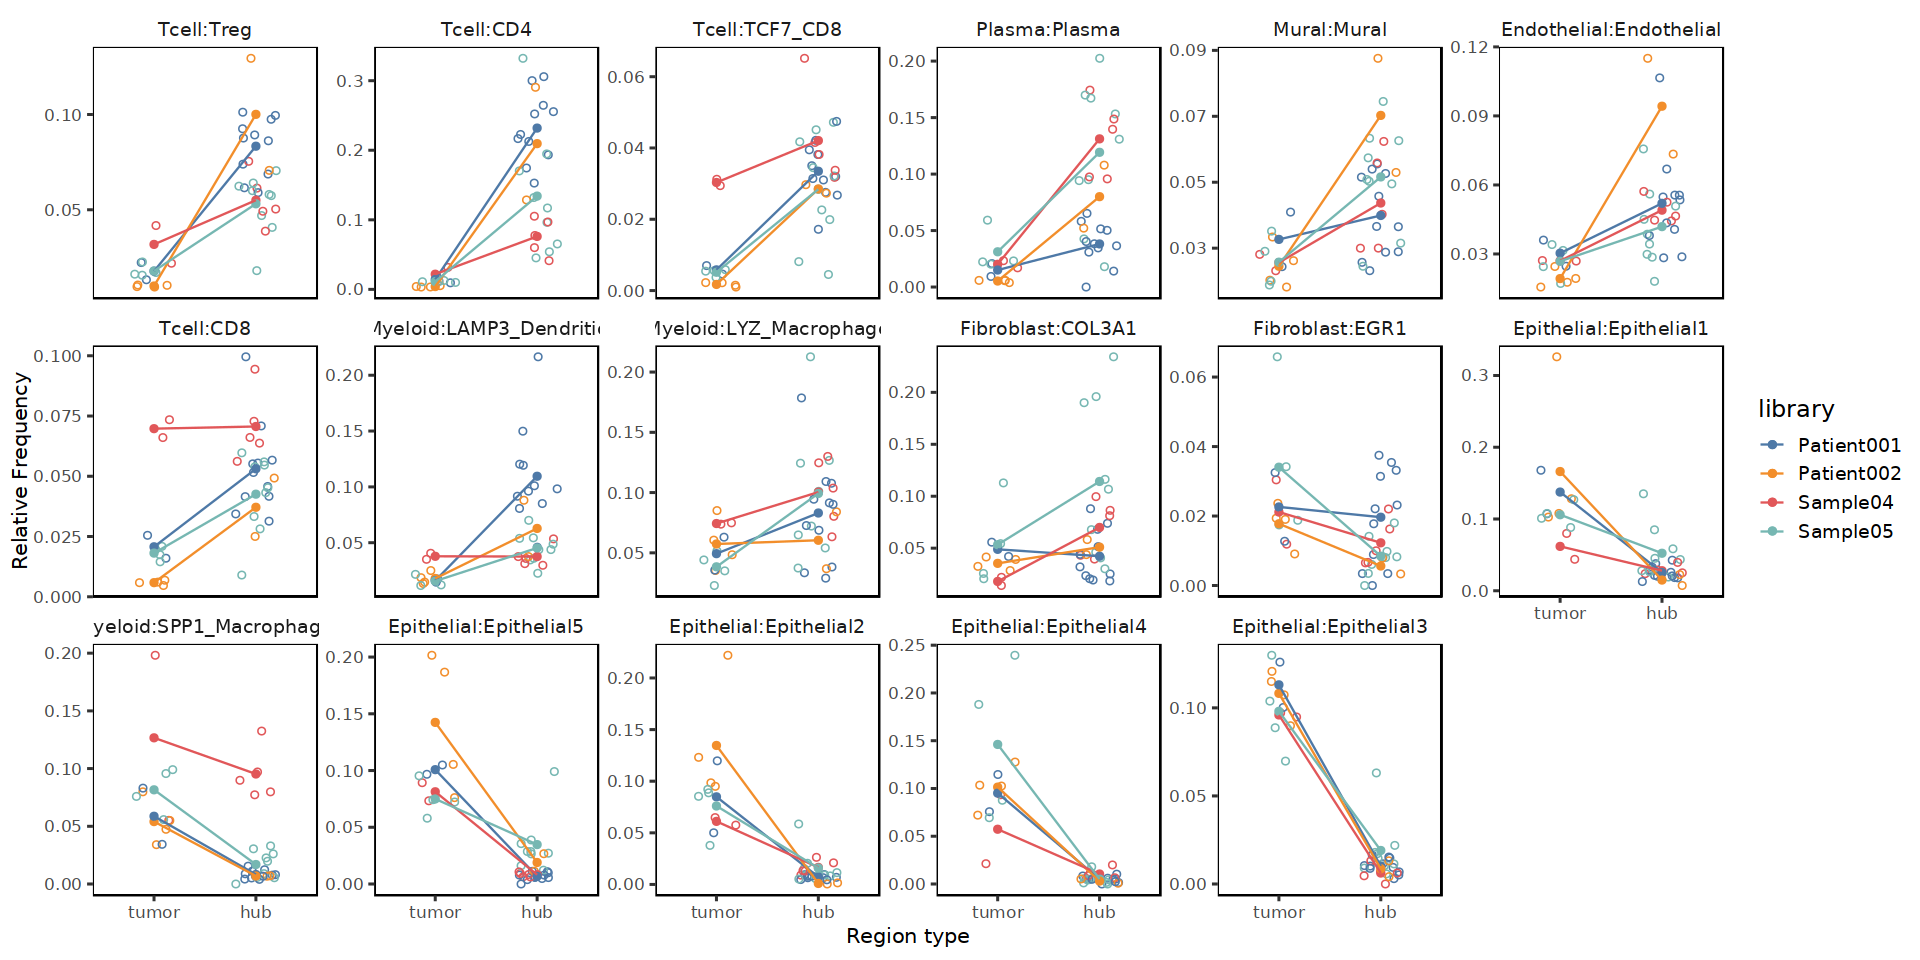

In [448]:
df <- meta_data %>% 
    # st_drop_geometry() %>% 
    subset(region != 'R29') %>% 
    with(prop.table(table(region, type), 1)) %>% 
    data.table() %>% 
    left_join(
        unique(dplyr::select((meta_data), region, region_type, library))
        # unique(dplyr::select(st_drop_geometry(meta_data), region, region_type, library))
    )

df$region_type <- factor(df$region_type, c('tumor', 'hub'))
res = df[, broom::tidy(lm(N ~ 1 + region_type + library)), by = type][term == 'region_typehub'][order(-statistic)]
res$fdr <- p.adjust(res$p.value, 'BH')
res <- res[fdr < .05]
res[fdr < .05] %>% split(.$estimate < 0)

fig.size(8, 16)
df %>% 
    dplyr::mutate(type = factor(type, res$`type`)) %>%  ## order by significance 
    subset(!is.na(type)) %>% 
    plot_abundance(nrow = 3) 


In [449]:
table(meta_data$type)


Endothelial:Endothelial  Epithelial:Epithelial1  Epithelial:Epithelial2 
                  24052                   97960                   90066 
 Epithelial:Epithelial3  Epithelial:Epithelial4  Epithelial:Epithelial5 
                  90232                   86174                   83754 
      Fibroblast:COL3A1         Fibroblast:EGR1          Fibroblast:FN1 
                  38952                   20139                   40236 
            Mural:Mural Myeloid:LAMP3_Dendritic  Myeloid:LYZ_Macrophage 
                  24335                   20202                   46856 
     Myeloid:Macrophage Myeloid:SPP1_Macrophage           Plasma:Plasma 
                  72943                   54082                   19585 
              Tcell:CD4               Tcell:CD8          Tcell:TCF7_CD8 
                  24874                   21358                    8474 
             Tcell:Treg 
                  20199 

### Diff abundance - Epithelial

Joining, by = "region"


$`FALSE`
                     type           term   estimate  std.error statistic
1: Epithelial:Epithelial1 region_typehub 0.17615721 0.03036393  5.801529
2: Epithelial:Epithelial5 region_typehub 0.04433876 0.02814981  1.575100
        p.value          fdr
1: 1.410084e-06 7.050422e-06
2: 1.242305e-01 1.242305e-01

$`TRUE`
                     type           term    estimate  std.error statistic
1: Epithelial:Epithelial2 region_typehub -0.04395163 0.02212174 -1.986807
2: Epithelial:Epithelial3 region_typehub -0.06060049 0.02124141 -2.852941
3: Epithelial:Epithelial4 region_typehub -0.11594386 0.02719808 -4.262943
        p.value          fdr
1: 0.0548160836 0.0685201045
2: 0.0072255268 0.0120425447
3: 0.0001449598 0.0003623996

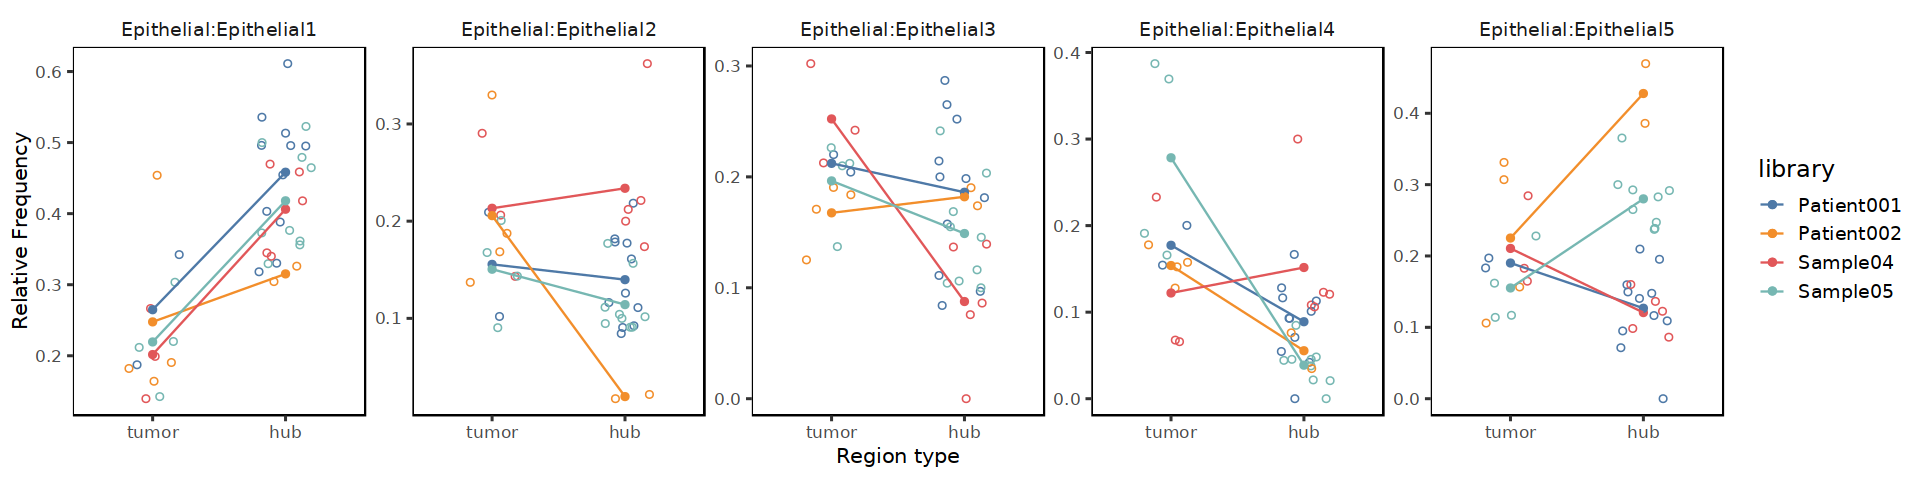

In [113]:
df <- meta_data %>% 
    st_drop_geometry() %>% 
    subset(grepl('Epithelial', type)) %>% 
    with(prop.table(table(region, type), 1)) %>% 
    data.table() %>% 
    left_join(
        unique(dplyr::select(st_drop_geometry(meta_data), region, region_type, library))
    )
df$region_type <- factor(df$region_type, c('tumor', 'hub'))
res = df[, broom::tidy(lm(N ~ 1 + region_type + library)), by = type][term == 'region_typehub'][order(-statistic)]
res$fdr <- p.adjust(res$p.value, 'BH')
# res <- res[fdr < .05]
res %>% split(.$estimate < 0)

fig.size(4, 16)
df %>% 
    # dplyr::mutate(type = factor(type, res$`type`)) %>%  ## order by significance 
    subset(!is.na(type)) %>% 
    plot_abundance(nrow = 1)


### Diff abundance - Myeloid

Joining, by = "region"


$`FALSE`
                     type           term   estimate  std.error statistic
1: Myeloid:LYZ_Macrophage region_typehub 0.20785106 0.04352678  4.775245
2:     Myeloid:Macrophage region_typehub 0.01218649 0.04088536  0.298065
        p.value          fdr
1: 3.157378e-05 4.736066e-05
2: 7.674159e-01 7.674159e-01

$`TRUE`
                      type           term   estimate  std.error statistic
1: Myeloid:SPP1_Macrophage region_typehub -0.2200376 0.03446685 -6.384035
        p.value          fdr
1: 2.416791e-07 7.250373e-07

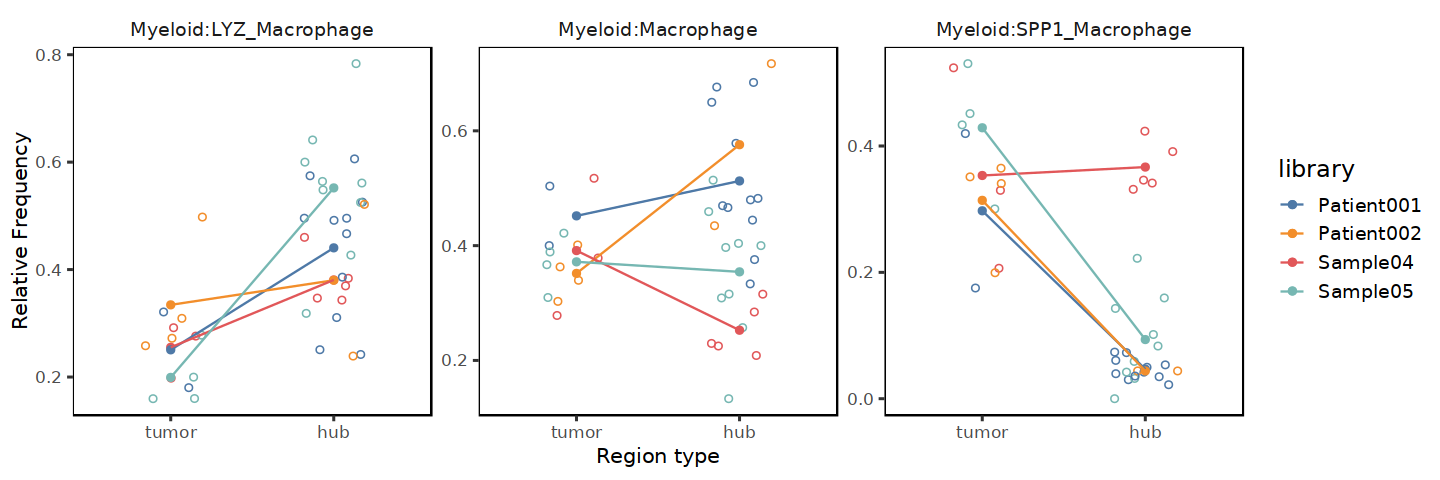

In [114]:
df <- meta_data %>% 
    st_drop_geometry() %>% 
    # subset(grepl('Myeloid', type)) %>% 
    subset(grepl('Macrophage', type)) %>% 
    with(prop.table(table(region, type), 1)) %>% 
    data.table() %>% 
    left_join(
        unique(dplyr::select(st_drop_geometry(meta_data), region, region_type, library))
    )
df$region_type <- factor(df$region_type, c('tumor', 'hub'))
res = df[, broom::tidy(lm(N ~ 1 + region_type + library)), by = type][term == 'region_typehub'][order(-statistic)]
res$fdr <- p.adjust(res$p.value, 'BH')
# res <- res[fdr < .05]
res %>% split(.$estimate < 0)

fig.size(4, 12)
df %>% 
    # dplyr::mutate(type = factor(type, res$`type`)) %>%  ## order by significance 
    subset(!is.na(type)) %>% 
    plot_abundance(nrow = 1)


### Diff abundance - Immune

Joining, by = "region"


$`FALSE`
                      type           term     estimate   std.error statistic
1:               Tcell:CD4 region_typehub 0.1418616171 0.023110870 6.1383070
2:              Tcell:Treg region_typehub 0.0357039914 0.006704167 5.3256419
3:           Plasma:Plasma region_typehub 0.0678165776 0.014717021 4.6080372
4:          Tcell:TCF7_CD8 region_typehub 0.0171193858 0.004201585 4.0745063
5: Myeloid:LAMP3_Dendritic region_typehub 0.0248150476 0.011330198 2.1901690
6: Endothelial:Endothelial region_typehub 0.0061007942 0.007609824 0.8016998
7:       Fibroblast:COL3A1 region_typehub 0.0045135912 0.022974467 0.1964612
8:               Tcell:CD8 region_typehub 0.0004008718 0.007056098 0.0568121
        p.value          fdr
1: 5.077977e-07 2.369723e-06
2: 5.983951e-06 1.675506e-05
3: 5.210214e-05 1.215716e-04
4: 2.515262e-04 5.030524e-04
5: 3.526469e-02 6.171320e-02
6: 4.281363e-01 5.449008e-01
7: 8.453855e-01 9.791409e-01
8: 9.550180e-01 9.791409e-01

$`TRUE`
                      type           term      estimate   std.error
1:             Mural:Mural region_typehub -0.0001664215 0.006319768
2:  Myeloid:LYZ_Macrophage region_typehub -0.0145468999 0.017575671
3:          Fibroblast:FN1 region_typehub -0.0211019170 0.012927686
4:         Fibroblast:EGR1 region_typehub -0.0378930824 0.006774338
5: Myeloid:SPP1_Macrophage region_typehub -0.1288201414 0.013250417
6:      Myeloid:Macrophage region_typehub -0.0958034145 0.009018603
      statistic      p.value          fdr
1:  -0.02633349 9.791409e-01 9.791409e-01
2:  -0.82767250 4.134640e-01 5.449008e-01
3:  -1.63230426 1.115816e-01 1.735713e-01
4:  -5.59362162 2.651780e-06 9.281229e-06
5:  -9.72196874 1.763825e-11 1.234677e-10
6: -10.62286626 1.703942e-12 2.385518e-11

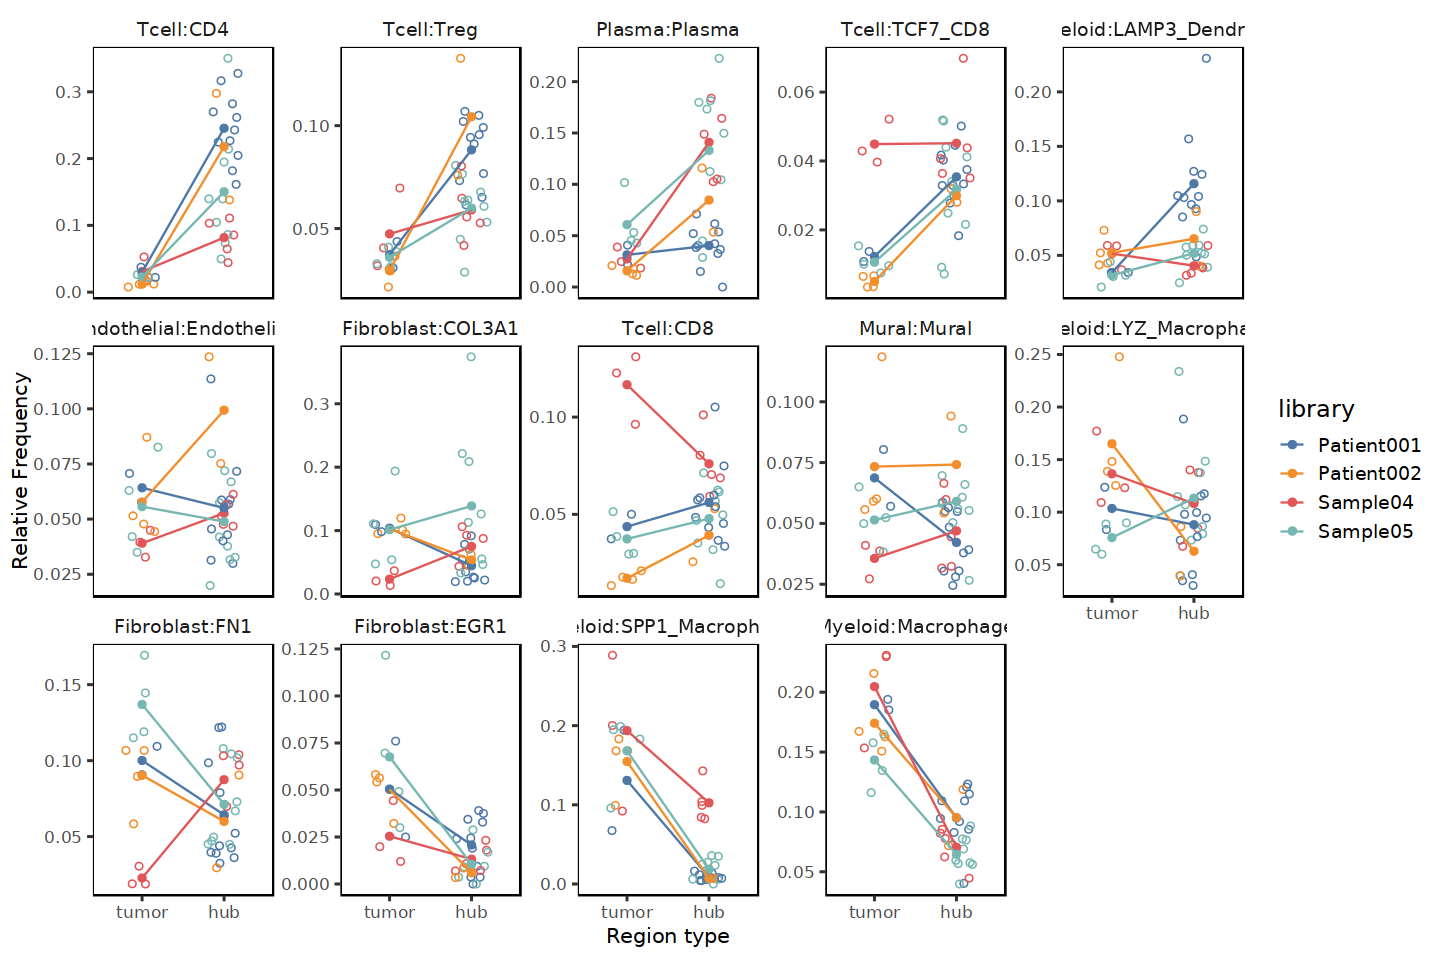

In [443]:
df <- meta_data %>% 
    # st_drop_geometry() %>% 
    subset(!grepl('Epithelial', type)) %>% 
    # subset(grepl('Tcell|Myeloid|Plasma', type)) %>% 
    # subset(grepl('Tcell', type)) %>% 
    with(prop.table(table(region, type), 1)) %>% 
    data.table() %>% 
    left_join(
        # unique(dplyr::select(st_drop_geometry(meta_data), region, region_type, library))
        unique(dplyr::select((meta_data), region, region_type, library))
    )
df$region_type <- factor(df$region_type, c('tumor', 'hub'))
res = df[, broom::tidy(lm(N ~ 1 + region_type + library)), by = type][term == 'region_typehub'][order(-statistic)]
res$fdr <- p.adjust(res$p.value, 'BH')
# res <- res[fdr < .05]
res %>% split(.$estimate < 0)

fig.size(8, 12)
df %>% 
    dplyr::mutate(type = factor(type, res$`type`)) %>%  ## order by significance 
    subset(!is.na(type)) %>% 
    plot_abundance(nrow = 3)


## Regions by type 

In [ ]:
fig.size(10, 12)
ggplot() + 
    geom_sf(data = regions_df, aes(color = type, fill = type), alpha = .2, size = 10) + 
    geom_sf(data = st_centroid(regions_df), color = 'black', fill = 'black') + 
    geom_text_repel(
        data = cbind(st_drop_geometry(regions_df), st_coordinates(st_centroid(regions_df))), 
        aes(X, Y, label = ID)
    ) + 
    facet_wrap(~library, nrow = 2) + 
    scale_color_tableau() + 
    scale_fill_tableau() + 
    NULL



## UMAP - gene expression (not great but show anyway)

In [15]:
df <- meta_data %>% 
    cbind(U2$embedding) %>% 
    cbind(t(scaleData(logcpx[c('CXCL9', 'CXCL10', 'CXCL11'), ], 1, 3))) %>% 
    cbind(clusters) %>% 
    # subset(!Clust2.1 %in% c('24')) %>% 
    dplyr::sample_n(1e5) %>% 
    tidyr::gather(key, val, matches('CXCL')) %>% 
    dplyr::mutate(key = factor(key, paste0('CXCL', c(9, 10, 11))))

### bins

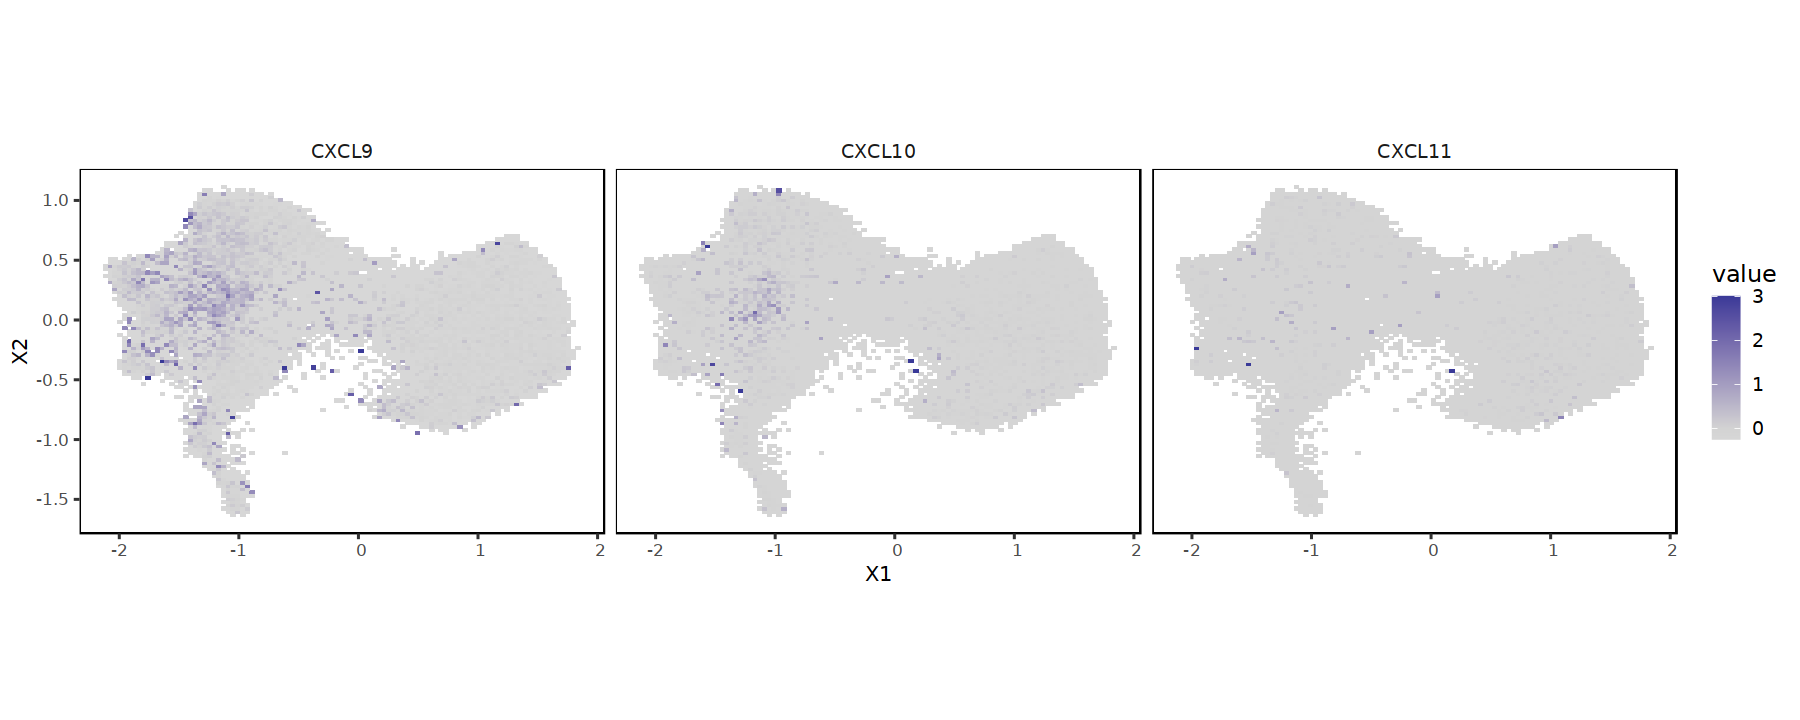

In [22]:
fig.size(6, 15)
df %>% 
    ggplot(aes(X1, X2, z = val)) + 
        stat_summary_2d(fun = mean, bins = 100) + 
        coord_sf() + 
        facet_wrap(~key, nrow = 1) + 
        scale_color_gradient2(low = 'lightgrey', mid = 'lightgrey', midpoint = 0) + 
        scale_fill_gradient2(low = 'lightgrey', mid = 'lightgrey', midpoint = 0) + 
        NULL


### points - shuffled

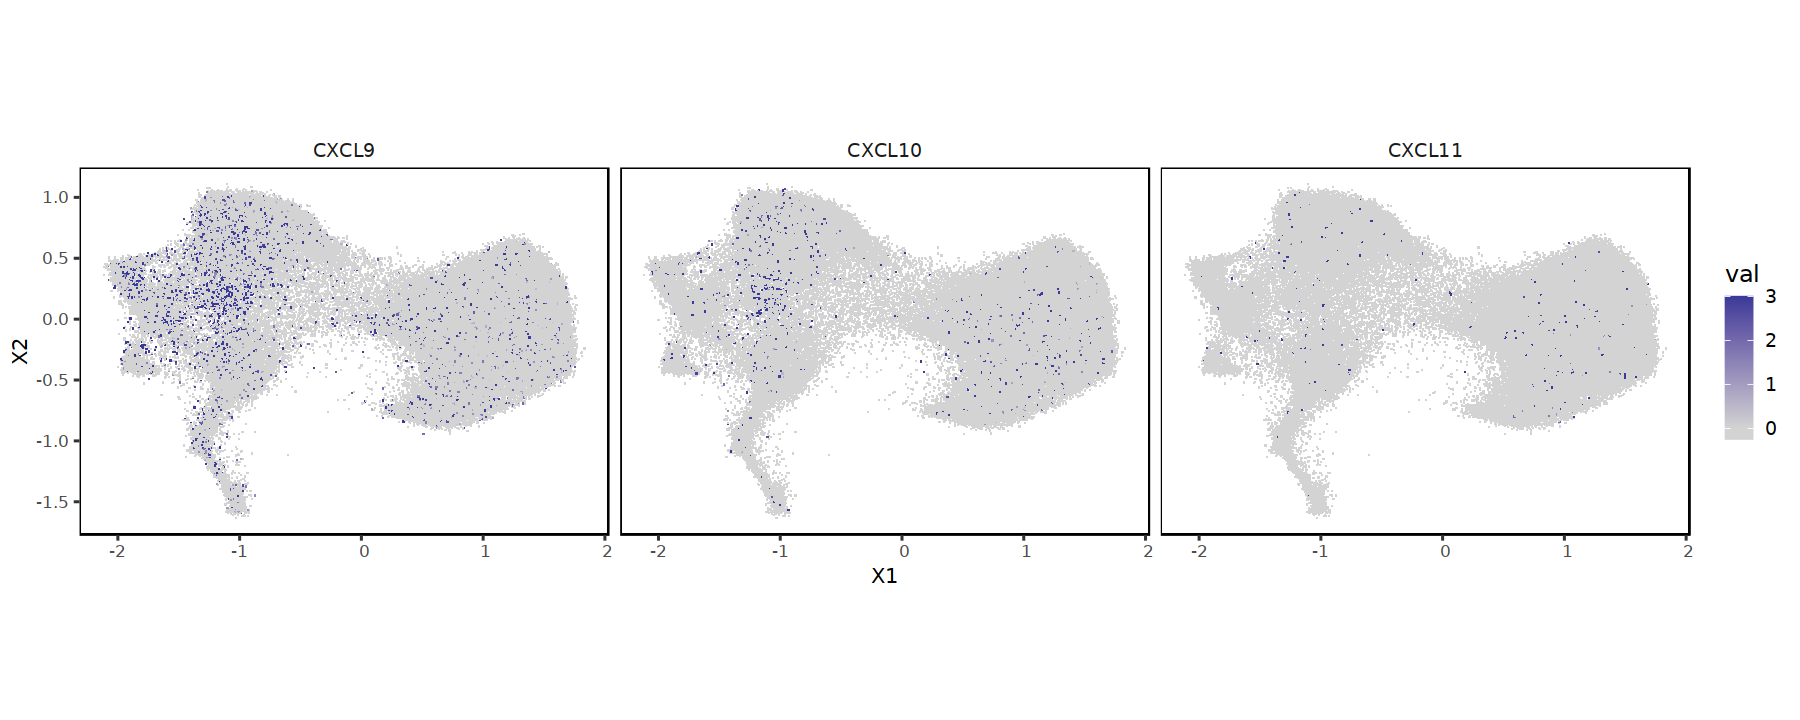

In [17]:
fig.size(6, 15)
df %>% 
    sample_frac(1L) %>% 
    ggplot(aes(X1, X2, color = val)) + 
        geom_point(shape = '.', alpha = 1) + 
        coord_sf() + 
        facet_wrap(~key, nrow = 1) + 
        scale_color_gradient2(low = 'lightgrey', mid = 'lightgrey', midpoint = 0) + 
        scale_fill_gradient2(low = 'lightgrey', mid = 'lightgrey', midpoint = 0) + 
        # scale_color_gradient2_tableau() + 
        NULL


### points - sorted

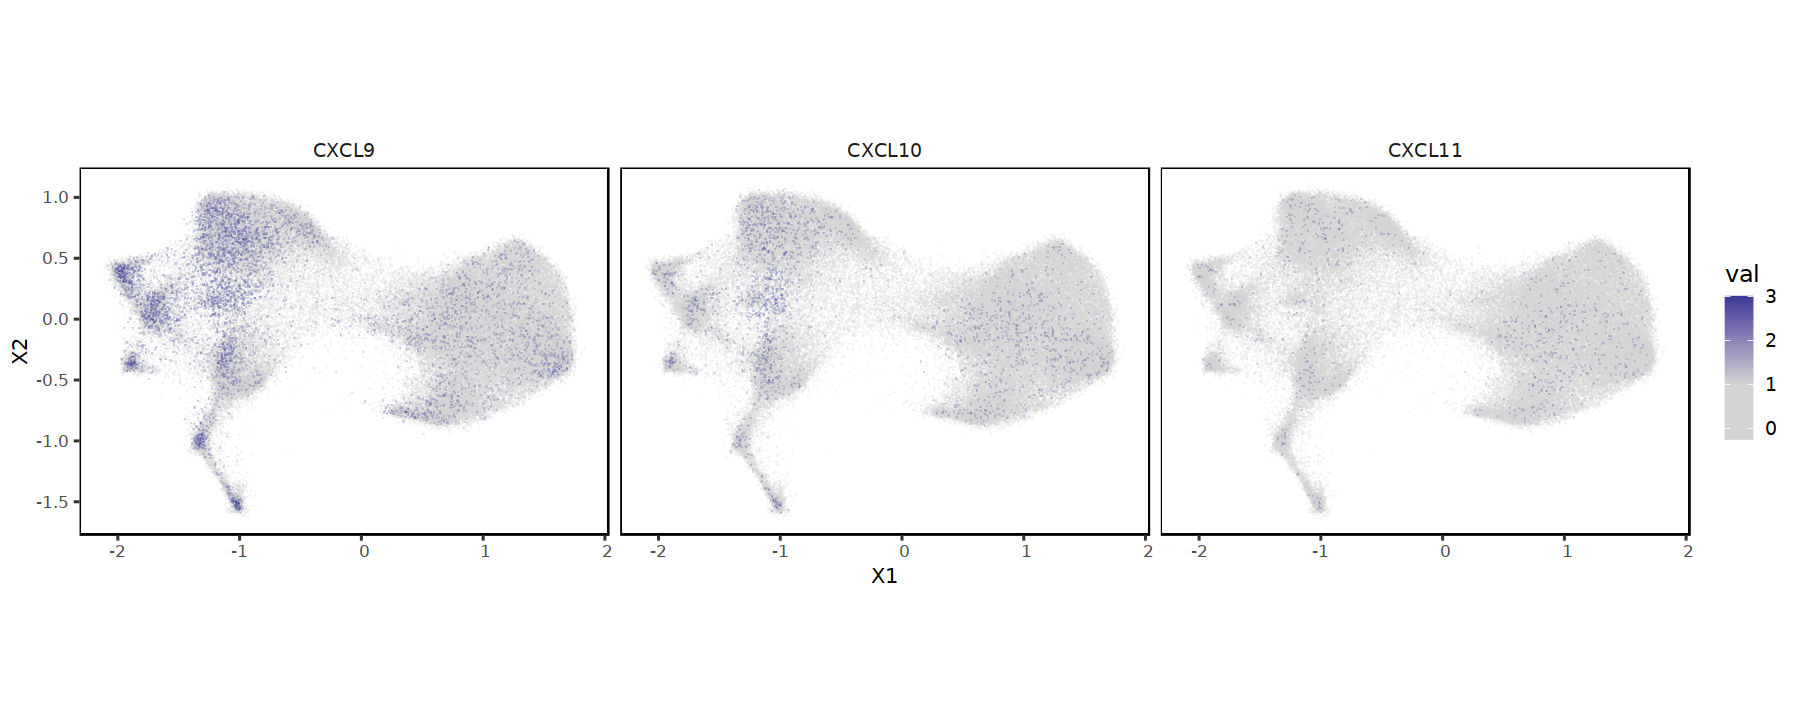

In [19]:
fig.size(6, 15)
df %>% 
    arrange(val) %>% 
    ggplot(aes(X1, X2, color = val)) + 
        geom_point(shape = '.', alpha = .2) + 
        coord_sf() + 
        facet_wrap(~key, nrow = 1) + 
        scale_color_gradient2(low = 'lightgrey', mid = 'lightgrey', midpoint = 1) + 
        scale_fill_gradient2(low = 'lightgrey', mid = 'lightgrey', midpoint = 1) + 
        # scale_color_gradient2_tableau() + 
        NULL


## Table: markers

## Table: cell info (UMAP, XY, region, library, type)

## Data: mtx file

- check that it's loadable in python


## Selected genes


In [438]:
g <- c(
    'CXCL9', 'CXCL10', 'CXCL11', 'CXCL13', 'CCL5', 'CCL17', 'CCL18', 'CCL19', 'CCL21', 'CCL22',
    'IFI6', 'IFI27', 'ISG15', 'ISG20', 'LY6C', 'PDCD1', 'STAT1', 'TAP1', 'CXCR3', 'IFNG'
)


In [439]:
set.seed(5)
ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 10))
ht_opt("heatmap_row_names_gp" = gpar(fontsize = 10))


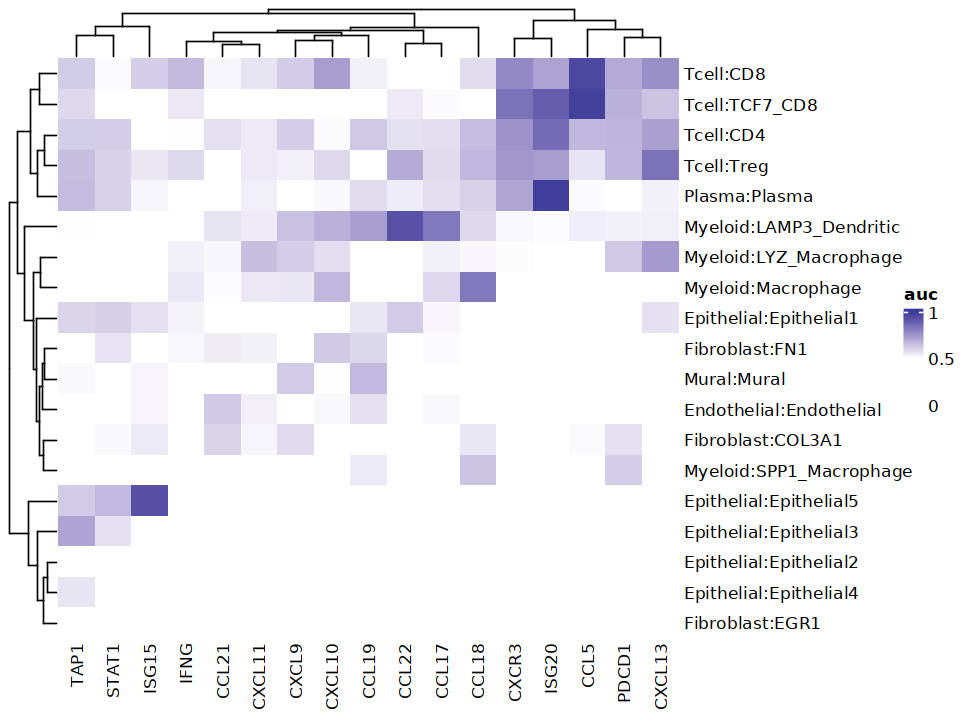

In [440]:
fig.size(6, 8)
markers_types %>% 
    subset(feature %in% g) %>%
    select(feature, group, auc) %>% 
    tidyr::spread(group, auc) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() %>% t() %>% 
    Heatmap(
        name = 'auc',
        col = colorRamp2(c(0, .5, 1), c('white', 'white', muted('blue')))
    )
